In [1]:
%load_ext autoreload
%autoreload 2

# Preparations

In [2]:
# need to run once in the beginning to prepare all ingredients for the analysis
# this might take several minutes

# run these only if you haven't done so before
# load IceCube's effective area and rotate it to approximate other detectors
# %run ../../core/aeff_calculations.py

# calculate the atmospheric neutrino background using MCEq (IceCube-centric)
# %run ../../core/atmospheric_background.py

# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
# %run ../../core/resolution.py

# gather all ingredients and save them as unified 'mephistogram' data structure
# %run ../../core/prepare_histograms.py

# Imports

In [3]:
from resolution import energy_smearing
import mkl

mkl.set_num_threads(1)
from fluxes import parabola_index, power_law
import pickle
from collections import namedtuple
from itertools import product
from copy import copy, deepcopy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    power_law,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.interpolate import InterpolatedUnivariateSpline

from scipy.stats import chi2, norm
import settings as st
from settings import plt
from tools import array_source_interp, poisson_llh, get_scaler, get_mids
from tqdm import tqdm
from matplotlib.colors import ListedColormap
from tools import add_plane, add_obj
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, SkyCoord
import astropy.units as u
from aeff_calculations import setup_aeff_grid
from glob import glob
from astropy.constants import h


# max value of angular distance
delta_psi_max = 2
psi2_bins = np.linspace(
    0, delta_psi_max**2, num=int(delta_psi_max**2 * st.bins_per_psi2) + 1
)
psi2_mids = get_mids(psi2_bins)

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# Settings

In [4]:
# coordinates
# PKS 1502+106
pks1502 = SkyCoord(
    ra="15:04:24.98", dec="+10:29:39.2", frame="icrs", unit=(u.hourangle, u.deg)
)
# GW-GRB Right ascension 13h 09m 48.08s, Declination	−23° 22′ 53.3″
gw_170817 = SkyCoord(
    ra="13:09:48.08", dec="-23:22:53.3", frame="icrs", unit=(u.hourangle, u.deg)
)
# AO 0235+164 ra = 02:38:38.9301, dec = +16:36:59.275 (2000) blazar
ao_0235 = SkyCoord(
    ra=" 02:38:38.9301", dec="16:36:59.275", frame="icrs", unit=(u.hourangle, u.deg)
)
# TXS: defined in settings

In [5]:
E = 1 * u.erg
nu = 1 * u.Hz
Enu = nu * h

# unit conversion
erg_to_GeV = E.to(u.GeV).value
nu_to_GeV = Enu.to(u.GeV).value
nu_to_erg = Enu.to(u.erg).value

print(erg_to_GeV, nu_to_GeV, nu_to_erg)

624.1509074460764 4.135667696923859e-24 6.62607015e-27


In [6]:
detector_configurations = {
    "IceCube": (["IceCube"], [1]),
    "IceCube-Gen2": (["IceCube"], [st.GEN2_FACTOR]),
    "P-ONE": (["IceCube", "P-ONE"], [1, 1]),
    "KM3NeT": (["IceCube", "KM3NeT"], [1, 1]),
    "Plenum-1": (["IceCube", "P-ONE", "KM3NeT", "Baikal-GVD"], [1, 1, 1, 1]),
    "Plenum-2": (["IceCube", "P-ONE", "KM3NeT", "Baikal-GVD"], [st.GEN2_FACTOR, 1, 1, 1]),
}

In [7]:
# energy resolution files
e_res_files = {
    "baseline": join(st.LOCALPATH, "energy_smearing_GP_up.pckl"),
    "reproduction": join(st.LOCALPATH, "artificial_smoothed_energy_smearing_GP_up.pckl"),
    "1:1": join(st.LOCALPATH, "idealized_artificial_energy_smearing_GP_up.pckl"),
    "improved-20": join(
        st.LOCALPATH, "improved_0.2_artificial_energy_smearing_GP_up.pckl"
    ),
    "improved-50": join(
        st.LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"
    ),
}

# plot settings for different detector_configurations
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + IC-North",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}

## helper functions

In [8]:
def scaling_estimation(
    df, current_thresholds, scaler, nmax=20, min_steps=1, stop_here=0.1, stepper=1.5, key="SosB"
):
    """Estimate the best flux scaling factor to reach the current
    p-value threshold based on interpolating the recent tests with
    different scaling factors"""

    # start with min_step+1 values for the scaling factor
    if len(df) <= min_steps:
        if df.iloc[-1]["log10(p)"] > -np.log10(current_thresholds[0]):
            scaler_new = scaler / (stepper * len(df))
        else:
            scaler_new = scaler * (stepper * len(df))
        
        # wobble a bit
        scaler_new *= np.random.normal(loc=1, scale=0.2)
        return scaler_new

    # check if we already sampled close enough to the threshold
    if abs(df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0])) < stop_here:
        # when we found one pval close to the threshold,
        # pick the next threshold
        _ = current_thresholds.pop(0)
        if len(current_thresholds) == 0:
            return -1

    # do the interpolation
    # pick the first threshold from the list
    scaler_new = get_scaler(df, current_thresholds[0])

    # wobble it a bit to sample better
    scaler_new *= np.random.normal(loc=1, scale=0.1)

    if scaler_new <= 0 or np.isnan(scaler_new):
        # in case something went wrong
        # some random value to get started again
        print("scaling went wrong:", scaler_new)
        scaler_new = np.random.uniform(1.5, 3.5) / df.iloc[-1][key]

    # break the optimization loop once we reached nmax
    if len(df) == nmax:
        print(
            "Optimization failed! Diff is:",
            df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0]),
            "thresh is:",
            current_thresholds[0],
        )
        _ = current_thresholds.pop(0)
    return scaler_new

## Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [9]:
with open(join(st.LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)

with open(join(st.LOCALPATH, "effective_area_MH_full.pckl"), "rb") as f:
    aeff_2d_full = pickle.load(f)

# print(aeff_2d_full.keys())
# print(aeff_2d_full["IceCube"])

## Atmospheric background
Actually, we would need to account for the different zenith regions of a source, if the detector is not at one of the poles.
This is currently not yet implemented

In [10]:
with open(join(st.LOCALPATH, "atmospheric_background_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))

Elementary arithmetic possible.
True


## Energy resolution function

In [11]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)  # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1)  # normalize per logE_true


In [12]:

# checking if matrix multiplication is possible
print(aeff_2d["IceCube"].match_matmul(baseline_eres, verbose=True))
# ... it's not commutative, though
print(baseline_eres.match_matmul(aeff_2d["IceCube"], verbose=True, raise_err=False))
energy_reso = {"baseline": baseline_eres, "improved": improved_eres} # easy access

Matrix multiplication possible.
True
Matrix multiplication not possible. Shapes are (140, 139) and (100, 140);
False


## Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

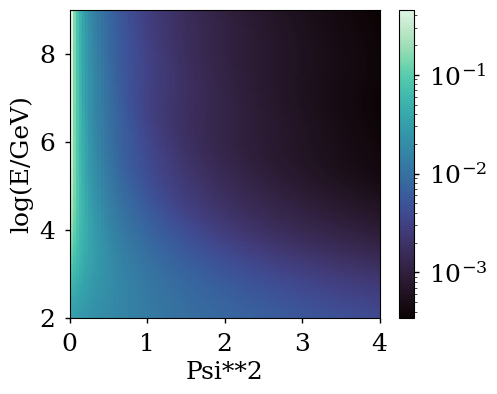

In [13]:
# angular resolution
with open(join(st.LOCALPATH, f"Psi2-{delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()
e_psi2_grid.plot(norm=LogNorm())

## Flux definition

In [14]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

## calculate number ov events

(very blackmetal)

## Log Parabola

In [15]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=st.sindec_mids,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid
# TXS parameters
with open("../../local/txs_contour.pkl", "rb") as f:
    txs_contour = pickle.load(f)

GAMMA_TXS = 2. #txs_contour["best-fit"][0]
PHI_TXS = 2.7E-20 #txs_contour["best-fit"][1] / 1E3 / 3 # fudge factor. # @ 1 TeV / GeV cm² s
E0_TXS = txs_contour["E0"] 
txs_flux = PL_flux(PHI_TXS, GAMMA_TXS, E0_TXS, "powerlaw")

In [16]:
Alpha = 2
E_para_norm = 1e6
Beta = 1
PHI_lp = 2.6640985514261466e-22 # :)
conservative_livetime = 7.5 * 365 * 24 * 3600

logp_flux = LogP_flux(PHI_lp, Alpha, Beta, E_para_norm, "log-parabola")

ident = "IceCube"
# check that the bins match
aeff_factor_signal = calc_aeff_factor(
    aeff_2d[ident], dec=0, livetime=conservative_livetime, **src_config
)


k_s = astro_flux(
    aeff_factor_signal,
    st.emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=logp_flux,
)
print("n events", np.sum(k_s)) 

aeff_factor_signal = calc_aeff_factor(
    aeff_2d[ident], dec=0, livetime=st.LIVETIME, **src_config
)

k_s = astro_flux(
    aeff_factor_signal,
    st.emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=txs_flux,
)
print("n events", np.sum(k_s)) 

n events 0.9568491423613088
n events 4.827702774142764


# Models


## setup

In [17]:
base_dct = {"src_name": 0, "model_name": 0, "state": 0, "bf_or_band": 0, "N_nu(IC)": 0, "model_spline": 0, "dec/rad": 0, "livetime/s": 0}
all_models = []

### Fang & Metzger GRB model

In [18]:
grb_1000s_moderate = pd.read_csv("/home/hpc/capn/capn102h/repos/Plenum/local/neutrino_models/GRB_1000sec_moderate_0deg_Kimura.txt", sep="; ")
grb_1000s_optimistic = pd.read_csv("/home/hpc/capn/capn102h/repos/Plenum/local/neutrino_models/GRB_1000sec_optimistic_4deg_Kimura.txt", sep="; ")
grb_3d = pd.read_csv("/home/hpc/capn/capn102h/repos/Plenum/local/neutrino_models/GRB_3d_Fang-Metzger.txt", sep="; ")
grb_14d = pd.read_csv("/home/hpc/capn/capn102h/repos/Plenum/local/neutrino_models/GRB_14d_Fang-Metzger.txt", sep="; ")



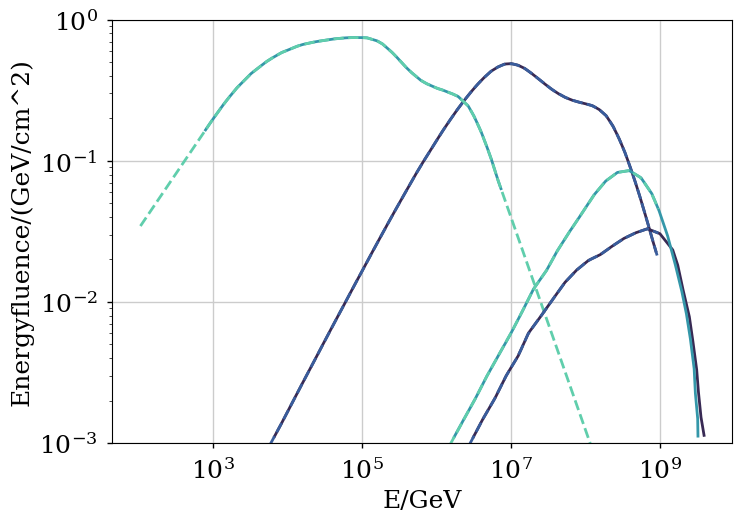

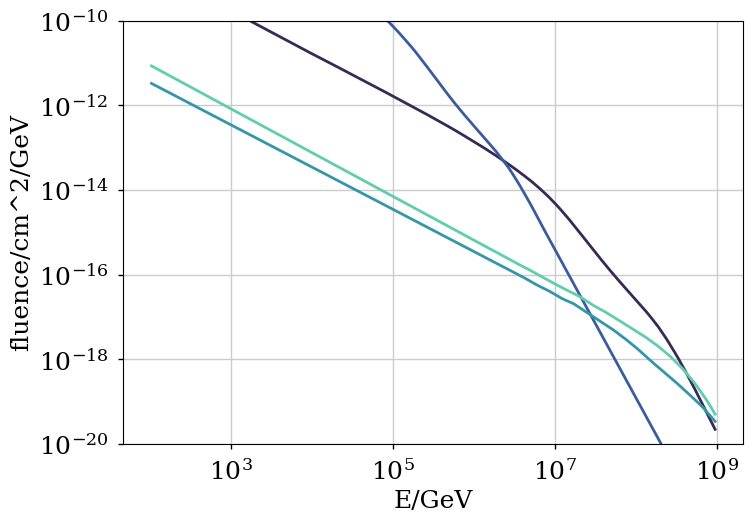

In [19]:
grb_models = []
for label, livetime, grb in zip(
    ["1000s moderate 0deg", "1000s optimistic 4deg", "3d", "14d"],
    [1000, 1000, 3 * 24 * 3600, 14 * 24 * 3600],
    [grb_1000s_moderate, grb_1000s_optimistic, grb_3d, grb_14d],
):
    _spl = InterpolatedUnivariateSpline(
        np.log10(grb["Energy/GeV"]), np.log10(grb["Energyfluence/(GeV/cm^2)"] / (grb["Energy/GeV"]**2)), k=1
    )
    plt.figure(1)
    plt.plot(grb["Energy/GeV"], grb["Energyfluence/(GeV/cm^2)"])
    plt.plot(10**st.logE_mids, 10 ** _spl(st.logE_mids) * (10**(st.logE_mids * 2)) , ls="--")
    plt.ylabel("Energyfluence/(GeV/cm^2)")
    plt.xlabel("E/GeV")
    plt.loglog()
    plt.ylim(1e-3, 1)

    plt.figure(2)
    plt.plot(10**st.logE_mids, 10 ** _spl(st.logE_mids) )
    plt.ylabel("fluence/cm^2/GeV")
    plt.xlabel("E/GeV")
    plt.loglog()
    plt.ylim(1e-20, 1e-10)
    grb_models.append(
        {"src_name": "GW170817", "model_name": label, "state": "grb", "bf_or_band": "bestfit", "N_nu(IC)": 0, "model_spline": _spl, "dec/rad": gw_170817.dec.rad, "livetime/s": livetime}
    )
grb_models = pd.DataFrame(grb_models)

1000s moderate 0deg 1.1499837236895547
1000s optimistic 4deg 19.048874481653847
3d 0.0081372809799507
14d 0.01710658093854466


Text(0, 0.5, '$n_\\nu$ per bin')

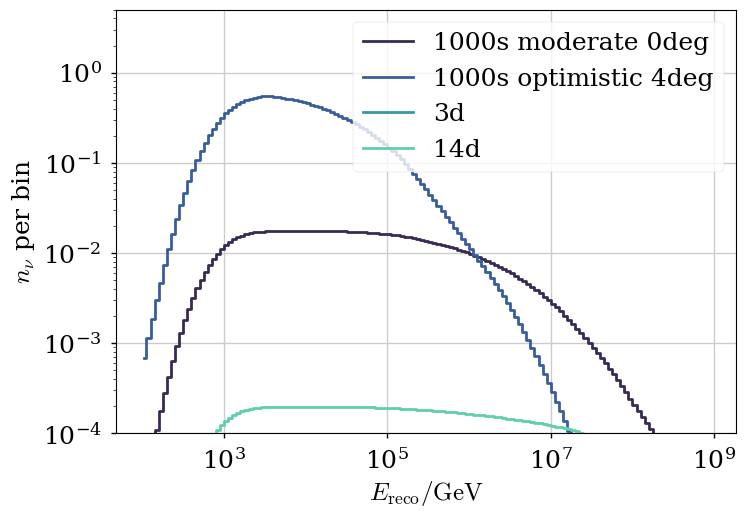

In [20]:
aeff_factor_signal = calc_aeff_factor(
    aeff_2d["P-ONE"],  # ... because it's in the south
    dec=gw_170817.dec.rad,
    livetime=1,  # flare livetime is already in the fluence
    **src_config,
)
for i, row in grb_models.iterrows():
    _nev = aeff_factor_signal * 10 ** row["model_spline"](st.logE_mids)

    print(row["model_name"], np.sum(_nev))
    grb_models.loc[i, "N_nu(IC)"] = np.sum(_nev)

    plt.plot(10**st.logE_reco_mids, energy_smearing(improved_eres, _nev).sum(axis=0), label=row["model_name"], ds="steps-mid")
plt.loglog()
plt.ylim(1E-4, 5)
plt.legend()
plt.xlabel(r"$E_{\rm reco} \rm /GeV$")
plt.ylabel(r"$n_\nu$ per bin")

In [21]:
grb_models

src_name             model_name state bf_or_band   N_nu(IC)  \
0  GW170817    1000s moderate 0deg   grb    bestfit   1.149984   
1  GW170817  1000s optimistic 4deg   grb    bestfit  19.048874   
2  GW170817                     3d   grb    bestfit   0.008137   
3  GW170817                    14d   grb    bestfit   0.017107   

                                        model_spline   dec/rad  livetime/s  
0  <scipy.interpolate._fitpack2.InterpolatedUniva... -0.408084        1000  
1  <scipy.interpolate._fitpack2.InterpolatedUniva... -0.408084        1000  
2  <scipy.interpolate._fitpack2.InterpolatedUniva... -0.408084      259200  
3  <scipy.interpolate._fitpack2.InterpolatedUniva... -0.408084     1209600

### Foteini's models

In [22]:
blazar_models = pd.read_csv("/home/hpc/capn/capn102h/repos/Plenum/local/neutrino_models/declinations.txt", sep=", ")
blazar_models["N_nu(IC)"] = 0
blazar_models["state"] = 0
blazar_models["bf_or_band"] = "bestfit"
blazar_models["N_nu(IC)"] = 0
blazar_models["model_spline"] = None
blazar_models["dec/rad"] = np.deg2rad(blazar_models["declination(degrees)"])
blazar_models["livetime/s"] = blazar_models["DeltaT"] * 24 * 3600


S5 0716+714 5.5e-04 livetime: 6    14
Name: DeltaT, dtype: int64
TXS 0506+056 1.8e-02 livetime: 0    175
Name: DeltaT, dtype: int64
1ES 1959+650 MJD 57285 1.8e-06 livetime: 10    84
Name: DeltaT, dtype: int64
1ES 1959+650 MJD 56066 3.5e-06 livetime: 9    46
Name: DeltaT, dtype: int64
PG 1553 113 5.0e-05 livetime: 4    30
Name: DeltaT, dtype: int64
3C66A 8.4e-06 livetime: 1    14
Name: DeltaT, dtype: int64
MRK421 1.2e-04 livetime: 8    13
Name: DeltaT, dtype: int64
BLLAC 9.3e-05 livetime: 2    7
Name: DeltaT, dtype: int64
OJ287 6.0e-03 livetime: 3    7
Name: DeltaT, dtype: int64
MRK501 3.9e-07 livetime: 7    21
Name: DeltaT, dtype: int64
S2 0109+22 6.6e-04 livetime: 11    21
Name: DeltaT, dtype: int64
AO 0235+164 6.5e-02 livetime: 5    84
Name: DeltaT, dtype: int64
S4 0954+65 1.3e-03 livetime: 12    28
Name: DeltaT, dtype: int64


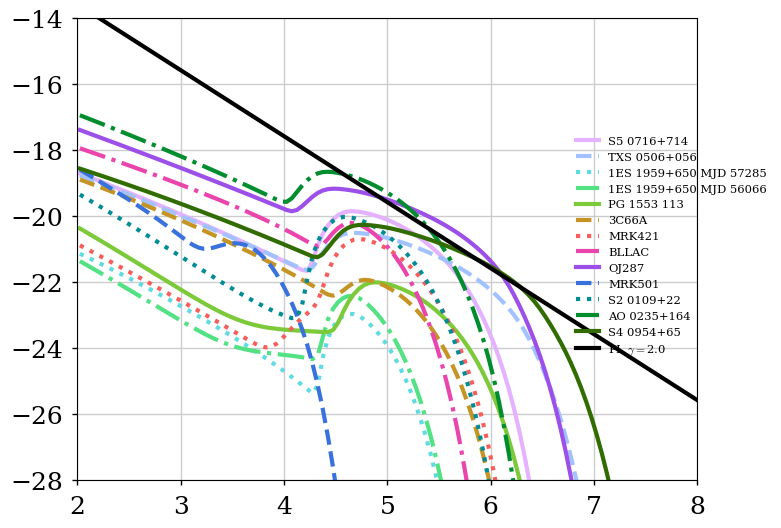

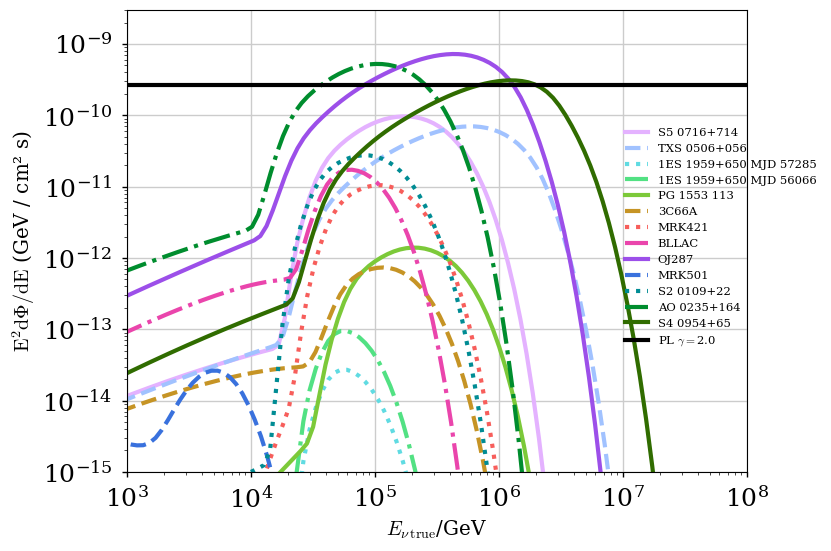

In [23]:
# model overview
model_files = glob(
    join(st.LOCALPATH, "neutrino_models/neutrino_flux_model_B_per_flavor*.dat")
)

f2, ax2 = plt.subplots(figsize=(8, 6))
f, ax = plt.subplots(figsize=(8, 6))
mcolors = sns.cubehelix_palette(
    start=2, rot=3, dark=0.3, hue=2, light=0.8, n_colors=len(model_files)
)
lss = ["-", "--", ":", "-."]
for i, mf in enumerate(model_files):
    model = np.genfromtxt(mf)
    model_name = mf.split("per_flavor_")[-1].split(".")[0].upper().replace("_", " ")
    aeff_factor_signal = calc_aeff_factor(
        aeff_2d["IceCube"],
        dec=blazar_models["dec/rad"]
        .loc[blazar_models.model_name == model_name]
        .iloc[0],
        livetime=blazar_models["livetime/s"]
        .loc[blazar_models.model_name == model_name]
        .iloc[0],
        **src_config,
    )
    mask = model[:, 1] > 0
    x = np.log10(model[:, 0][mask] / 1e9)
    y = np.log10(model[:, 1][mask] * erg_to_GeV / (model[:, 0][mask] / 1e9) ** 2)
    mask = np.isfinite(x) & np.isfinite(y)
    model_spline = InterpolatedUnivariateSpline(x[mask], y[mask], k=1)
    nev = aeff_factor_signal * 10 ** model_spline(st.logE_mids)

    blazar_models.loc[blazar_models.model_name == model_name, "N_nu(IC)"] = np.sum(nev)
    blazar_models.loc[
        blazar_models.model_name == model_name, "model_spline"
    ] = model_spline
    print(
        model_name,
        f"{np.sum(nev):1.1e}",
        f"livetime: {blazar_models['DeltaT'].loc[blazar_models.model_name == model_name]}",
    )

    ax.plot(
        model[:, 0] / 1e9,
        model[:, 1] * erg_to_GeV,
        lw=3,
        label=model_name,
        color=mcolors[i],
        ls=lss[i % 4],
    )
    ax2.plot(
        st.logE_mids,
        model_spline(st.logE_mids),
        lw=3,
        label=model_name,
        color=mcolors[i],
        ls=lss[i % 4],
    )

# txs fit:
x_evals = np.logspace(0, 9, 100)
y_scaling = 2
pl = power_law(x_evals, E0_TXS, GAMMA_TXS, PHI_TXS)
ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"PL $\gamma=${GAMMA_TXS}",
    color="k",
    alpha=1,
    lw=3,
)
ax2.plot(
    np.log10(x_evals),
    np.log10(pl),
    label=rf"PL $\gamma=${GAMMA_TXS}",
    color="k",
    alpha=1,
    lw=3,
)
ax2.set_ylim(-28, -14)
ax2.set_xlim(2, 8)

ax.set_yscale("log")
ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)", fontsize="x-large")
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV", fontsize="x-large")
ax.set_ylim(1e-15, 0.3e-8)
ax.set_xlim(1e3, 1e8)
f.legend(loc="center right", frameon=False, bbox_to_anchor=(1, 0.5), fontsize="small")
f2.legend(loc="center right", frameon=False, bbox_to_anchor=(1, 0.5), fontsize="small")

In [24]:
blazar_models

model_name  declination(degrees)      src_name  DeltaT  \
0             TXS 0506+056                   5.7  TXS 0506+056     175   
1                    3C66A                  43.0        3C 66A      14   
2                    BLLAC                  42.3        BL Lac       7   
3                    OJ287                  20.1        OJ 287       7   
4              PG 1553 113                  11.2   PG 1553+113      30   
5              AO 0235+164                  16.6   AO 0235+164      84   
6              S5 0716+714                  71.4   S5 0716+714      14   
7                   MRK501                  39.8       Mrk 501      21   
8                   MRK421                  38.2       Mrk 421      13   
9   1ES 1959+650 MJD 56066                  20.0   1ES 1959+65      46   
10  1ES 1959+650 MJD 57285                  20.0   1ES 1959+65      84   
11              S2 0109+22                  22.7    S2 0109+22      21   
12              S4 0954+65                  65.6    S4 0954+65      28   

        N_nu(IC)  state bf_or_band  \
0   1.767924e-02      0    bestfit   
1   8.426932e-06      0    bestfit   
2   9.301610e-05      0    bestfit   
3   5.950823e-03      0    bestfit   
4   4.994246e-05      0    bestfit   
5   6.533394e-02      0    bestfit   
6   5.483582e-04      0    bestfit   
7   3.923186e-07      0    bestfit   
8   1.162033e-04      0    bestfit   
9   3.478123e-06      0    bestfit   
10  1.812365e-06      0    bestfit   
11  6.583740e-04      0    bestfit   
12  1.262497e-03      0    bestfit   

                                         model_spline   dec/rad  livetime/s  
0   <scipy.interpolate._fitpack2.InterpolatedUniva...  0.099484    15120000  
1   <scipy.interpolate._fitpack2.InterpolatedUniva...  0.750492     1209600  
2   <scipy.interpolate._fitpack2.InterpolatedUniva...  0.738274      604800  
3   <scipy.interpolate._fitpack2.InterpolatedUniva...  0.350811      604800  
4   <scipy.interpolate._fitpack2.InterpolatedUniva...  0.195477     2592000  
5   <scipy.interpolate._fitpack2.InterpolatedUniva...  0.289725     7257600  
6   <scipy.interpolate._fitpack2.InterpolatedUniva...  1.246165     1209600  
7   <scipy.interpolate._fitpack2.InterpolatedUniva...  0.694641     1814400  
8   <scipy.interpolate._fitpack2.InterpolatedUniva...  0.666716     1123200  
9   <scipy.interpolate._fitpack2.InterpolatedUniva...  0.349066     3974400  
10  <scipy.interpolate._fitpack2.InterpolatedUniva...  0.349066     7257600  
11  <scipy.interpolate._fitpack2.InterpolatedUniva...  0.396190     1814400  
12  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.144936     2419200

### Xavier's models

In [25]:
# J2000 coordinates are RA = 15:04:24.98, Dec = +10:29:39.2
# " If you’re looking for “J2000” coordinates, and aren’t sure if you want to use this or FK5, you probably want to use ICRS.  " :)
flare_files = glob(join(st.LOCALPATH, "neutrino_models/*.csv"))
# for the legend because I am lazy
style = {
    "proton-synchrotron": dict(label="proton-synchrotron", color="darkred", ls="-"),
    "ext_field_a": dict(label="ext_field_a", color="tab:blue", ls=":"),
    "lepto-hadronic": dict(label="lepto-hadronic", color="tab:orange", ls="--"),
}

???


Text(0.5, 0, 'E/GeV')

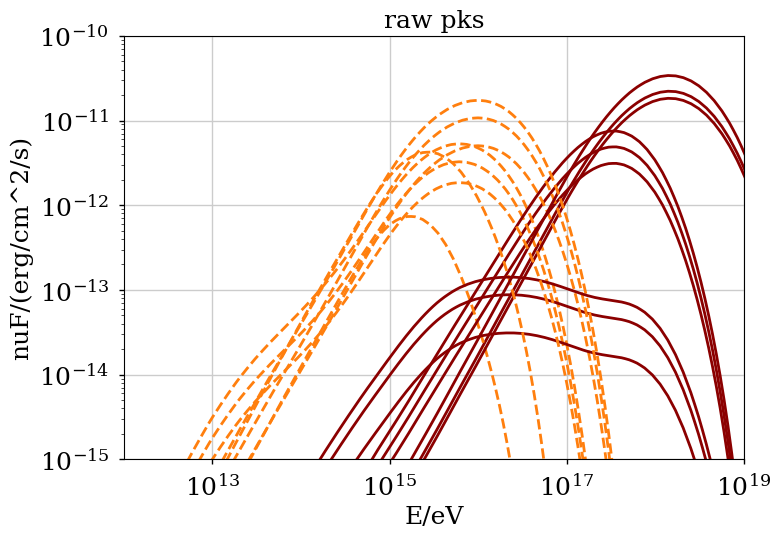

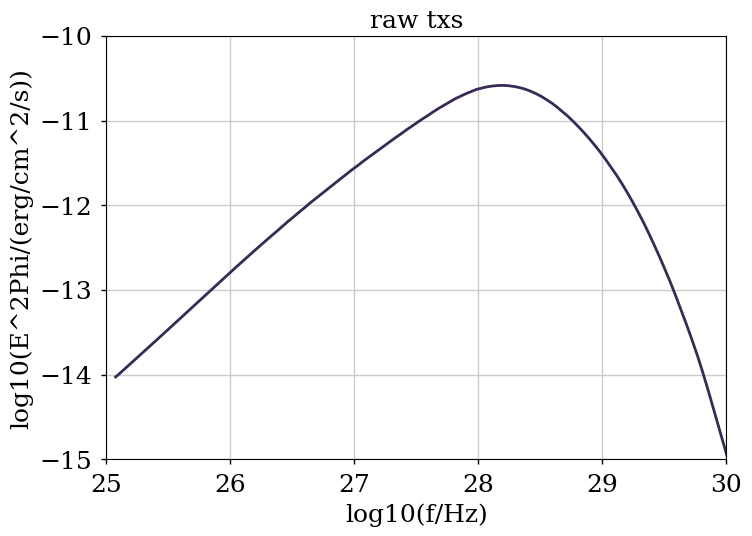

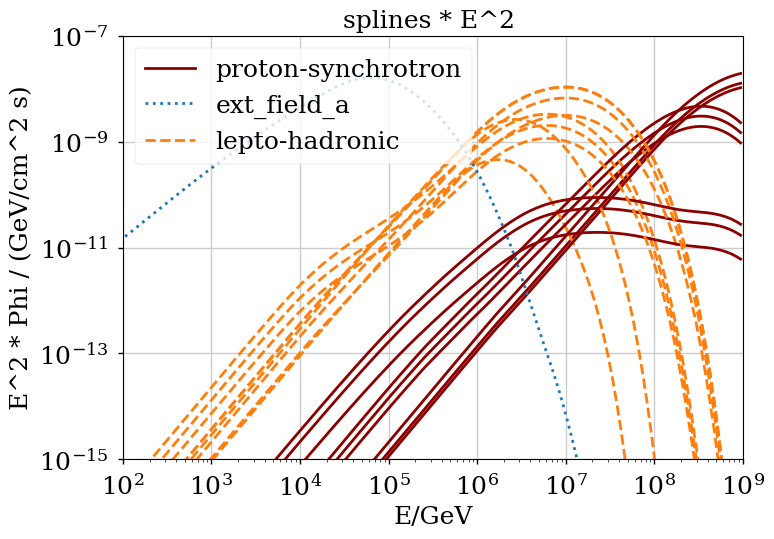

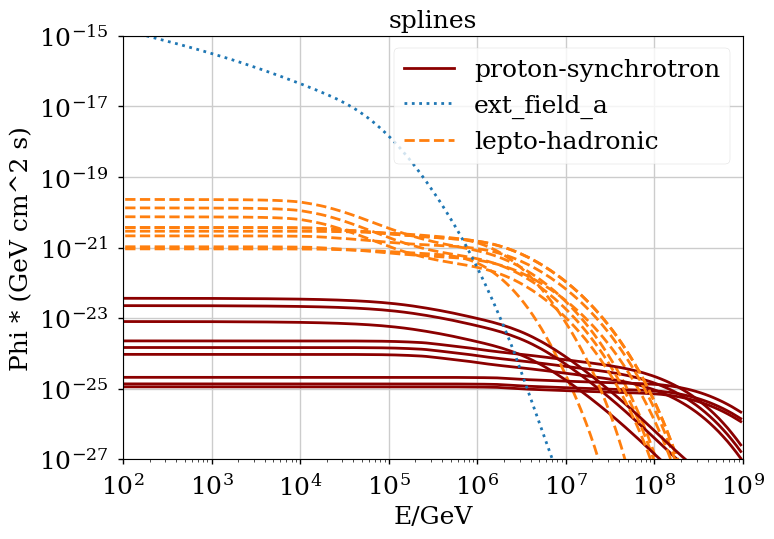

In [241]:
tmp = []
plt.figure(1)
plt.title("raw pks")
plt.loglog()
plt.ylim(1e-15, 1e-10)
plt.xlim(1e12, 1e19)

plt.figure(3)
plt.title("splines * E^2 ")

plt.figure(4)
plt.title("splines")

for f in flare_files:
    # print(f)
    if "PSYN" in f:
        model = "proton-synchrotron"
    elif "txs" in f:
        model = "ext_field_a"
    else:
        model = "lepto-hadronic"

    if "pks_quiescent_neutrinos_bandmin" in f:
        # all zeros
        continue
    mapping = (
        {0: "E/eV", 1: "nuF/(erg/cm^2/s)"}
        if "pks" in f
        else {0: "log10(f/Hz)", 1: "log10(E^2Phi/(erg/cm^2/s))"}
    )
    dat = pd.read_csv(f, header=None).T.rename(columns=mapping)
    labels = f.split("/")[-1].split(".")[0].split("_")

    if "pks" in f:
        mask = dat["nuF/(erg/cm^2/s)"] > 0  # 1e-30
        x = np.log10(dat["E/eV"].loc[mask] / 1e9)  # eV -> GeV
        y = (
            np.log10(dat["nuF/(erg/cm^2/s)"].loc[mask] * erg_to_GeV) - 2 * x
        )  #  nu F_nu -> dN/dt dE dA
        mask = np.isfinite(x) & np.isfinite(y)
        model_spline = InterpolatedUnivariateSpline(x[mask], y[mask], k=1)
        plt.figure(1)
        ax = sns.lineplot(
            data=dat,
            x="E/eV",
            y="nuF/(erg/cm^2/s)",
            color=style[model]["color"],
            ls=style[model]["ls"],
        )

    elif "txs" in f:
        mask = dat["log10(E^2Phi/(erg/cm^2/s))"] > -100  # -30
        x = dat["log10(f/Hz)"].loc[mask] + np.log10(nu_to_GeV)  # nu -> GeV
        y = (
            dat["log10(E^2Phi/(erg/cm^2/s))"].loc[mask] + np.log10(erg_to_GeV) - 2 * x
        )  #  E² Phi [erg] -> Phi [GeV]
        mask = np.isfinite(x) & np.isfinite(y)
        model_spline = InterpolatedUnivariateSpline(x[mask], y[mask], k=1)

        plt.figure(2)
        plt.title("raw txs")
        ax = sns.lineplot(data=dat, x="log10(f/Hz)", y="log10(E^2Phi/(erg/cm^2/s))")
        ax.set_ylim(-15, -10)
        ax.set_xlim(25, 30)

    else:
        print("???")

    plt.figure(3)
    plt.plot(
        10**st.logE_mids,
        10 ** (model_spline(st.logE_mids) + 2 * st.logE_mids),
        color=style[model]["color"],
        ls=style[model]["ls"],
    )
    plt.figure(4)
    plt.plot(
        10**st.logE_mids,
        10 ** model_spline(st.logE_mids),
        color=style[model]["color"],
        ls=style[model]["ls"],
    )

    tmp.append(
        {
            "src_name": labels[0],
            "model_name": model,
            "state": labels[-3],
            "bf_or_band": labels[-1],
            "model_spline": model_spline,
            "N_nu(IC)": 0,
            "dec/rad": 0,
            "livetime/s": 0,
        }
    )

plt.figure(3)
for k in style:
    plt.plot(0, 0, **style[k])
plt.legend()
plt.loglog()
plt.xlim(1e2, 1e9)
plt.ylim(1e-15, 1e-7)
plt.ylabel("E^2 * Phi / (GeV/cm^2 s)")
plt.xlabel("E/GeV")

plt.figure(4)
for k in style:
    plt.plot(0, 0, **style[k])
plt.legend()
plt.loglog()
plt.xlim(1e2, 1e9)
plt.ylim(1e-27, 1e-15)
plt.ylabel("Phi * (GeV cm^2 s)")
plt.xlabel("E/GeV")

In [244]:
nev.sum()

5.862407069966913

In [242]:
flare_models_x = pd.DataFrame(tmp)
flare_models_x.loc[flare_models_x.src_name=="pks", "dec/rad"] = pks1502.dec.rad
flare_models_x.loc[flare_models_x.src_name=="pks", "livetime/s"] = 365 * 24 * 3600 * 3.7 
# "the flux has now been integrated over the total duration of each activity state 
# (3.8 years quiescent, 3.7 years of hard flares, and 3.5 years of soft flares, cf. Tab. 1). 
# from arXiv:2009.04026
flare_models_x.loc[flare_models_x.src_name=="txs", "dec/rad"] = st.txs0506.dec.rad
flare_models_x.loc[flare_models_x.src_name=="txs", "livetime/s"] = 158 * 24 * 3600

#flare_models_x
for _, series in flare_models_x.iterrows(): # .loc[flare_models_x.bf_or_band=="bestfit"]
    # if "proton" in series.model_name: continue
    print(series)
    aeff_factor_signal = calc_aeff_factor(
            aeff_2d["IceCube"],
            dec=series["dec/rad"],
            livetime=series["livetime/s"],
            **src_config,
        )

    nev = aeff_factor_signal * 10 ** series["model_spline"](st.logE_mids)
    print(np.sum(nev))
    flare_models_x.loc[_, "N_nu(IC)"] = np.sum(nev)
    print("")

src_name                                                      pks
model_name                                     proton-synchrotron
state                                                   softflare
bf_or_band                                                bestfit
model_spline    <scipy.interpolate._fitpack2.InterpolatedUniva...
N_nu(IC)                                                        0
dec/rad                                                  0.183159
livetime/s                                              116683200
Name: 0, dtype: object
0.04556618148765273

src_name                                                      pks
model_name                                     proton-synchrotron
state                                                   hardflare
bf_or_band                                                bestfit
model_spline    <scipy.interpolate._fitpack2.InterpolatedUniva...
N_nu(IC)                                                        0
dec/rad                         

# Summarize models

In [28]:
all_models = pd.concat([grb_models, flare_models_x, blazar_models], ignore_index=True)

In [29]:
selected_models = {
    "PKS 1502+106 lepto-had. (Rodrigues et al.)": {
        "model": flare_models_x.loc[
            (flare_models_x.bf_or_band == "bestfit")
            & (flare_models_x.src_name == "pks")
            & (flare_models_x.state == "hardflare")
            & (flare_models_x.model_name == "lepto-hadronic")
        ].iloc[0],
        "start_scaler": 6,
        "coords": pks1502,
    },
    "TXS 0506+056 (Rodrigues et al.)": {
        "model": flare_models_x.loc[
            (flare_models_x.bf_or_band == "bestfit")
            & (flare_models_x.src_name == "txs")
        ].iloc[0],
        "start_scaler": 17,
        "coords": st.txs0506,
    },
    "AO 0235+164 (Oikonomou et al.)": {
        "model": blazar_models.loc[blazar_models.src_name == "AO 0235+164"].iloc[0],
        "start_scaler": 15,
        "coords": ao_0235,
    },
    "GW170817-GRB 14-day (Fang & Metzger)": {
        "model": grb_models.loc[grb_models.model_name == "14d"].iloc[0],
        "start_scaler": 3,
        "coords": gw_170817,
    },
}

# Plot 1D analysis slice histograms

## angular distance

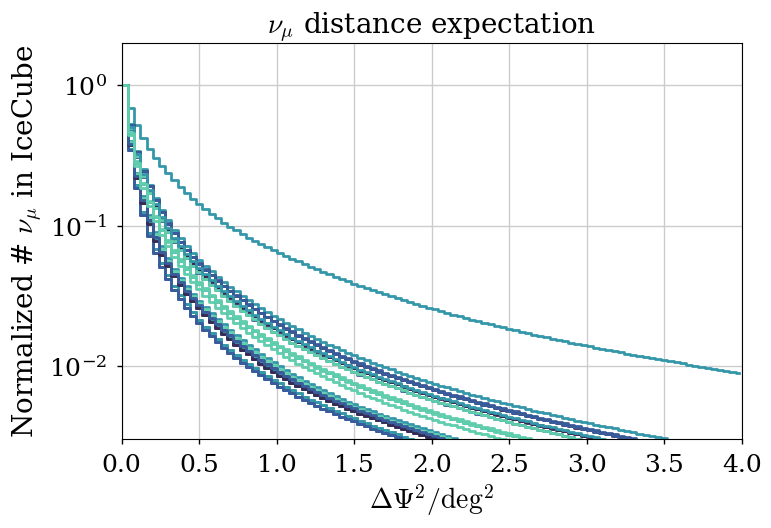

In [30]:
sq_deg = np.pi * delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

f, ax = plt.subplots()
fontsize = 20

for _, row in all_models.iterrows():
    aeff_factor_signal = calc_aeff_factor(
        aeff_2d["IceCube"],  # ... because it's in the south
        dec=row["dec/rad"],
        livetime=1 if row.state=="grb" else row["livetime/s"],  # flare livetime is already in the fluence
        **src_config,
    )
    _nev = aeff_factor_signal * 10 ** row["model_spline"](st.logE_mids)
    x = np.concatenate([[-0.1], psi2_mids])
    y= np.concatenate([[0], energy_smearing(improved_eres, _nev).sum(axis=1)])
    y /= np.max(y) # normalize highest bin to 1 for comparison
    ax.plot(
        x,
        y,
        label=row["model_name"],
        ds="steps-mid",
    )

ax.set_ylabel(r"Normalized # $\nu_\mu$ in IceCube", fontsize=fontsize)
ax.set_xlim(0, 4)
plt.yscale("symlog", linthresh=3E-3)
ax.set_ylim(3E-3, 2)
ax.set_xlabel(r"$\Delta \Psi ^2 / {\rm deg}^2$", fontsize=fontsize)
ax.set_title(r"$\nu_\mu$ distance expectation", fontsize=fontsize)
f.subplots_adjust(hspace=0.33, top=0.83)

## Event distr in reco energy

(2.0, 9.0)

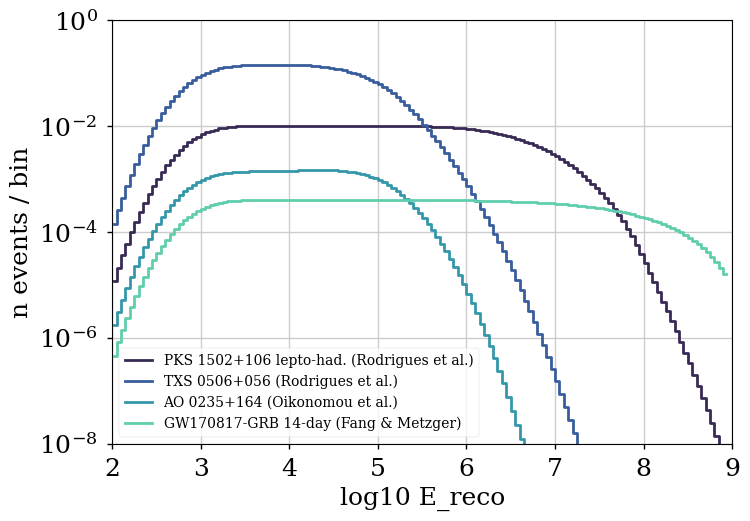

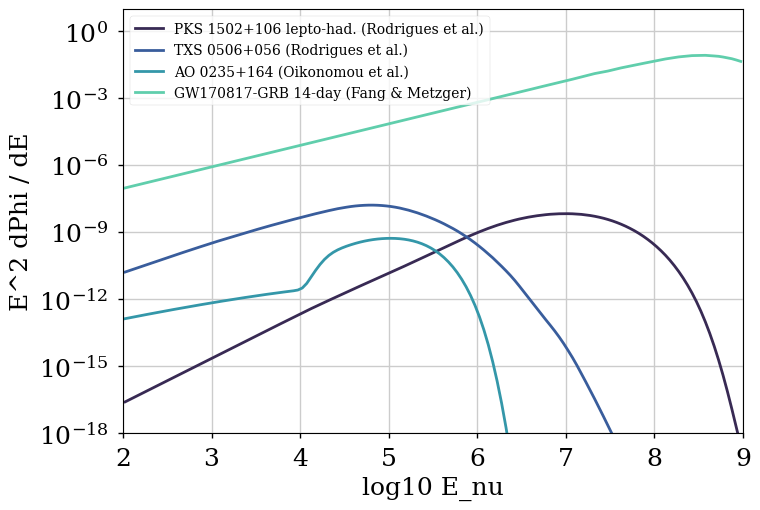

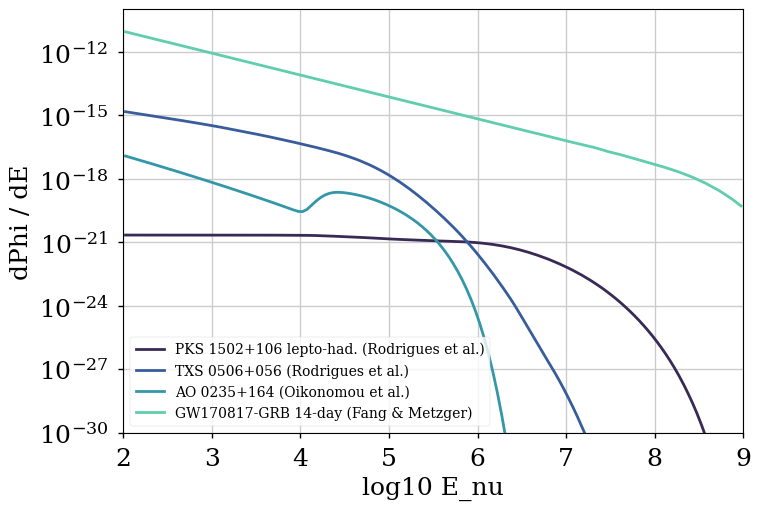

In [31]:
for model_key, dct in selected_models.items():
    series = dct["model"]
    aeff_factor_signal = calc_aeff_factor(
        aeff_2d_full["IceCube"],
        dec=series["dec/rad"],
        livetime=series["livetime/s"] if series.state != "grb" else 1,
        **src_config,
    )

    nev = energy_smearing(
        improved_eres, aeff_factor_signal * 10 ** series["model_spline"](st.logE_mids)
    )
    plt.figure(1)
    plt.plot(st.logE_reco_mids, nev.sum(axis=0), ds="steps-mid", label=model_key)
    plt.figure(2)
    plt.plot(
        st.logE_mids,
        10 ** (series["model_spline"](st.logE_mids) + 2 * st.logE_mids),
        label=model_key,
    )
    plt.figure(3)
    plt.plot(
        st.logE_mids, 10 ** (series["model_spline"](st.logE_mids)), label=model_key
    )

plt.figure(1)
plt.yscale("log")
plt.xlim(2, 9)
plt.ylabel("n events / bin")
plt.xlabel("log10 E_reco")
plt.legend(fontsize="medium")
plt.ylim(1e-8, 1)

plt.figure(2)
plt.yscale("log")
plt.ylabel("E^2 dPhi / dE")
plt.xlabel("log10 E_nu")
plt.legend(fontsize="medium")
plt.ylim(1e-18, 10)
plt.xlim(2, 9)

plt.figure(3)
plt.yscale("log")
plt.ylabel("dPhi / dE")
plt.xlabel("log10 E_nu")
plt.legend(fontsize="medium")
plt.ylim(1e-30, 1E-10)
plt.xlim(2, 9)

In [32]:
if False:    
    sq_deg = np.pi * delta_psi_max**2
    x_evals = np.logspace(0, 9, 100)
    y_scaling = 2

    pl = power_law(x_evals, E0_TXS, GAMMA_TXS, PHI_TXS)
    para_idx = parabola_index(Alpha, Beta, x_evals, E_para_norm)
    para = power_law(x_evals, E_para_norm, para_idx, PHI_lp)

    f, axes = plt.subplots(nrows=3, figsize=(7, 19))
    ax = axes[0]
    fontsize = 20
    ax.set_title("Source flux models", fontsize=fontsize)

    # error contour
    # with energy range interval
    x_cont = np.logspace(np.log10(4e4), np.log10(4e6), 100)
    # without energy range interval
    # x_cont = np.logspace(3, 7, 100)
    c_low = np.zeros_like(x_cont)
    c_high = np.zeros_like(x_cont)
    for ii, xe in enumerate(x_cont):
        tmp = power_law(
            xe, E0_TXS, txs_contour["68\\%"][:,0], txs_contour["68\\%"][:,1] / 1e3 / 2.8
        )  ## fudge factor :)
        c_low[ii] = np.min(tmp)
        c_high[ii] = np.max(tmp)
        
    ax.fill_between(
        x_cont,
        c_low * (x_cont**y_scaling),
        c_high * (x_cont**y_scaling),
        color="k",
        alpha=0.2,
    )

    ax.plot(
        x_evals,
        pl * (x_evals**y_scaling),
        label=rf"PL $\gamma=${GAMMA_TXS}",
        color="k",
        alpha=1,
        lw=3,
    )

    ax.plot(
        x_evals,
        para * (x_evals**y_scaling),
        label=rf"Log-P",
        color="#339999",
        lw=3,
    )
    ax.plot(
        st.emids,
        array_source_interp(
            0, bckg_histo["IceCube"], st.sindec_mids, axis=1
        )
        * sq_deg
        * (st.emids**y_scaling),
        label=r"Atmospheric $\nu_\mu$ background",
        color="gray",
        lw=3,
    )

    ax.set_yscale("log")
    ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)", fontsize=fontsize)
    ax.set_xscale("log")
    ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV", fontsize=fontsize)
    #ax.set_ylim(1e-10, 3e-5)
    ax.set_ylim(1e-11, 3e-8)
    ax.set_xlim(1e3, 1e7)
    f.legend(
        loc="upper center",
        frameon=False,
        bbox_to_anchor=(0.5, 0.93),
    )


    ### plot Event numbers in E_reco
    ii = 0
    evals = st.logE_reco_mids
    ax = axes[1]
    ident = "IceCube"
    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], dec=0, livetime=conservative_livetime, **bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], dec=0, livetime=conservative_livetime, **src_config)

    for eres, e_name in zip([baseline_eres, improved_eres], ["baseline", "improved"]):
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(
                0, bckg_histo["IceCube"], st.sindec_mids, axis=1
            ),
            energy_resolution=eres,
        )

        # power law
        k_s_pl = astro_flux(
            aeff_factor_signal,
            st.emids,
            eres,
            1,
            txs_flux,
        )

        # logP
        k_s_lp = astro_flux(
            aeff_factor_signal,
            st.emids,
            eres,
            1,
            logp_flux,
        )

        ax = axes[1]
        ax.plot(
            evals,
            k_s_pl.sum(axis=0),
            drawstyle="steps-mid",
            label=e_name,
            color="k",
            lw=4 if e_name == "improved" else 2,
            ls="-" if e_name == "improved" else "-.",
        )

        ax.plot(
            evals,
            k_s_lp.sum(axis=0),
            drawstyle="steps-mid",
            color="#339999",
            lw=4 if e_name == "improved" else 2,
            ls="-" if e_name == "improved" else "-.",
        )

        ax.plot(
            evals,
            k_b.sum(axis=0),
            drawstyle="steps-mid",
            color="gray",
            lw=4 if e_name == "improved" else 2,
            ls="-" if e_name == "improved" else "-.",
        )
        print(rf"# source $\nu_\mu$ : {np.sum(k_s_pl):1.1f}")
        print(rf"# atmo. $\nu_\mu$ : {np.sum(k_b):1.1f} (within {sq_deg:1.0f} deg²)")
    ax.set_title(r"$\nu_\mu$ energy expectation", fontsize=fontsize)
    ax.set_yscale("log")
    ax.set_xlim(3, 7)
    ax.set_ylim(1e-3, 3e2)
    ax.set_xlabel(r"$\log_{10}(E_{\mu \, \rm reco}$/GeV)", fontsize=fontsize)
    ax.set_ylabel(r"# $\nu_\mu$ in IceCube", fontsize=fontsize)
    ax.legend(loc=3, bbox_to_anchor=(0.1, 0.0))
    ax.set_xticks([2, 3, 4, 5])

    ax = axes[2]
    ax.plot(
        np.concatenate([[-0.1], psi2_mids]),
        np.concatenate([[0], k_s_pl.sum(axis=1)]),
        drawstyle="steps-mid",
        color="k",
        lw=3,
    )

    ax.plot(
        np.concatenate([[-0.1], psi2_mids]),
        np.concatenate([[0], k_s_lp.sum(axis=1)]),
        drawstyle="steps-mid",
        color="#339999",
        lw=3,
    )

    ax.plot(
        np.concatenate([[-0.1], psi2_mids]),
        np.concatenate([[0], k_b.sum(axis=1)]),
        drawstyle="steps-mid",
        color="gray",
        lw=3,
        zorder=0,
    )

    ax.set_ylabel(r"# $\nu_\mu$ in IceCube", fontsize=fontsize)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 8)
    ax.set_xlabel(r"$\Delta \Psi ^2 / {\rm deg}^2$", fontsize=fontsize)
    ax.set_title(r"$\nu_\mu$ distance expectation", fontsize=fontsize)
    f.subplots_adjust(hspace=0.33, top=0.83)

    # f.savefig(
    #     join(BASEPATH, f"plots/ngc_paper/ngc_spectral_improved_dpsi.pdf"),
    #     bbox_inches="tight",
    # )

(2.0, 9.0)

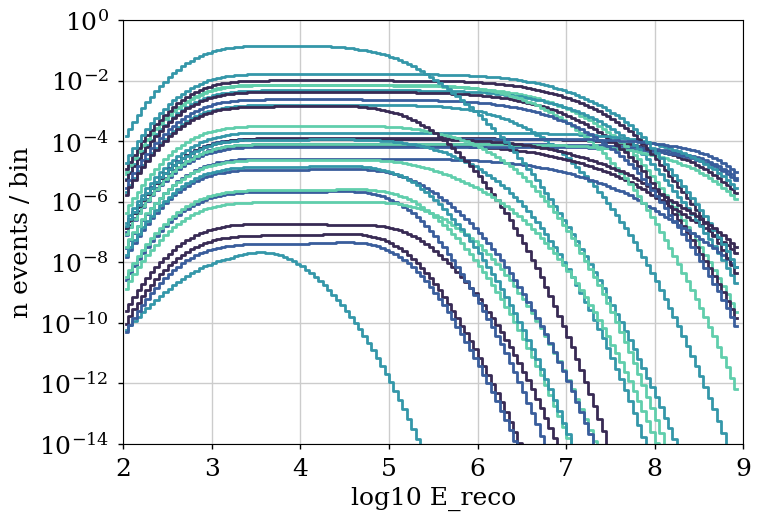

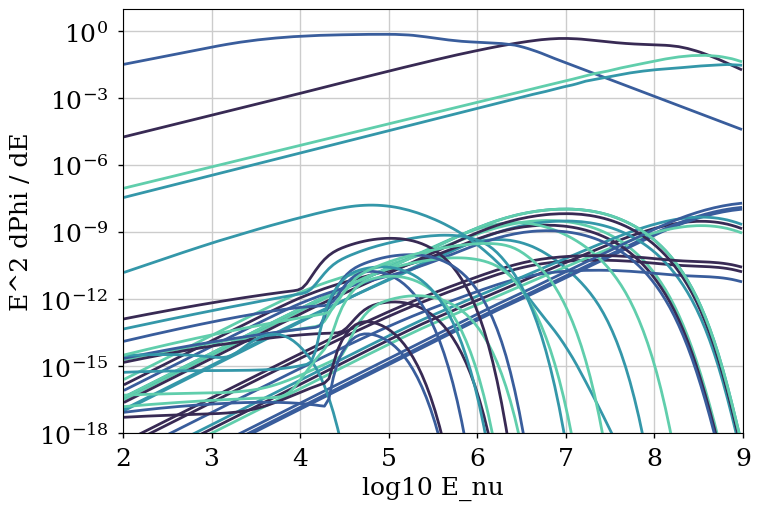

In [33]:
for _, series in all_models.iterrows():
    aeff_factor_signal = calc_aeff_factor(
        aeff_2d["IceCube"],
        dec=series["dec/rad"],
        livetime=series["livetime/s"] if series.state != "grb" else 1,
        **src_config,
    )

    nev = energy_smearing(
        improved_eres, aeff_factor_signal * 10 ** series["model_spline"](st.logE_mids)
    )
    plt.figure(1)
    plt.plot(st.logE_reco_mids, nev.sum(axis=0), ds="steps-mid")
    plt.figure(2)
    plt.plot(
        st.logE_mids,
        10 ** (series["model_spline"](st.logE_mids) + 2 * st.logE_mids),
    )

plt.figure(1)
plt.yscale("log")
plt.xlim(2, 9)
plt.ylabel("n events / bin")
plt.xlabel("log10 E_reco")
plt.ylim(1e-14, 1)

plt.figure(2)
plt.yscale("log")
plt.ylabel("E^2 dPhi / dE")
plt.xlabel("log10 E_nu")
plt.ylim(1e-18, 10)
plt.xlim(2, 9)

# Set up LLH function
$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know



In [34]:
def ps_llh_single(
    x,
    aeff_factor_s,
    aeff_factor_b,
    bckg_flux,
    k_i,
    energy_resolution,
    e_0,
    phi_0,
    shape,
    verbose=False,
):
    """
    Calculate the log-likelihood using Poisson statistics for a single dataset assuming consistent properties.

    Parameters:
        x (list): Fit parameters.
            x[0]: Background normalization scaling.
            x[1]: Signal normalization scaling.
            x[2:]: Other signal parameters. See 'astro_flux' for further shapes and parameters.
        aeff_factor_s (float): Effective area factor for the signal.
        aeff_factor_b (float): Effective area factor for the background.
        bckg_flux (list): Background flux values.
        k_i (array-like): Observation/Asimov data.
        energy_resolution (float): Energy resolution.
        e_0 (float): Normalization energy. Default value is E0_NGC.
        phi_0 (float): Normalization flux. Default value is PHI_NGC.
        shape (str): Flux shape.
        verbose (bool, optional): Whether to print additional information. Default is False.

    Returns:
        float: -2 * Log-likelihood value calculated using Poisson statistics. See 'poisson_llh'.

    Note:
        This function assumes that there is only one dataset with consistent properties.
    """
    # Calculate the background contribution
    mu_b = (
        atmo_background(
            aeff_factor=aeff_factor_b,
            bckg_vals=bckg_flux,
            energy_resolution=energy_resolution,
        )
        * x[0]
    )
    # Calculate the signal contribution
    mu_s = astro_flux(
        aeff_factor_s,
        st.emids,
        energy_resolution,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        # Print additional information if verbose mode is enabled
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))

    # Calculate the total expected events for the Poisson LLH
    mu_i = mu_s + mu_b

    # Calculate -2 * log-likelihood using Poisson statistics
    return poisson_llh(mu_i, k_i)


def ps_llh_multi(
    x,
    all_aeff_factor_s,
    all_aeff_factor_b,
    all_bckg_flux,
    all_k,
    all_eres,
    shape,
    e_0,
    phi_0,
):
    """
    Calculate the total log-likelihood across multiple datasets with different properties.

    Parameters:
        x (list): Fit parameters.
        all_aeff_factor_s (list): List of effective area factors for the signal for each dataset.
        all_aeff_factor_b (list): List of effective area factors for the background for each dataset.
        all_bckg_flux (list): List of background flux values for each dataset.
        all_k (list): List of observation/Asimov data for each dataset.
        all_eres (list): List of energy resolutions for each dataset.
        shape (str): Flux shape.
        e_0 (float): Normalization energy.
        phi_0 (float): Normalization flux.

    Returns:
        float: Total log-likelihood value across all datasets.

    Note:
        This function assumes that there are multiple datasets with different properties.
    """
    llh = 0
    for i, aeffs in enumerate(all_aeff_factor_s):
        llh += ps_llh_single(
            x=x,
            aeff_factor_s=aeffs,
            aeff_factor_b=all_aeff_factor_b[i],
            bckg_flux=all_bckg_flux[i],
            k_i=all_k[i],
            energy_resolution=all_eres[i],
            e_0=e_0,
            phi_0=phi_0,
            shape=shape,
        )
    return llh

def setup_multi_llh(eres, conf, bg_config, sig_config, src_flux, verbose=False, return_s_b=False):
    """
    Set up the components required for calculating the log-likelihood across multiple datasets.

    Parameters:
        eres (dict or array): Dictionary of arrays/mephistograms or single array/mephistogram representing the
                                  energy resolutions for each dataset. If a dictionary is provided,
                                  it should map dataset identifiers to their corresponding energy resolution.
                                  If a float is provided, the same energy resolution will be used for all datasets.
        conf (tuple): Tuple containing two lists - the first list represents dataset identifiers,
                      and the second list contains corresponding scaling factors corresponding to
                      either a lifetime scaling or effective-area scaling.
        verbose (bool, optional): Whether to print additional information. Default is False.
        return_s_b (bool, optional): Whether to return the individual signal and background histograms. Default is False.

    Returns:
        tuple: A tuple containing the following components for each dataset:
            - all_aeff_factor_s (list): List of effective area factors for the signal.
            - all_aeff_factor_b (list): List of effective area factors for the background.
            - all_k (list): List of observation/Asimov data.
            - all_bckg_flux (list): List of background flux values.
            - if return_s_b: all_k_s, all_k_b (lists): List of signal and background histograms

    Note:
        This function assumes that the configuration parameters and required functions (e.g., `calc_aeff_factor`,
        `atmo_background`, `astro_flux`, `array_source_interp`) are defined and accessible in the global namespace.
        If `eres` is a dictionary, each dataset identifier should have an associated energy resolution value.
        If `eres` is an  array/mephistogram, the same energy resolution will be used for all datasets.
    """

    all_aeff_factor_s = []
    all_aeff_factor_b = []
    all_k = []
    all_bckg_flux = []
    all_eres = []
    if return_s_b:
        all_k_s = []
        all_k_b = []

    for ident, factor in zip(*conf):
        # Calculate effective area factors for background and signal
        aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **bg_config) * factor
        aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **sig_config) * factor

        # Calculate background flux
        bckg_flux = array_source_interp(
            bg_config["dec"], bckg_histo[ident], st.sindec_mids, axis=1
        )
        # Determine the energy resolution for the current dataset
        current_eres = eres[ident] if isinstance(all_eres, dict) else eres

        # Calculate asimov data for atmospheric background
        k_b = atmo_background(
            aeff_factor=aeff_factor_bckg,
            bckg_vals=bckg_flux,
            energy_resolution=current_eres,
        )

        # Calculate asimov data for astrophysical signal 
        k_s = astro_flux(
            aeff_factor=aeff_factor_signal,
            emids=st.emids,
            energy_resolution=current_eres,
            phi_scaling=1,
            flux_shape=src_flux,  # spectral shape
        )

        if verbose:
            print("Asimov data sum:")
            print("Background:", np.sum(k_b))
            print("Signal:", np.sum(k_s))

        all_aeff_factor_s.append(aeff_factor_signal)
        all_aeff_factor_b.append(aeff_factor_bckg)
        all_k.append(k_s + k_b)
        all_bckg_flux.append(bckg_flux)
        all_eres.append(current_eres)
        if return_s_b:
            all_k_s.append(k_s)
            all_k_b.append(k_b)
    if return_s_b:
        return (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
            all_k_b,
            all_k_s,
        )
    else:
        return all_aeff_factor_s, all_aeff_factor_b, all_k, all_bckg_flux, all_eres

# Model tests

In [35]:
def model_llh_single(x, mu_s, mu_b, k_i):
    # Calculate the total expected events for the Poisson LLH
    mu_i = x[0] * mu_b + x[1] * mu_s

    # Calculate -2 * log-likelihood using Poisson statistics
    return poisson_llh(mu_i, k_i)


def model_llh_multi(x, all_mu_s, all_mu_b, all_k):
    llh = 0
    for mu_s, mu_b, k_i in zip(all_mu_s, all_mu_b, all_k):
        llh += model_llh_single(x, mu_s, mu_b, k_i)
    return llh


def setup_multi_model_llh(
    eres, conf, bg_config, sig_config, model_spline, aeff_2d=aeff_2d, verbose=False
):
    all_mu_s = []
    all_mu_b = []
    all_k = []

    for ident, factor in zip(*conf):
        # Calculate effective area factors for background and signal
        aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **bg_config) * factor
        aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **sig_config) * factor

        # Calculate background flux
        bckg_flux = array_source_interp(
            bg_config["dec"], bckg_histo[ident], st.sindec_mids, axis=1
        )
        # Determine the energy resolution for the current dataset
        current_eres = eres[ident] if isinstance(eres, dict) else eres

        # Calculate asimov data for atmospheric background
        k_b = atmo_background(
            aeff_factor=aeff_factor_bckg,
            bckg_vals=bckg_flux,
            energy_resolution=current_eres,
        )

        # Calculate asimov data for astrophysical signal
        assert np.all(aeff_factor_signal.bin_mids[1] == st.logE_mids)

        k_s = energy_smearing(
            current_eres, aeff_factor_signal * 10 ** model_spline(st.logE_mids)
        )

        if verbose:
            print("Asimov data sum:")
            print("Background:", np.sum(k_b))
            print("Signal:", np.sum(k_s))

        all_mu_s.append(k_s)
        all_mu_b.append(k_b)
        all_k.append(k_s + k_b)
    return all_mu_s, all_mu_b, all_k

## single source flare

### GRB models

In [36]:
key = "Plenum-2"
verbose = False

for key in ["IceCube", "Plenum-1", "Plenum-2"]:
    for _, series in grb_models.iterrows():
        
        current_dec = gw_170817.dec.rad

        # setup config
        conf = detector_configurations[key]
        current_bg_config = deepcopy(bg_config)
        current_bg_config["livetime"] = series["livetime/s"]
        current_bg_config["dec"] = current_dec

        current_src_config = deepcopy(src_config)
        current_src_config["livetime"] = 1
        current_src_config["dec"] = current_dec

        all_mu_s, all_mu_b, all_k = setup_multi_model_llh(
            improved_eres,
            conf,
            bg_config=current_bg_config,
            sig_config=current_src_config,
            model_spline=series["model_spline"],
            verbose=verbose,
        )


        local_llh = lambda x: model_llh_multi((x[0], 0), all_mu_s, all_mu_b, all_k )
        global_llh = lambda x: model_llh_multi(x, all_mu_s, all_mu_b, all_k )

        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1,),
            approx_grad=True,
        )
        

        # this fit is not really needed, but good for crosschecking the minimization
        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1),
            approx_grad=True,
        )

        pval = chi2.sf(out_bckg[1] - out_comp[1], 1) # atmo(n) vs atmo(n) + signal(n) = 1 ndof
        significance = norm.isf(pval/2)

        if True: #significance > 0:
            print(key)
            print(series["model_name"])
            print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        if False:
            print()
            print("Signal:", np.sum(all_mu_s))
            print("Background:", np.sum(all_mu_b))
            print("Atmo-only normalization:", out_bckg[0])
            print("Signal fit parameters:", out_comp[0])
            print("TS check:", global_llh((1, 1)), "(fit: ", out_comp[1], ")")
            print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
            print(" - " * 3)
    print()

IceCube
1000s moderate 0deg
P-VALUE: 1.0 SIGNIFICANCE: 0.0
IceCube
1000s optimistic 4deg
P-VALUE: 1.0 SIGNIFICANCE: 0.0
IceCube
3d
P-VALUE: 1.0 SIGNIFICANCE: 0.0
IceCube
14d
P-VALUE: 1.0 SIGNIFICANCE: 0.0

Plenum-1
1000s moderate 0deg
P-VALUE: 3.609686925599543e-11 SIGNIFICANCE: 6.619273404679488
Plenum-1
1000s optimistic 4deg
P-VALUE: 7.679582103052364e-74 SIGNIFICANCE: 18.178212946868673
Plenum-1
3d
P-VALUE: 0.6040551959141391 SIGNIFICANCE: 0.5185777965252845
Plenum-1
14d
P-VALUE: 0.46194220397442 SIGNIFICANCE: 0.7356524996286072



Plenum-2
1000s moderate 0deg
P-VALUE: 3.609686925599543e-11 SIGNIFICANCE: 6.619273404679488
Plenum-2
1000s optimistic 4deg
P-VALUE: 7.679582103052364e-74 SIGNIFICANCE: 18.178212946868673
Plenum-2
3d
P-VALUE: 0.6040551959141391 SIGNIFICANCE: 0.5185777965252845
Plenum-2
14d
P-VALUE: 0.46194220397442 SIGNIFICANCE: 0.7356524996286072



### Foteini's models

In [37]:
key = "Plenum-2"
verbose = False
for ii, series in blazar_models.iterrows():
    
    # setup config
    conf = detector_configurations[key]
    current_bg_config = deepcopy(bg_config)
    current_bg_config["livetime"] = series["livetime/s"]
    current_bg_config["dec"] = series["dec/rad"]

    current_src_config = deepcopy(src_config)
    current_src_config["livetime"] = series["livetime/s"]
    current_src_config["dec"] = series["dec/rad"]

    all_mu_s, all_mu_b, all_k = setup_multi_model_llh(
        improved_eres,
        conf,
        bg_config=current_bg_config,
        sig_config=current_src_config,
        model_spline=series["model_spline"],
        verbose=verbose,
    )


    local_llh = lambda x: model_llh_multi((x[0], 0), all_mu_s, all_mu_b, all_k )
    global_llh = lambda x: model_llh_multi(x, all_mu_s, all_mu_b, all_k )

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    

    # this fit is not really needed, but good for crosschecking the minimization
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1),
        approx_grad=True,
    )

    pval = chi2.sf(out_bckg[1] - out_comp[1], 1) # atmo(n) vs atmo(n) + signal(n) = 1 ndof
    significance = norm.isf(pval/2)

    if significance > 0:
        print(key)
        print(series.model_name)
        print()
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        print()
        print("Signal:", np.sum(all_mu_s))
        print("Background:", np.sum(all_mu_b))
        print("Atmo-only normalization:", out_bckg[0])
        print("Signal fit parameters:", out_comp[0])
        print("TS check:", global_llh((1, 1)), "(fit: ", out_comp[1], ")")
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
        print(" - " * 3)

Plenum-2
TXS 0506+056

P-VALUE: 0.7295167811752723 SIGNIFICANCE: 0.34576839198648146

Signal: 0.15112938984077623
Background: 257.62791900781673
Atmo-only normalization: [1.00072493]
Signal fit parameters: [1. 1.]
TS check: -740894.4124768856 (fit:  -740894.4124768856 )
-2 Delta LLH: 0.11955578089691699
 -  -  - 
Plenum-2
3C66A

P-VALUE: 0.9992927632980685 SIGNIFICANCE: 0.0008863898730299745

Signal: 6.898612281738527e-05
Background: 9.573600983407735
Atmo-only normalization: [1.]
Signal fit parameters: [1. 1.]
TS check: -714556.70468665 (fit:  -714556.70468665 )
-2 Delta LLH: 7.856870070099831e-07
 -  -  - 
Plenum-2
BLLAC

P-VALUE: 0.9934288765449562 SIGNIFICANCE: 0.008235775025982758

Signal: 0.0007575279432071517
Background: 4.8338453192853335
Atmo-only normalization: [1.00014319]
Signal fit parameters: [1. 1.]
TS check: -740639.3950658088 (fit:  -740639.3950658088 )
-2 Delta LLH: 6.782799027860165e-05
 -  -  - 


Plenum-2
OJ287

P-VALUE: 0.7451582299575794 SIGNIFICANCE: 0.32503018056395616

Signal: 0.0529527745919509
Background: 7.426421888815335
Atmo-only normalization: [1.00835278]
Signal fit parameters: [1. 1.]
TS check: -915690.0384495464 (fit:  -915690.0384495464 )
-2 Delta LLH: 0.10564461827743798
 -  -  - 
Plenum-2
PG 1553 113

P-VALUE: 0.997229868166477 SIGNIFICANCE: 0.0034718523639813725

Signal: 0.0004357393531035064
Background: 39.022440031561835
Atmo-only normalization: [1.00001831]
Signal fit parameters: [1. 1.]
TS check: -864412.1529118007 (fit:  -864412.1529118007 )
-2 Delta LLH: 1.2053758837282658e-05
 -  -  - 
Plenum-2
AO 0235+164

P-VALUE: 0.44957137505966116 SIGNIFICANCE: 0.7561298026447569

Signal: 0.5759276110269004
Background: 96.1315818119664
Atmo-only normalization: [1.005926]
Signal fit parameters: [1. 1.]
TS check: -804190.264536879 (fit:  -804190.264536879 )
-2 Delta LLH: 0.5717322784475982
 -  -  - 
Plenum-2
S5 0716+714

P-VALUE: 0.9605438645639737 SIGNIFICANCE: 0.04

### Xavier's models

In [38]:
key = "Plenum-2"
verbose = False
for model_name, series in flare_models_x.iterrows():
    if series["bf_or_band"] != "bestfit":
        continue

    # setup config
    conf = detector_configurations[key]
    current_bg_config = deepcopy(bg_config)
    current_bg_config["livetime"] = series["livetime/s"]
    current_bg_config["dec"] = series["dec/rad"]

    current_src_config = deepcopy(src_config)
    current_src_config["livetime"] = series["livetime/s"]
    current_src_config["dec"] = series["dec/rad"]

    all_mu_s, all_mu_b, all_k = setup_multi_model_llh(
        improved_eres,
        conf,
        bg_config=current_bg_config,
        sig_config=current_src_config,
        model_spline=series["model_spline"],
        verbose=verbose,
    )

    local_llh = lambda x: model_llh_multi((x[0], 0), all_mu_s, all_mu_b, all_k)
    global_llh = lambda x: model_llh_multi(x, all_mu_s, all_mu_b, all_k)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )

    # this fit is not really needed, but good for crosschecking the minimization
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1),
        approx_grad=True,
    )

    pval = chi2.sf(
        out_bckg[1] - out_comp[1], 1
    )  # atmo(n) vs atmo(n) + signal(n) = 1 ndof
    significance = norm.isf(pval/2)

    if significance > 0:
        print(key)
        print(series.model_name, series.src_name, series.state)
        print()

        print("Signal:", np.sum(all_mu_s))
        print("Background:", np.sum(all_mu_b))
        print("Atmo-only normalization:", out_bckg[0])
        print("Signal fit parameters:", out_comp[0])
        print("TS check:", global_llh((1, 1)), "(fit: ", out_comp[1], ")")
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
        print()
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        print()
        print(" = " * 10)
        print()

Plenum-2
proton-synchrotron pks softflare

Signal: 0.11711797934515987
Background: 483.3061777008195
Atmo-only normalization: [1.00028634]
Signal fit parameters: [1. 1.]
TS check: -514305.56400774093 (fit:  -514305.56400774093 )
-2 Delta LLH: 0.8894273771438748

P-VALUE: 0.34563253043035513 SIGNIFICANCE: 0.9430945748671627

 =  =  =  =  =  =  =  =  =  = 

Plenum-2
proton-synchrotron pks hardflare

Signal: 0.0921074301467089
Background: 483.3061777008195
Atmo-only normalization: [1.00022907]
Signal fit parameters: [1. 1.]
TS check: -508286.1266894667 (fit:  -508286.1266894667 )
-2 Delta LLH: 0.8398908455274068

P-VALUE: 0.35942799091671096 SIGNIFICANCE: 0.9164555884097203

 =  =  =  =  =  =  =  =  =  = 

Plenum-2
lepto-hadronic pks quiescent

Signal: 0.8777609370925956
Background: 483.3061777008195
Atmo-only normalization: [1.00182216]
Signal fit parameters: [1. 1.]
TS check: -649097.1160696947 (fit:  -649097.1160696947 )
-2 Delta LLH: 2.359873488545418

P-VALUE: 0.12449228486660778 SIG

### all objects

In [39]:
key = "Plenum-2"
verbose = False
for model_name, series in all_models.iterrows():
    if series["bf_or_band"] != "bestfit":
        continue

    # setup config
    conf = detector_configurations[key]
    current_bg_config = deepcopy(bg_config)
    current_bg_config["livetime"] = series["livetime/s"]
    current_bg_config["dec"] = series["dec/rad"]

    current_src_config = deepcopy(src_config)
    current_src_config["livetime"] = (
        series["livetime/s"] if series.state != "grb" else 1
    )  # GRB uses Fluence already
    current_src_config["dec"] = series["dec/rad"]

    all_mu_s, all_mu_b, all_k = setup_multi_model_llh(
        improved_eres,
        conf,
        bg_config=current_bg_config,
        sig_config=current_src_config,
        model_spline=series["model_spline"],
        verbose=verbose,
    )

    local_llh = lambda x: model_llh_multi((x[0], 0), all_mu_s, all_mu_b, all_k)
    global_llh = lambda x: model_llh_multi(x, all_mu_s, all_mu_b, all_k)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )

    # this fit is not really needed, but good for crosschecking the minimization
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1),
        approx_grad=True,
    )

    pval = chi2.sf(
        out_bckg[1] - out_comp[1], 1
    )  # atmo(n) vs atmo(n) + signal(n) = 1 ndof
    significance = norm.isf(pval/2)

    if True:  # significance > 0:
        print(key)
        print(series.model_name, series.src_name, series.state)
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        print("Signal:", np.sum(all_mu_s))
        print("Background:", np.sum(all_mu_b))
    if False:
        print("Atmo-only normalization:", out_bckg[0])
        print("Signal fit parameters:", out_comp[0])
        print("TS check:", global_llh((1, 1)), "(fit: ", out_comp[1], ")")
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
        print()
        print()
        print(" = " * 10)
    print()

Plenum-2
1000s moderate 0deg GW170817 grb
P-VALUE: 3.609686925599543e-11 SIGNIFICANCE: 6.619273404679488
Signal: 3.392154588279471
Background: 0.0030495023493202246

Plenum-2
1000s optimistic 4deg GW170817 grb
P-VALUE: 7.679582103052364e-74 SIGNIFICANCE: 18.178212946868673
Signal: 56.1554177110574
Background: 0.0030495023493202246



Plenum-2
3d GW170817 grb
P-VALUE: 0.6040551959141391 SIGNIFICANCE: 0.5185777965252845
Signal: 0.024079732962062783
Background: 0.7904310089438022

Plenum-2
14d GW170817 grb
P-VALUE: 0.46194220397442 SIGNIFICANCE: 0.7356524996286072
Signal: 0.05064249874136953
Background: 3.688678041737744

Plenum-2
proton-synchrotron pks softflare
P-VALUE: 0.34563253043035513 SIGNIFICANCE: 0.9430945748671627
Signal: 0.11711797934515987
Background: 483.3061777008195

Plenum-2
proton-synchrotron pks hardflare
P-VALUE: 0.35942799091671096 SIGNIFICANCE: 0.9164555884097203
Signal: 0.0921074301467089
Background: 483.3061777008195

Plenum-2
lepto-hadronic pks quiescent
P-VALUE: 0.12449228486660778 SIGNIFICANCE: 1.5361879730506334
Signal: 0.8777609370925956
Background: 483.3061777008195

Plenum-2
proton-synchrotron pks quiescent
P-VALUE: 0.708301716900215 SIGNIFICANCE: 0.37413790790001805
Signal: 0.049360933691240866
Background: 483.3061777008195

Plenum-2
lepto-hadronic pks softflare
P-VALUE: 0.00036935783324

# Stacking

## Foteini Blazar model

In [40]:
# index of energy treshold = 100 TeV
key = "Plenum-2"
verbose = False

stacked_mu_s = []
stacked_mu_b = []
stacked_k = []

for ii, series in blazar_models.iterrows():
    
    # setup config
    conf = detector_configurations[key]
    current_bg_config = deepcopy(bg_config)
    current_bg_config["livetime"] = series["livetime/s"]
    current_bg_config["dec"] = series["dec/rad"]

    current_src_config = deepcopy(src_config)
    current_src_config["livetime"] = series["livetime/s"]
    current_src_config["dec"] = series["dec/rad"]

    all_mu_s, all_mu_b, all_k = setup_multi_model_llh(
        improved_eres,
        conf,
        bg_config=current_bg_config,
        sig_config=current_src_config,
        model_spline=series["model_spline"],
        verbose=verbose,
    )

    stacked_k.extend(all_k)
    stacked_mu_b.extend(all_mu_b)
    stacked_mu_s.extend(all_mu_s)

local_llh = lambda x: model_llh_multi((x[0], 0), stacked_mu_s, stacked_mu_b, stacked_k)
global_llh = lambda x: model_llh_multi(x, stacked_mu_s, stacked_mu_b, stacked_k)

out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1,),
    approx_grad=True,
)


# this fit is not really needed, but good for crosschecking the minimization
out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1, 1),
    approx_grad=True,
)

pval = chi2.sf(
    out_bckg[1] - out_comp[1], 1
)  # atmo(n) vs atmo(n) + signal(n) = 1 ndof
significance = norm.isf(pval/2)

if True:  # significance > 0:
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print("Signal:", np.sum(stacked_mu_s))
    print("Background:", np.sum(stacked_mu_b))
    print("Atmo-only normalization:", out_bckg[0])
    print("Signal fit parameters:", out_comp[0])

    print(
        "TS check:",
        global_llh((1, 1)),
        "(fit: ",
        out_comp[1],
        ")",
        "(bckg: ",
        out_bckg[1],
        ")",
    )
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    print(" - " * 3)

P-VALUE: 0.3667021401887339 SIGNIFICANCE: 0.9026679709510329
Signal: 0.8016861131911239
Background: 622.3876252467517
Atmo-only normalization: [1.00142378]
Signal fit parameters: [1. 1.]
TS check: -9712482.435766423 (fit:  -9712482.435766423 ) (bckg:  -9712481.620956957 )
-2 Delta LLH: 0.8148094657808542
 -  -  - 


# Declination DP

## selected models

In [41]:
thresholds = [st.sigma5, st.sigma3]
verbose = False
detector_keys = [
    "IceCube",
    # "P-ONE" ,
    "Plenum-1",
    "Plenum-2",
]
decs = np.rad2deg(np.arcsin(np.linspace(-1, 1, 41)))
tmp = []
optimize=False
for current_dec, ident, (model_key, dct) in tqdm(product(
    np.deg2rad(decs), detector_keys, selected_models.items()
)):
    if current_dec < np.deg2rad(-5) and ident=="IceCube":
        continue
    series = dct["model"]
    # setup config
    conf = detector_configurations[ident]
    current_bg_config = deepcopy(bg_config)
    current_bg_config["livetime"] = series["livetime/s"]
    current_bg_config["dec"] = current_dec
    current_src_config = deepcopy(src_config)
    current_src_config["livetime"] = (
        series["livetime/s"] if series.state != "grb" else 1
    )  # GRB uses Fluence already
    current_src_config["dec"] = current_dec

    all_mu_s, all_mu_b, all_k = setup_multi_model_llh(
        improved_eres,
        conf,
        bg_config=current_bg_config,
        sig_config=current_src_config,
        model_spline=series["model_spline"],
        verbose=verbose,
        aeff_2d=aeff_2d_full
    )
    if False:
        for ms in all_mu_s:
            ms.plot(norm=LogNorm(vmin=np.max(ms)*1E-2))
            plt.gca().set_title(f"{current_dec}, {ident}, {model_key}")

    scaler = dct["start_scaler"] / np.sum(all_mu_s) 
    current_thresholds = copy(thresholds)
    count = 0

    # calculate the significance with various flux scalings to obtain
    # the 5-sigma discovery threshold by interpolation
    while len(current_thresholds) > 0:
        current_mu_s = [mus * scaler for mus in all_mu_s]
        current_k_i = [ks + kb for ks, kb in zip(current_mu_s, all_mu_b)]

        local_llh = lambda x: model_llh_multi(
            (x[0], 0), current_mu_s, all_mu_b, current_k_i
        )
        global_llh = lambda x: model_llh_multi(x, current_mu_s, all_mu_b, current_k_i)

        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1,),
            bounds=[(0.1, 20),],
            approx_grad=True,
        )
        if optimize:
            # this fit is not really needed, but good for crosschecking the minimization
            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1, 1),
                approx_grad=True,
            )

            pval = chi2.sf(
                out_bckg[1] - out_comp[1], 1
            )  # atmo(n) vs atmo(n) + signal(n) = 1 ndof
        else:
            pval = chi2.sf(
                out_bckg[1] - global_llh((1, 1)), 1
            )
        significance = norm.isf(pval/2)
        tmp_dct = {
            "ident": ident,
            "fancy_label": st.poles[ident]["label"],
            "model": model_key,
            "livetime": int(series["livetime/s"] / 24 / 3600),
            "dec": current_dec,
            "scaler": scaler,
            "cur_thresh": current_thresholds[0],
            "SosB": np.sum(current_mu_s) / np.sqrt(np.sum(all_mu_b)),
            "SoB": np.sum(current_mu_s) / np.sum(all_mu_b),
            "n_b": np.sum(all_mu_b),
            "n_sig": np.sum(current_mu_s),
            "p": pval,
            "log10(p)": -np.log10(
                pval
            ),
        }
        if np.isnan(tmp_dct["p"]) and optimize: 
            print(out_bckg[1], out_comp[1], out_bckg[1] - out_comp[1], tmp_dct["p"])
            raise ValueError(">:O")
        tmp.append(tmp_dct)
        tmp_df = pd.DataFrame(tmp)
        mask = (
            (tmp_df.dec == current_dec)
            & (tmp_df.ident == ident)
            & (tmp_df.model == model_key)
            & (tmp_df.cur_thresh == current_thresholds[0])
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask], current_thresholds, scaler, stop_here=1, stepper=1.3, min_steps=3, nmax=10
        )

        if scaler == -1:
            break
    if False:  # significance > 0:
        print(key, current_dec, series.model_name, series.src_name, series.state)
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        print("Signal:", np.sum(all_mu_s))
        print("Background:", np.sum(all_mu_b))
    if False:
        print("Atmo-only normalization:", out_bckg[0])
        print("Signal fit parameters:", out_comp[0])
        print("TS check:", global_llh((1, 1)), "(fit: ", out_comp[1], ")")
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
        print()
        print()
        print(" = " * 10)
        print()
df = pd.DataFrame(tmp)
df.to_pickle(join(st.LOCALPATH, "transient_discPot_selected.pickle"))

0it [00:00, ?it/s]

492it [01:30,  5.43it/s]


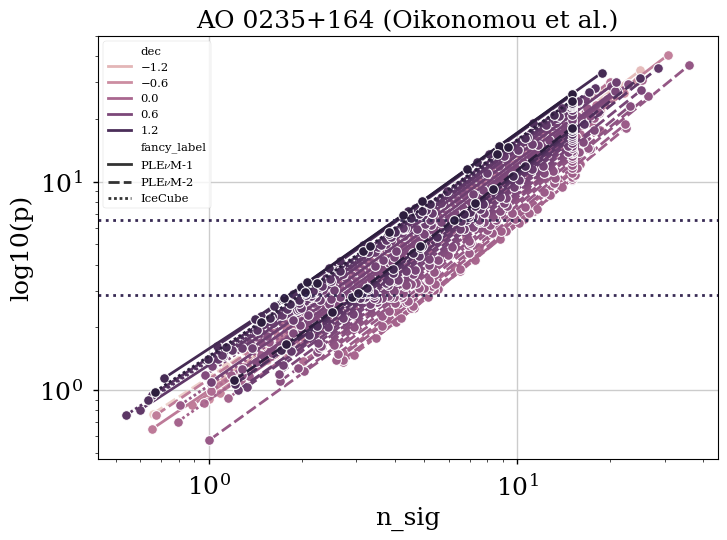

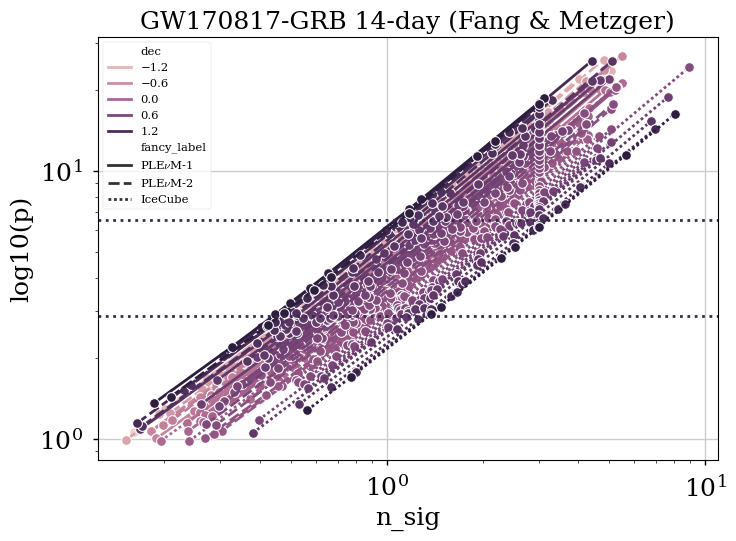

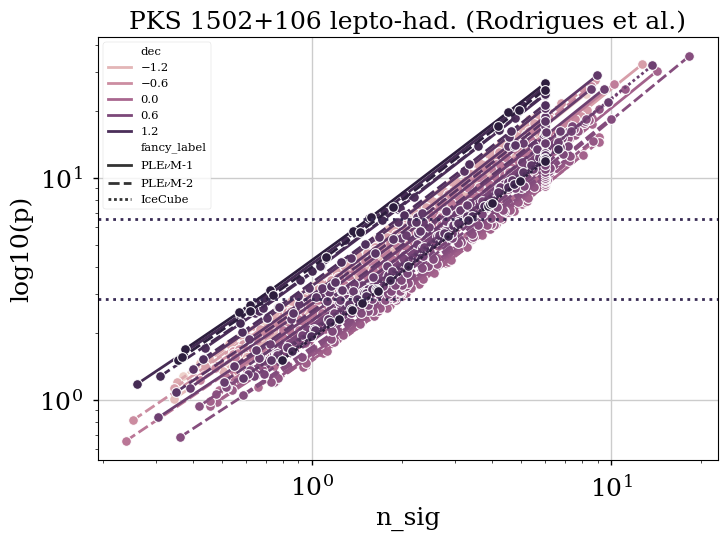

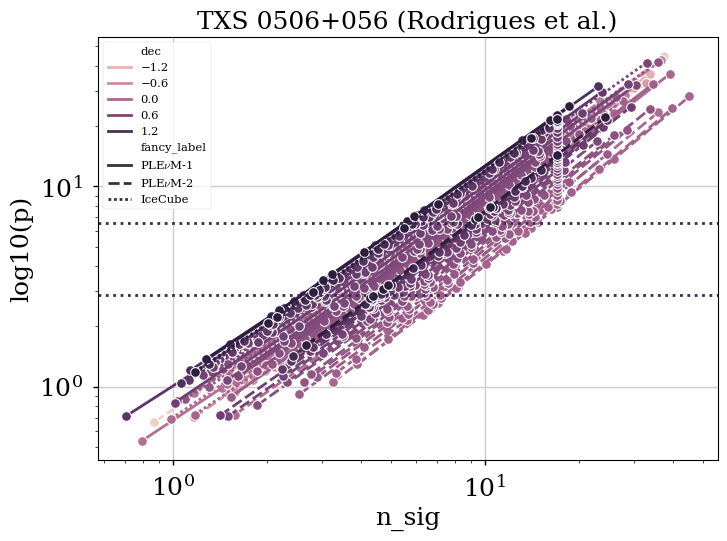

In [42]:
xname = "n_sig" #"scaler" # "SoB" # "SosB" # 
for i, gb in df.groupby("model"):
    f, ax = plt.subplots()
    ax = sns.lineplot(
        data=gb, ax=ax,
        #data=tmp_df.loc[mask], 
        y="log10(p)", x=xname, marker="o", hue="dec", style="fancy_label", #, size="ident", style="model"
    )
    for t in thresholds:
        plt.axhline(-np.log10(t), ls=":")
    plt.legend(fontsize="small")
    ax.loglog()
    ax.set_title(i)

### 5 sigma DP

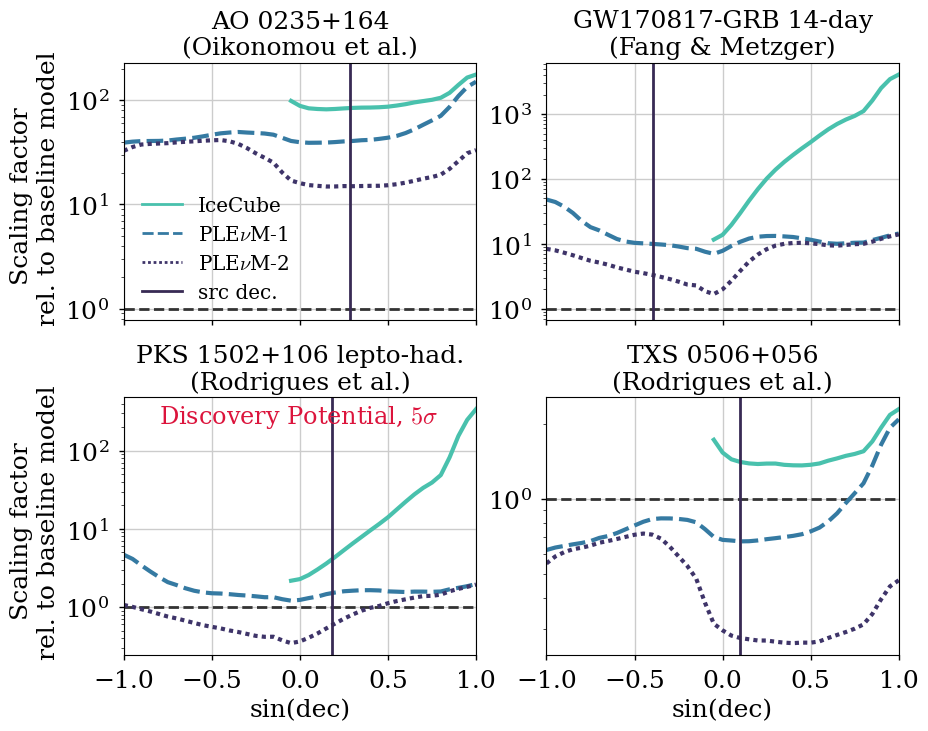

In [43]:

df = pd.read_pickle(join(st.LOCALPATH, "transient_discPot_selected.pickle"))
key_y = "scaler"
flux = pd.DataFrame(
    df.groupby(["fancy_label", "model", "dec", "livetime"]).apply(
        lambda x: get_scaler(x, st.sigma5, key_y=key_y)
    ),
    columns=[key_y],
).reset_index()

flux["sin(dec)"] = np.sin(flux.dec)

f, axes = plt.subplots(figsize=(10, 8), nrows=2, ncols=2, sharex=True)
axes = axes.flatten()
for ii, (model, gb) in enumerate(flux.groupby("model")):
    ax = axes[ii]
    sns.lineplot(
        gb,
        x="sin(dec)",
        y=key_y,
        style="fancy_label",
        hue="fancy_label",
        lw="3",
        palette="mako_r",
        ax=ax, 
    )
    ax.axvline(np.sin(selected_models[model]["model"]["dec/rad"]), label="src dec.")
    ax.set_yscale("log")
    ax.axhline(1, ls="--", lw=2, color="0.2", zorder=1)
    ax.axes.legend_.remove()
    if ii % 2 == 0:
        ax.set_ylabel("Scaling factor \n rel. to baseline model")
    else:
        ax.set_ylabel("")
    if ii == 0:
        ax.legend(
            loc=0,  # "upper left",
            frameon=False,
            fontsize="x-large",
            ncol=1,
            # bbox_to_anchor=(0.5, 0.93),
            columnspacing=0.8,
        )
    ax.set_title(model.replace(" (", "\n("))
    ax.set_xlim(-1, 1)
f.subplots_adjust(top=0.85, hspace=0.3)
axes[2].text(
    0.1,
    0.9,
    "Discovery Potential, $5\sigma$",
    fontsize="xx-large",
    color="crimson",
    transform=axes[2].transAxes,
)
f.savefig(
    join(st.BASEPATH, "plots/icrc2023/DP5_declination_selected_sources.pdf"), bbox_inches="tight"
)

### 3 sigma DP

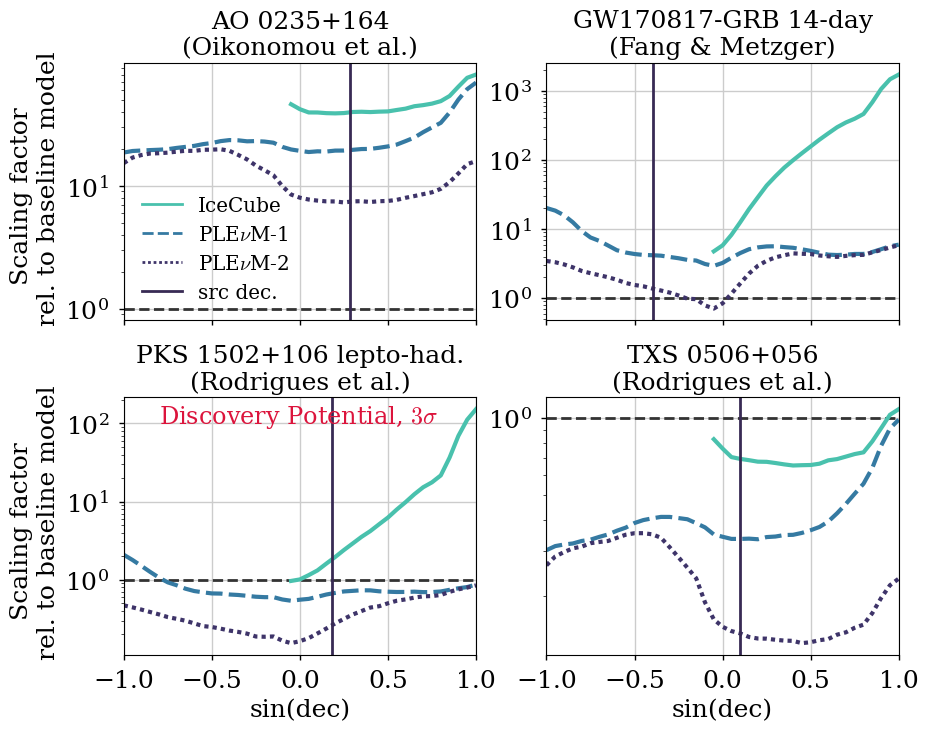

In [44]:
df = pd.read_pickle(join(st.LOCALPATH, "transient_discPot_selected.pickle"))
key_y = "scaler"
flux = pd.DataFrame(
    df.groupby(["fancy_label", "model", "dec", "livetime"]).apply(
        lambda x: get_scaler(x, st.sigma3, key_y=key_y)
    ),
    columns=[key_y],
).reset_index()

flux["sin(dec)"] = np.sin(flux.dec)

f, axes = plt.subplots(figsize=(10, 8), nrows=2, ncols=2, sharex=True)
axes = axes.flatten()
for ii, (model, gb) in enumerate(flux.groupby("model")):
    ax = axes[ii]
    sns.lineplot(
        gb,
        x="sin(dec)",
        y=key_y,
        style="fancy_label",
        hue="fancy_label",
        lw="3",
        palette="mako_r",
        ax=ax,
    )

    ax.axvline(np.sin(selected_models[model]["model"]["dec/rad"]), label="src dec.")
    ax.set_yscale("log")
    ax.axhline(1, ls="--", lw=2, color="0.2", zorder=1)
    ax.axes.legend_.remove()
    if ii % 2 == 0:
        ax.set_ylabel("Scaling factor \n rel. to baseline model")
    else:
        ax.set_ylabel("")
    if ii == 0:
        ax.legend(
            loc=0,
            frameon=False,
            fontsize="x-large",
            ncol=1,
            # bbox_to_anchor=(0.5, 0.93),
            columnspacing=0.8,
        )
    ax.set_title(model.replace(" (", "\n("))
    ax.set_xlim(-1, 1)
f.subplots_adjust(top=0.85, hspace=0.3)
axes[2].text(
    0.1,
    0.9,
    "Discovery Potential, $3\sigma$",
    fontsize="xx-large",
    color="crimson",
    transform=axes[2].transAxes,
)
f.savefig(
    join(st.BASEPATH, "plots/icrc2023/DP3_declination_selected_sources.pdf"),
    bbox_inches="tight",
)

## all models

In [45]:
thresholds = [st.sigma5]
verbose = False
detector_keys = [
    "IceCube",
    # "P-ONE" ,
    "Plenum-1",
    "Plenum-2",
]
decs = np.rad2deg(np.arcsin(np.linspace(-0.98, 0.98, 21)))
tmp = []
optimize=False
for current_dec, ident, (ii, series) in tqdm(product(
    np.deg2rad(decs), detector_keys, all_models.iterrows()
)):
    model_ident = f"{series.src_name}-{series.model_name}-{series.state}"
    if not series.bf_or_band=="bestfit":
        continue
    if current_dec < np.deg2rad(-5) and ident=="IceCube":
        continue
    # setup config
    conf = detector_configurations[ident]
    current_bg_config = deepcopy(bg_config)
    current_bg_config["livetime"] = series["livetime/s"]
    current_bg_config["dec"] = current_dec
    current_src_config = deepcopy(src_config)
    current_src_config["livetime"] = (
        series["livetime/s"] if series.state != "grb" else 1
    )  # GRB uses Fluence already
    current_src_config["dec"] = current_dec

    all_mu_s, all_mu_b, all_k = setup_multi_model_llh(
        improved_eres,
        conf,
        bg_config=current_bg_config,
        sig_config=current_src_config,
        model_spline=series["model_spline"],
        verbose=verbose,
    )
    if False:
        for ms in all_mu_s:
            ms.plot(norm=LogNorm(vmin=np.max(ms)*1E-2))
            plt.gca().set_title(f"{current_dec}, {ident}, {model_key}")

    scaler = dct["start_scaler"] / np.sum(all_mu_s) 
    current_thresholds = copy(thresholds)
    count = 0

    # calculate the significance with various flux scalings to obtain
    # the 5-sigma discovery threshold by interpolation
    while len(current_thresholds) > 0:
        current_mu_s = [mus * scaler for mus in all_mu_s]
        current_k_i = [ks + kb for ks, kb in zip(current_mu_s, all_mu_b)]

        local_llh = lambda x: model_llh_multi(
            (x[0], 0), current_mu_s, all_mu_b, current_k_i
        )
        global_llh = lambda x: model_llh_multi(x, current_mu_s, all_mu_b, current_k_i)

        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1,),
            bounds=[(0.1, 20),],
            approx_grad=True,
        )
        if optimize:
            # this fit is not really needed, but good for crosschecking the minimization
            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1, 1),
                approx_grad=True,
            )

            pval = chi2.sf(
                out_bckg[1] - out_comp[1], 1
            )  # atmo(n) vs atmo(n) + signal(n) = 1 ndof
        else:
            pval = chi2.sf(
                out_bckg[1] - global_llh((1, 1)), 1
            )
        significance = norm.isf(pval/2)
        tmp_dct = {
            "ident": ident,
            "fancy_label": st.poles[ident]["label"],
            "model": model_ident,
            "livetime": int(series["livetime/s"] / 24 / 3600),
            "dec": current_dec,
            "scaler": scaler,
            "cur_thresh": current_thresholds[0],
            "SosB": np.sum(current_mu_s) / np.sqrt(np.sum(all_mu_b)),
            "SoB": np.sum(current_mu_s) / np.sum(all_mu_b),
            "n_b": np.sum(all_mu_b),
            "n_sig": np.sum(current_mu_s),
            "p": pval,
            "log10(p)": -np.log10(
                pval
            ),
        }
        if np.isnan(tmp_dct["p"]) and optimize: 
            print(out_bckg[1], out_comp[1], out_bckg[1] - out_comp[1], tmp_dct["p"])
            raise ValueError(">:O")
        tmp.append(tmp_dct)
        tmp_df = pd.DataFrame(tmp)
        mask = (
            (tmp_df.dec == current_dec)
            & (tmp_df.ident == ident)
            & (tmp_df.model == model_ident)
            & (tmp_df.cur_thresh == current_thresholds[0])
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask], current_thresholds, scaler, stop_here=1, stepper=1.3, min_steps=3, nmax=10
        )

        if scaler == -1:
            break
    if False:  # significance > 0:
        print(key, current_dec, series.model_name, series.src_name, series.state)
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        print("Signal:", np.sum(all_mu_s))
        print("Background:", np.sum(all_mu_b))
    if False:
        print("Atmo-only normalization:", out_bckg[0])
        print("Signal fit parameters:", out_comp[0])
        print("TS check:", global_llh((1, 1)), "(fit: ", out_comp[1], ")")
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
        print()
        print()
        print(" = " * 10)
        print()
df = pd.DataFrame(tmp)
df.to_pickle(join(st.LOCALPATH, "transient_discPot_all.pickle"))

37it [00:00, 327.94it/s]

2268it [02:39, 14.25it/s]


Text(0.5, 1.0, 'TXS 0506+056 (Rodrigues et al.)')

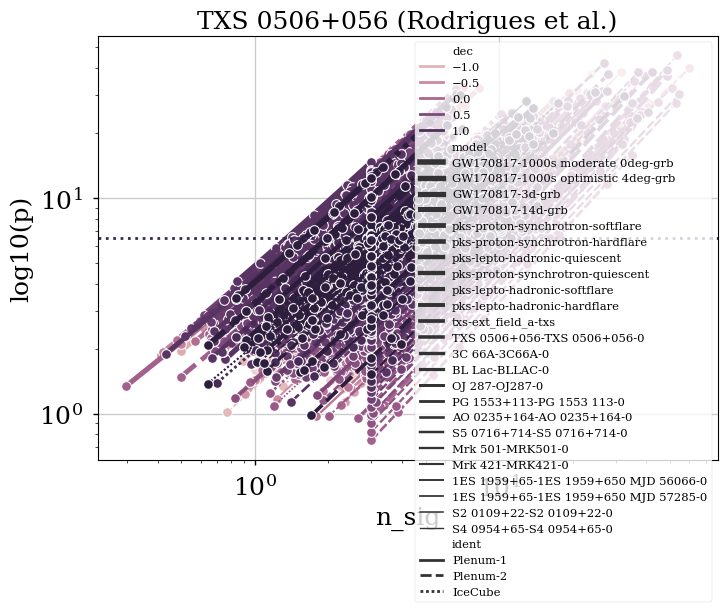

In [46]:
xname = "n_sig" #"scaler" # "SoB" # "SosB" # 
f, ax = plt.subplots()
ax = sns.lineplot(
    data=df, ax=ax,
    y="log10(p)", x=xname, marker="o", hue="dec", style="ident", size="model"
)
for t in thresholds:
    plt.axhline(-np.log10(t), ls=":")
plt.legend(fontsize="small")
ax.loglog()
ax.set_title(i)

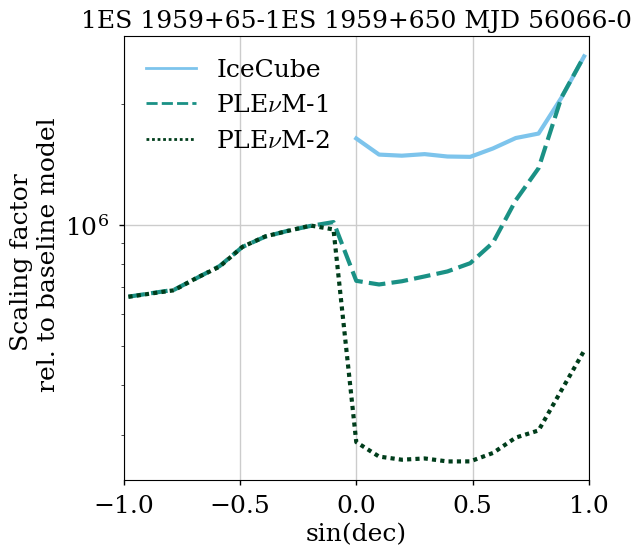

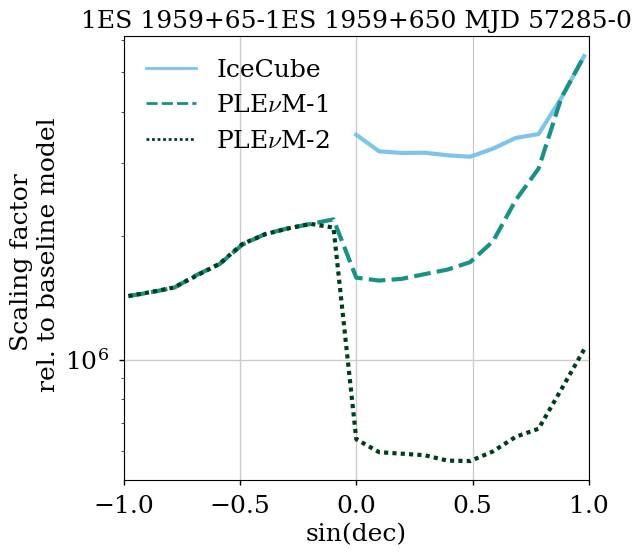

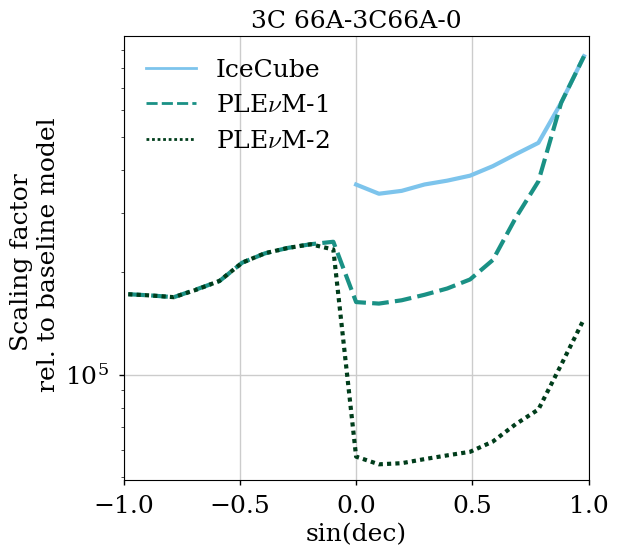

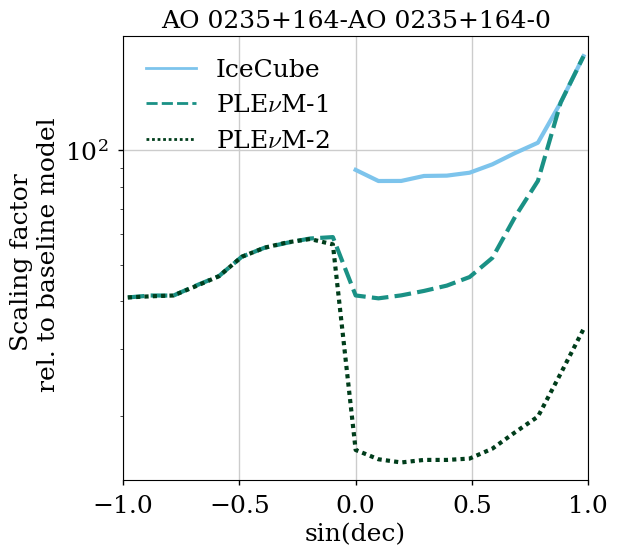

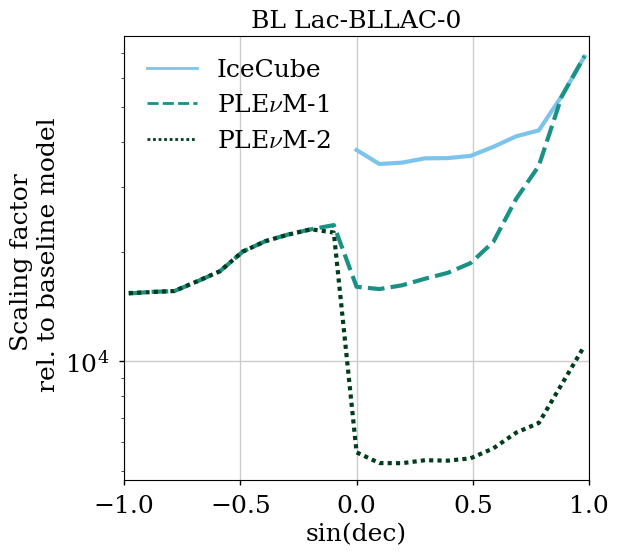

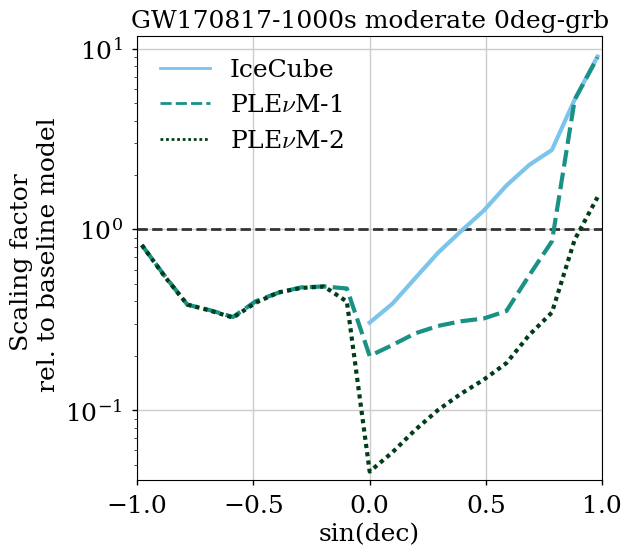

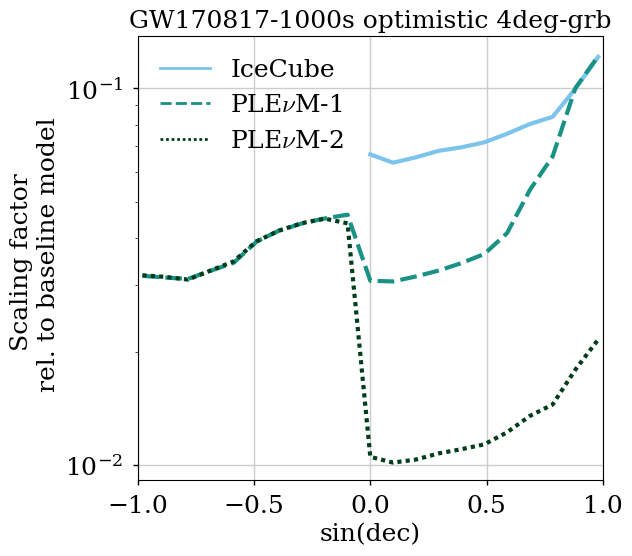

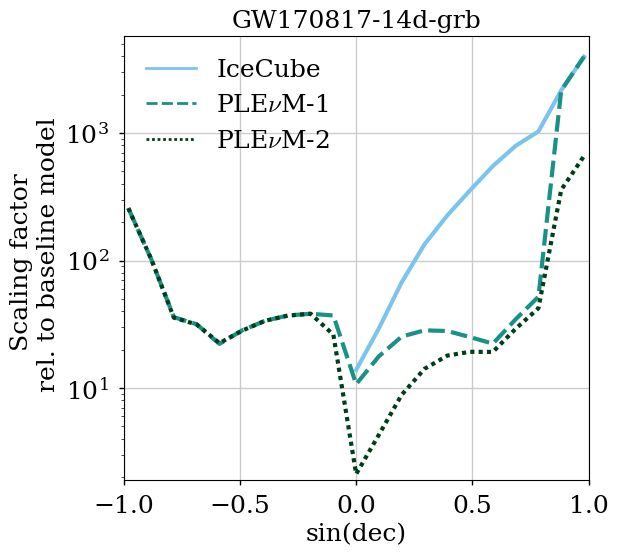

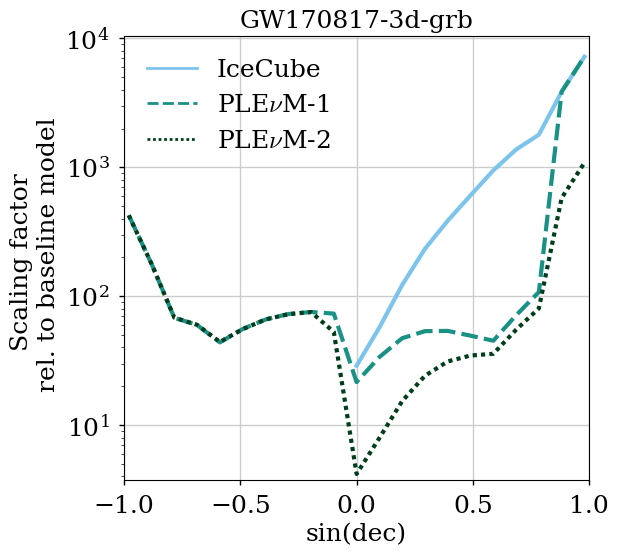

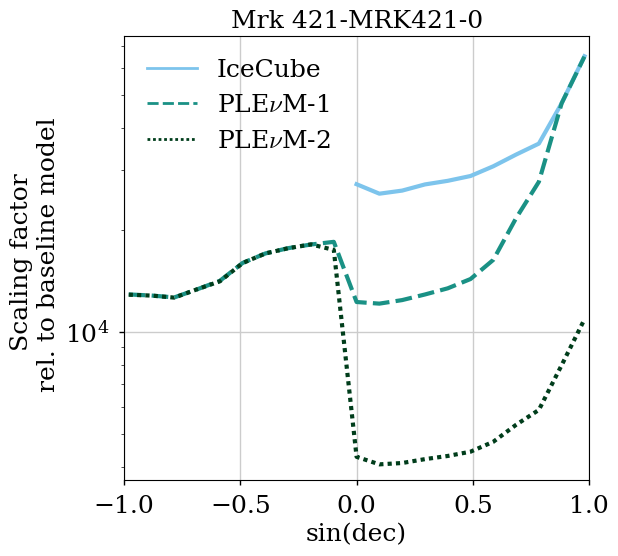

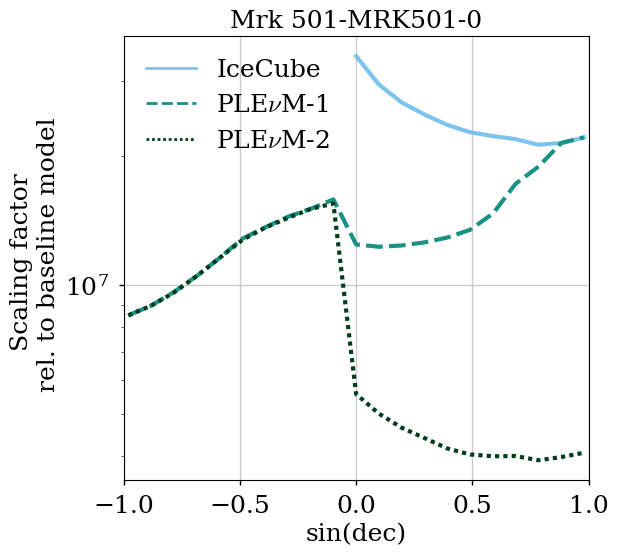

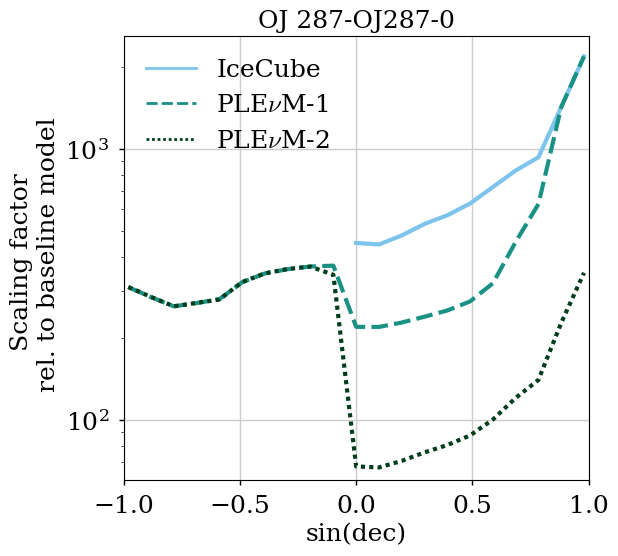

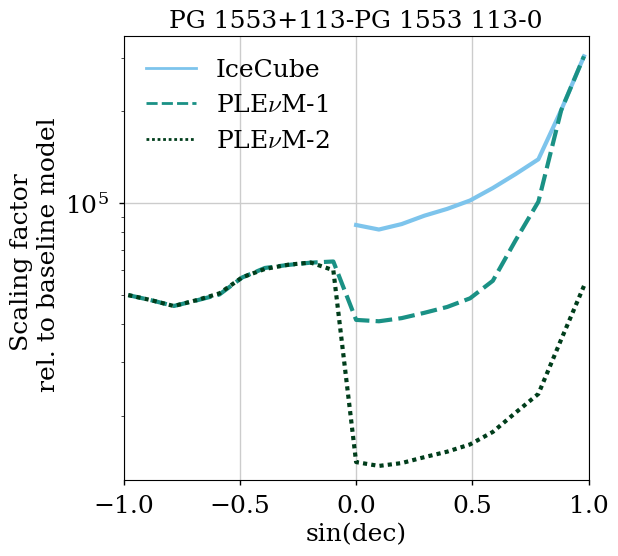

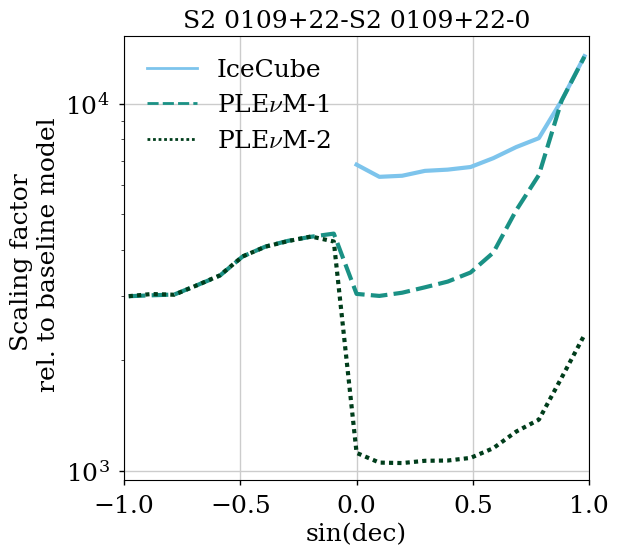

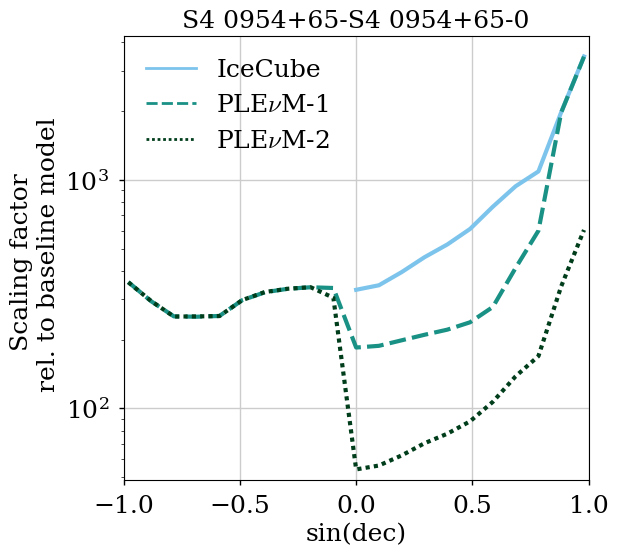

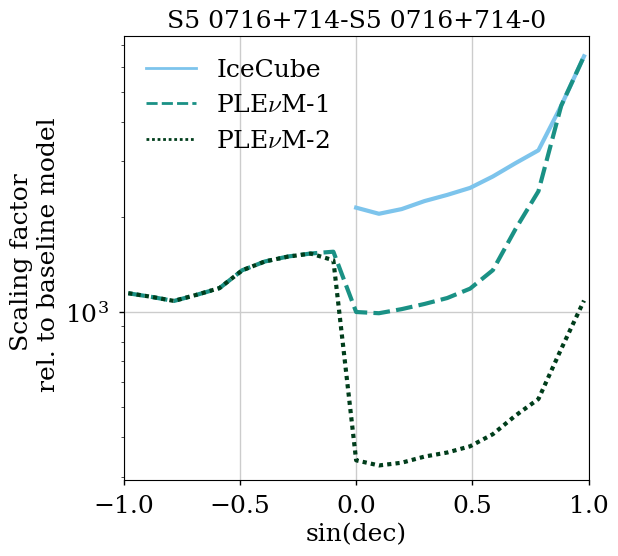

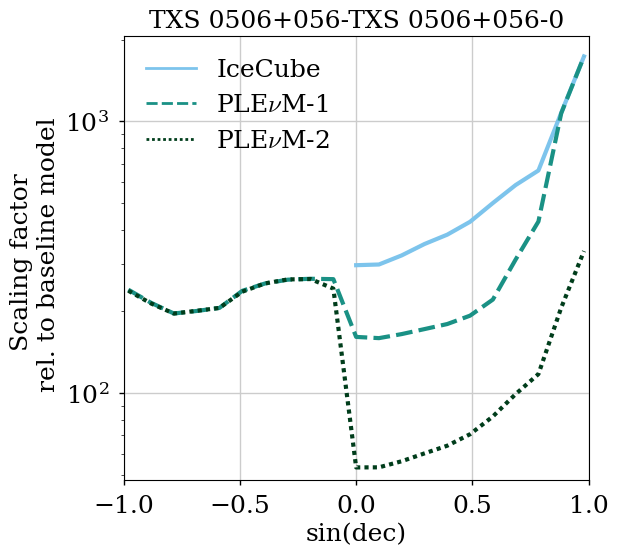

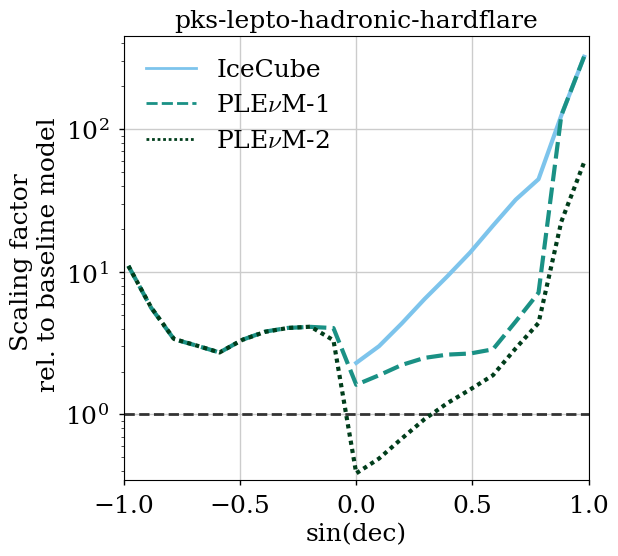

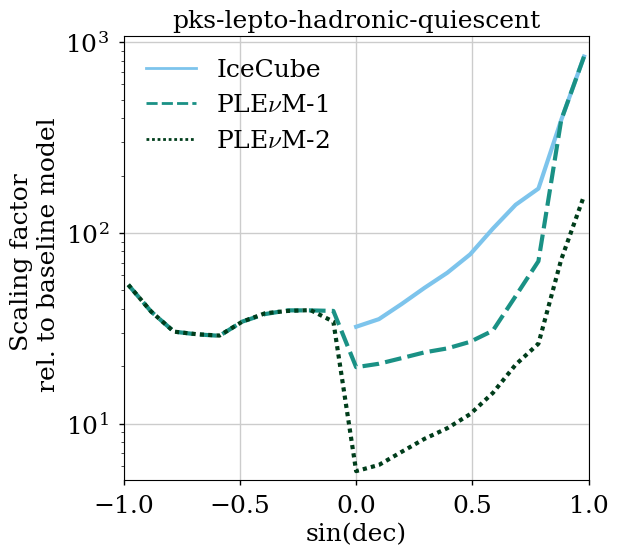

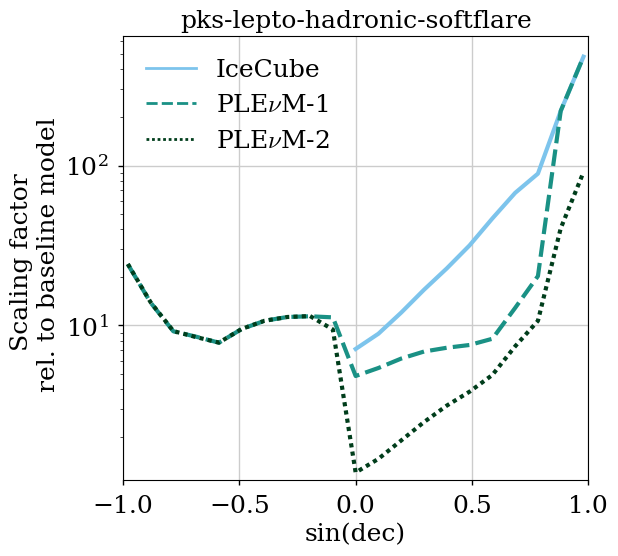

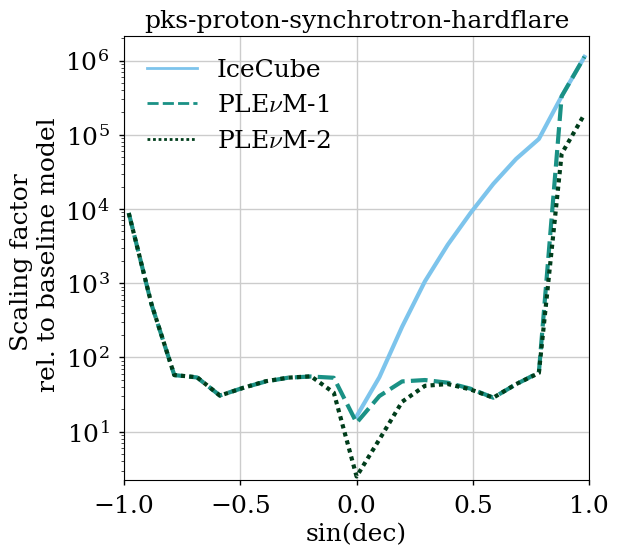

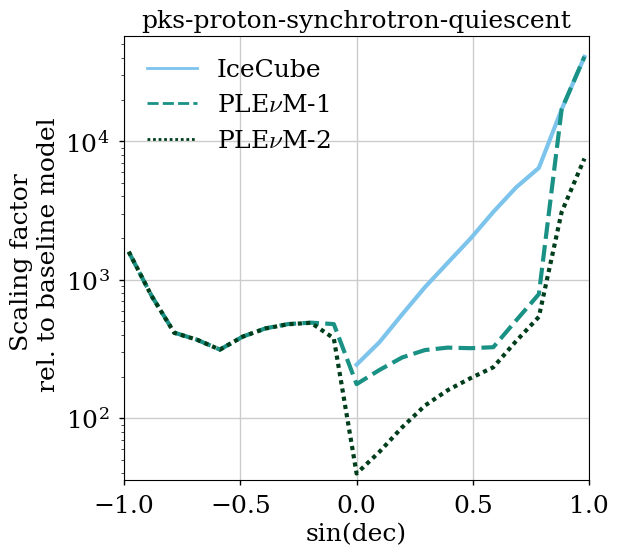

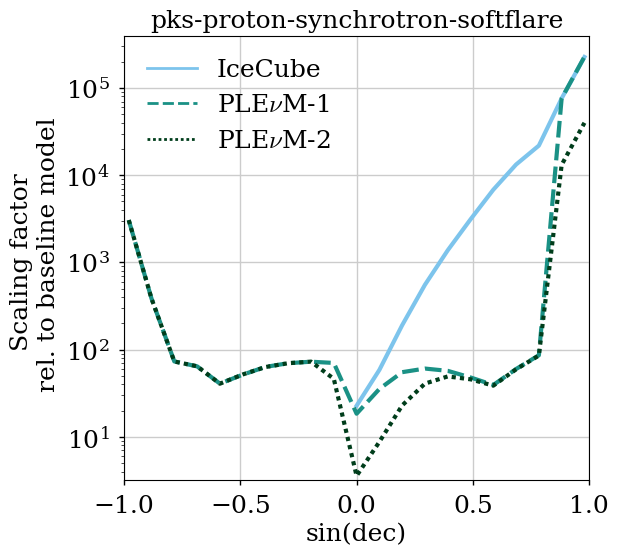

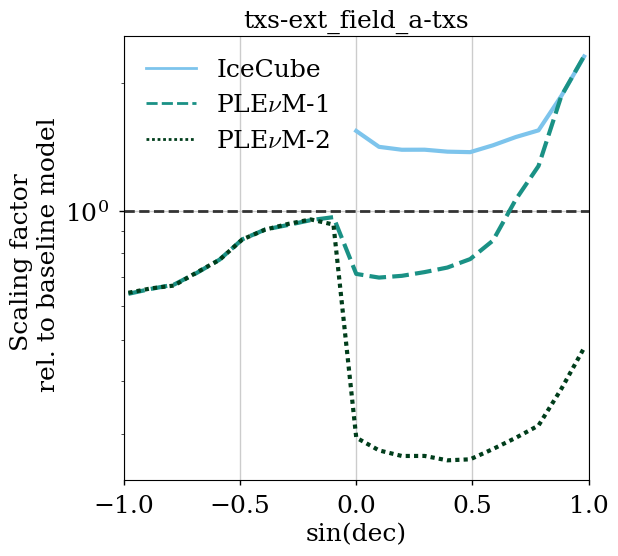

In [48]:
df = pd.read_pickle(join(st.LOCALPATH, "transient_discPot_all.pickle"))
key_y = "scaler"
flux = pd.DataFrame(
    df.groupby(["ident", "fancy_label", "model", "dec", "livetime"]).apply(
        lambda x: get_scaler(x, thresholds[0], key_y=key_y)
    ),
    columns=[key_y],
).reset_index()

# flux["fluence5"] = flux.disc5 * flux.livetime
flux["sin(dec)"] = np.sin(flux.dec)
for i, gb in flux.groupby("model"):
    f, ax = plt.subplots(figsize=(6, 6))
    sns.lineplot(
        gb,
        x="sin(dec)",
        y=key_y,
        style="fancy_label",
        hue="fancy_label",
        lw="3",
        palette="ch:s=2,r=.3,h=1.5,l=0.7",
        # markers=["o", "s", "d"],
        ms=12,
    )
    ymin = np.min(gb.loc[gb.ident=="Plenum-2", key_y])
    ax.set_yscale("log")
    # ax.set_yscale("symlog", linthresh=ymin)
    #ax.set_ylim(np.min([ymin, 0.1]), None)
    ax.set_ylim(ymin*0.9, None)
    ax.tick_params(axis="y", which="minor", bottom=False)
    ax.axhline(1, ls="--", lw=2, color="0.2", zorder=1)
    ax.axes.legend_.remove()
    ax.set_ylabel("Scaling factor \n rel. to baseline model")
    ax.legend(
        loc=0,  # "upper left",
        frameon=False,
        # fontsize=14,
        ncol=1,
        # bbox_to_anchor=(0.5, 0.93),
        columnspacing=0.8,
    )
    ax.set_title(i)
    ax.set_xlim(-1, 1)
    f.subplots_adjust(top=0.85)
# ax.set_title(rf"log-Parabola flux, $\alpha={Alpha}, \beta={Beta}$")
# f.savefig(
#     join(st.BASEPATH, "plots/icrc2023/logP_disc_pot_timedep.pdf"), bbox_inches="tight"
# )

# Pseudo experiments

In [49]:
from scipy.stats import poisson

In [50]:
def pseudo_exp(all_mu_s, all_mu_b, num=1, return_sb=False):
    all_k = np.zeros((num, *np.shape(all_mu_s)))
    #all_k = np.moveaxis(all_k, 1, 0)
    if return_sb:
        all_s = np.zeros_like(all_k)
        all_b = np.zeros_like(all_k)

    for ii, (ms, mb) in enumerate(zip(all_mu_s, all_mu_b)):
        tmp_s = poisson.rvs(ms, size=(num, *np.shape(ms)))
        tmp_b = poisson.rvs(mb, size=(num, *np.shape(mb)))
        all_k[:,ii,:,:] = tmp_s + tmp_b
        if return_sb:
            all_s[:,ii,:,:] = tmp_s
            all_b[:,ii,:,:] = tmp_b

    if return_sb:
        return all_k, all_s, all_b
    else:
        return all_k

## PE trials

In [51]:
verbose = False
detector_keys = [
    "Plenum-1",
]

num = 1000

results = []

for ident, (model_key, dct) in tqdm(product(detector_keys, selected_models.items())):
    series = dct["model"]
    # setup config
    conf = detector_configurations[ident]
    current_bg_config = deepcopy(bg_config)
    current_bg_config["livetime"] = series["livetime/s"]
    current_bg_config["dec"] = series["dec/rad"]

    current_src_config = deepcopy(src_config)
    current_src_config["livetime"] = (
        series["livetime/s"] if series.state != "grb" else 1
    )  # GRB uses Fluence already
    current_src_config["dec"] = series["dec/rad"]

    all_mu_s, all_mu_b, all_mu = setup_multi_model_llh(  # todo
        improved_eres,
        conf,
        bg_config=current_bg_config,
        sig_config=current_src_config,
        model_spline=series["model_spline"],
        verbose=verbose,
    )
    all_k, all_ks, all_kb = pseudo_exp(all_mu_s, all_mu_b, return_sb=True, num=num)

    pvals = np.zeros(len(all_k) + 1)

    for jj in range(len(pvals)):
        local_llh = lambda x: model_llh_multi(
            (x[0], 0), all_mu_s, all_mu_b, all_k[jj - 1] if jj > 0 else all_mu # First Asimov, then the PEs
        )
        global_llh = lambda x: model_llh_multi(
            x, all_mu_s, all_mu_b, all_k[jj - 1] if jj > 0 else all_mu # First Asimov, then the PEs
        )

        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1,),
            bounds=[
                (1e-2, 1e2),
            ],
            approx_grad=True,
        )

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1),
            bounds=[(1e-3, 1e2), (0, 1e2)],
            approx_grad=True,
        )

        pvals[jj] = chi2.sf(
            out_bckg[1] - out_comp[1], 1
        )  # atmo(n) vs atmo(n) + signal(n) = 1 ndof
        # significance = norm.isf(pvals[jj] / 2)

    results.append({"src": model_key, "detector": ident, "pval": pvals})

    if False:  # significance > 0:
        print(key)
        print(series.model_name, series.src_name, series.state)
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        print("Signal:", np.sum(all_ks), f"(expectation: {np.sum(all_mu_s)})")
        print("Background:", np.sum(all_kb))
        print("Atmo-only normalization:", out_bckg[0])
        print("Signal fit parameters:", out_comp[0])
        print("TS check:", global_llh((1, 1)), "(fit: ", out_comp[1], ")")
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
        print()
        print(" = " * 10)
results = pd.DataFrame(results)

0it [00:00, ?it/s]

4it [03:24, 51.16s/it]


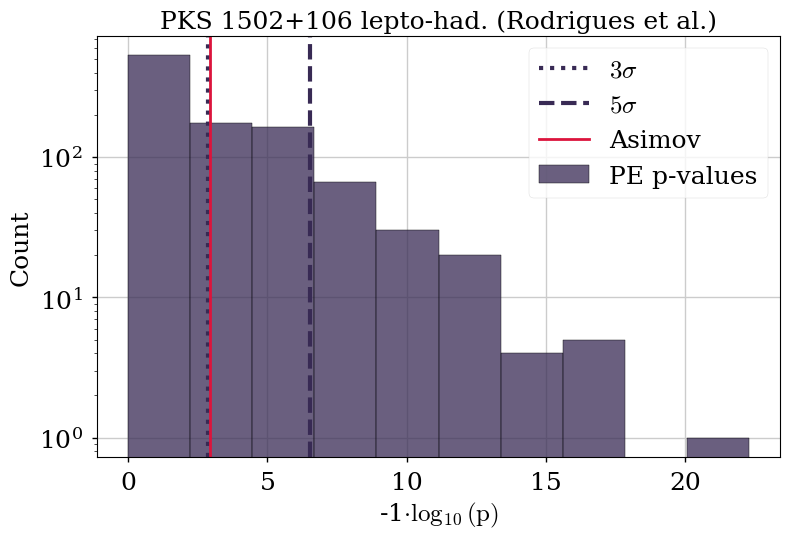

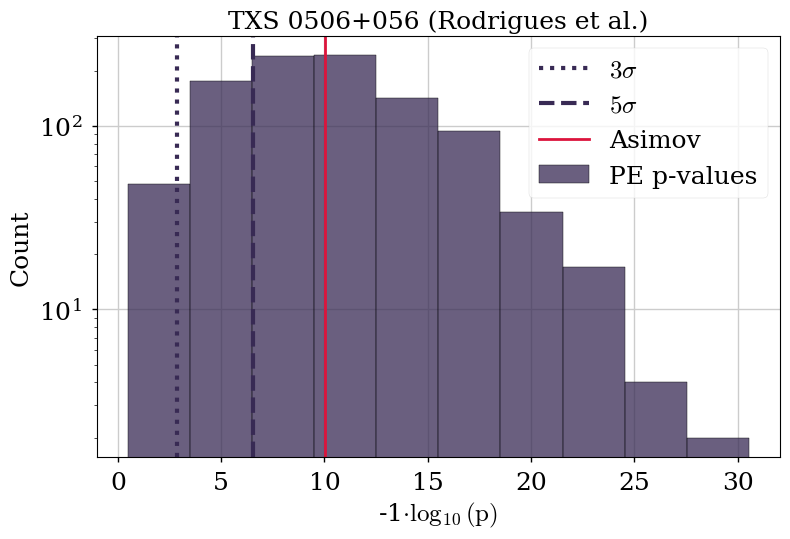

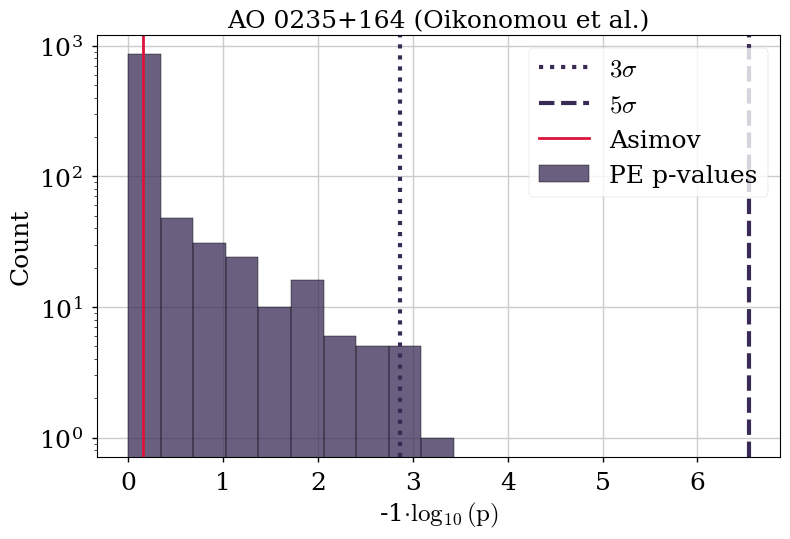

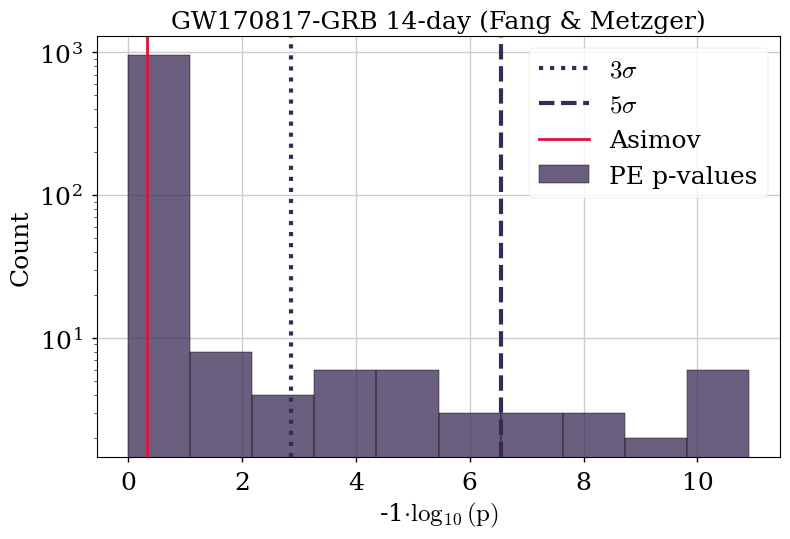

In [52]:
sign = -1 # or -1
for _, row in results.iterrows():
    plt.figure()
    ax = sns.histplot(sign * np.log10(row.pval[1:]), label="PE p-values", bins=10, cumulative=False)
    ax.axvline(sign * np.log10(st.sigma3), ls=":", label=r"$3\sigma$", lw=3)
    ax.axvline(sign * np.log10(st.sigma5), ls="--", label=r"$5\sigma$", lw=3)
    ax.axvline(sign * np.log10(row.pval[0]), label=r"Asimov", color="crimson")
    ax.set_xlabel(rf"{sign}$\cdot \log _{{10}}({{\rm p}})$")
    ax.set_yscale("log") #"symlog", linthresh=5)
    ax.legend()
    ax.set_title(row.src)
    plt.tight_layout()
    plt.show()

## stacking

In [53]:
verbose = False
detector_keys = [
    "Plenum-1",
]

num = 100
stacked_mu_s = []
stacked_mu_b = []
stacked_mu = []

for ident, (_, series) in tqdm(product(detector_keys, blazar_models.iterrows())):
    # setup config
    conf = detector_configurations[ident]
    current_bg_config = deepcopy(bg_config)
    current_bg_config["livetime"] = series["livetime/s"]
    current_bg_config["dec"] = series["dec/rad"]

    current_src_config = deepcopy(src_config)
    current_src_config["livetime"] = (
        series["livetime/s"] if series.state != "grb" else 1
    )  # GRB uses Fluence already
    current_src_config["dec"] = series["dec/rad"]

    all_mu_s, all_mu_b, all_mu = setup_multi_model_llh(  # todo
        improved_eres,
        conf,
        bg_config=current_bg_config,
        sig_config=current_src_config,
        model_spline=series["model_spline"],
        verbose=verbose,
    )

    stacked_mu.extend(all_mu)
    stacked_mu_b.extend(all_mu_b)
    stacked_mu_s.extend(all_mu_s)
print("stacking done...")
all_k, all_ks, all_kb = pseudo_exp(
    stacked_mu_s, stacked_mu_b, return_sb=True, num=num
)

pvals = np.zeros(len(all_k) + 1)

for jj in tqdm(range(len(pvals))):
    local_llh = lambda x: model_llh_multi(
        (x[0], 0),
        stacked_mu_s,
        stacked_mu_b,
        all_k[jj - 1] if jj > 0 else stacked_mu,  # First Asimov, then the PEs
    )
    global_llh = lambda x: model_llh_multi(
        x,
        stacked_mu_s,
        stacked_mu_b,
        all_k[jj - 1] if jj > 0 else stacked_mu,  # First Asimov, then the PEs
    )

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        bounds=[
            (1e-2, 1e2),
        ],
        approx_grad=True,
    )

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1),
        bounds=[(1e-3, 1e2), (0, 1e2)],
        approx_grad=True,
    )

    pvals[jj] = chi2.sf(
        out_bckg[1] - out_comp[1], 1
    )  # atmo(n) vs atmo(n) + signal(n) = 1 ndof
    # significance = norm.isf(pvals[jj] / 2)


10it [00:00, 97.75it/s]

13it [00:00, 97.93it/s]


stacking done...


100%|██████████| 101/101 [01:05<00:00,  1.55it/s]


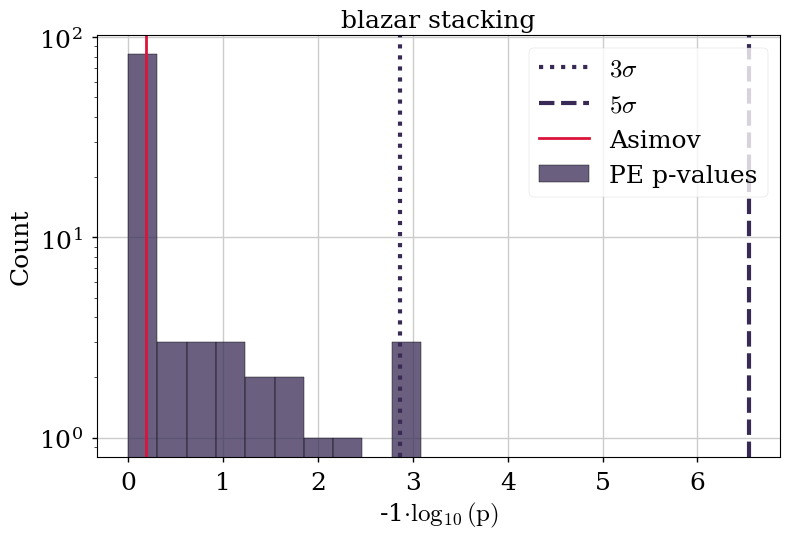

In [54]:
sign = -1 # or -1
plt.figure()
ax = sns.histplot(sign * np.log10(pvals[1:]), label="PE p-values", bins=10, cumulative=False)
ax.axvline(sign * np.log10(st.sigma3), ls=":", label=r"$3\sigma$", lw=3)
ax.axvline(sign * np.log10(st.sigma5), ls="--", label=r"$5\sigma$", lw=3)
ax.axvline(sign * np.log10(pvals[0]), label=r"Asimov", color="crimson")
ax.set_xlabel(rf"{sign}$\cdot \log _{{10}}({{\rm p}})$")
ax.set_yscale("log") #"symlog", linthresh=5)
ax.legend()
ax.set_title("blazar stacking")
plt.tight_layout()
plt.show()

# Alert acceptance

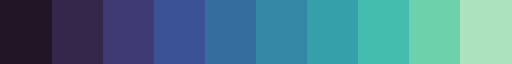

In [55]:
_config = dict(
    sindec_mids=st.sindec_mids,
    sindec_width=st.sindec_width,
    livetime=st.LIVETIME,
    ewidth=st.ewidth,
    diff_or_ps="diff",
)
# using the diffuse flux parametrization here
# because we want to have the all-sky results and normalization doesn't matter
if False:
    # set the lowest 10% to gray
    grayscale = 0.25
    cmap = ListedColormap(
        np.concatenate(
            [
                [(grayscale, grayscale, grayscale)],
                sns.color_palette("mako", n_colors=10)[1:],
            ]
        )
    )
else:
    # full color map
    cmap = ListedColormap(sns.color_palette("mako", n_colors=10))
    cmap_r = ListedColormap(
        sns.color_palette("mako_r", n_colors=9)
    )
    cmap_r.set_under("w")

cmap

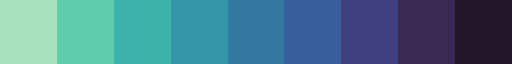

In [56]:
cmap_r

In [57]:
def add_local_horizon(time, loc, ax, c="tomato", **kwargs):
    local_horizon = SkyCoord(
        az=np.linspace(-np.pi, np.pi, 100) * u.rad,
        alt=0 * u.rad,
        frame=AltAz(obstime=time, location=loc),
    )
    cra, cdec = local_horizon.icrs.ra, local_horizon.icrs.dec
    ind = np.argsort(cra)
    cra, cdec = cra[ind], cdec[ind]
    cra = cra.wrap_at("360d")
    cra, cdec = cra.rad, cdec.rad
    ax.plot(
        cra - np.pi, cdec, marker="None", c=c, **kwargs
    )

In [58]:
pp, tt = np.meshgrid(st.ra_mids, np.arcsin(st.sindec_bins))
eq_coords = SkyCoord(pp * u.radian, tt * u.radian, frame="icrs")

## specific models

### full data

In [159]:
selected_models["PKS 1502+106 lepto-had. (Rodrigues et al.)"]

{'model': src_name                                                      pks
 model_name                                         lepto-hadronic
 state                                                   hardflare
 bf_or_band                                                bestfit
 model_spline    <scipy.interpolate._fitpack2.InterpolatedUniva...
 N_nu(IC)                                                 0.767683
 dec/rad                                                  0.183159
 livetime/s                                               31536000
 Name: 12, dtype: object,
 'start_scaler': 6,
 'coords': <SkyCoord (ICRS): (ra, dec) in deg
     (226.10408333, 10.49422222)>}

48.17825069472596
660.1014222761129
15.471888828408456
113902956.86583212


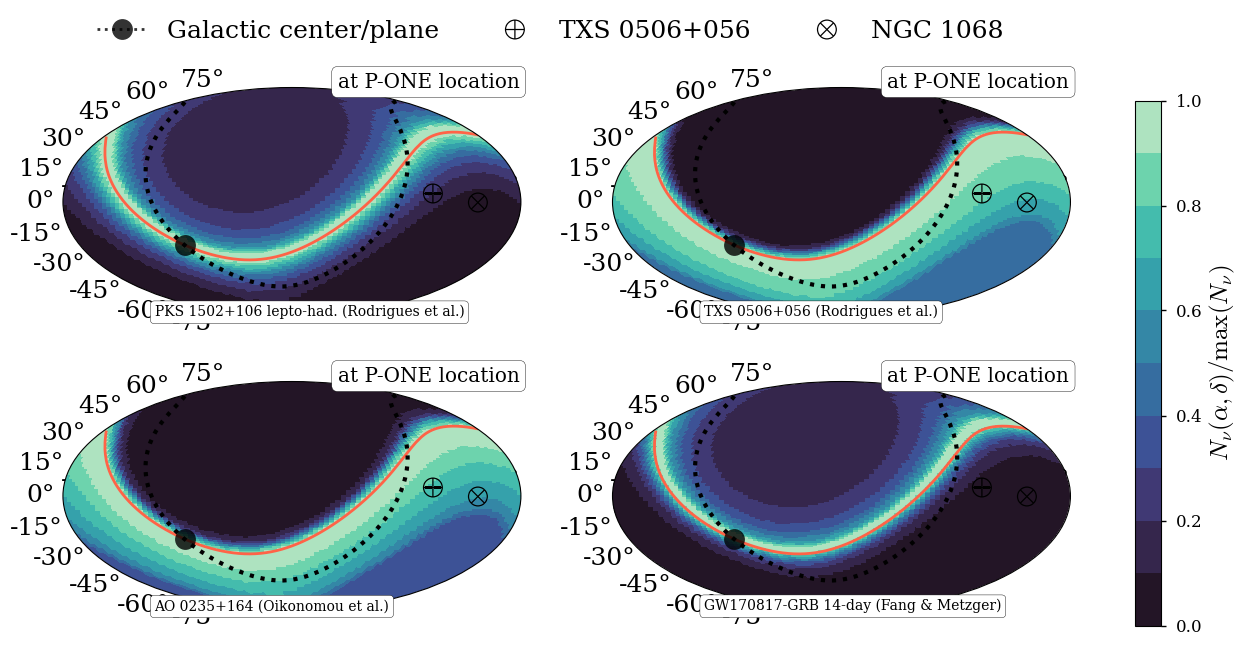

In [ ]:
key = "IceCube"
fig = plt.figure(figsize=(13, 7))
make_legend = True
aeff_factor = calc_aeff_factor(aeff_2d_full[key], **_config)
n2ind = [221, 222, 223, 224]

for ii, dkey in enumerate(selected_models):
    k_s = aeff_factor * 10 ** selected_models[dkey]["model"]["model_spline"](st.logE_mids)

    print(np.sum(k_s))
    #k_s /= np.sum(k_s)
    grid2d, _ = setup_aeff_grid(
        [k_s.sum(axis=1)], st.sindec_mids, st.ra_mids, st.ra_width, log_int=False
    )

    loc = EarthLocation(lat=st.poles["P-ONE"]["lat"], lon=st.poles["P-ONE"]["lon"])
    # arbitrary time, doesnt matter here
    time = Time("2023-6-21 00:00:00")
    # transform integration coordinates to local frame
    local_coords_grid = eq_coords.transform_to(AltAz(obstime=time, location=loc))
    inst_ev = grid2d[0]((local_coords_grid.alt.rad, local_coords_grid.az.rad))
    
    max_ev = np.max(inst_ev)
    normalized_inst_ev = inst_ev / max_ev # normalize to highest acceptance

    ax = fig.add_subplot(n2ind[ii], projection="hammer", rasterized=True)
    cax = ax.pcolormesh(
        st.ra_mids - np.pi,
        np.arcsin(st.sindec_bins),
        normalized_inst_ev,
        cmap=cmap,
        vmin=0,
        vmax=1,
        # norm=LogNorm(vmin=1e-2, vmax=1),
    )
    add_local_horizon(time, loc, ax)
    # add the galactic center and plane
    if make_legend:
        add_plane(ax, color="black")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")
        make_legend = False
    else:
        add_plane(ax, color="black", label="__None__")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", label="__None__")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", label="__None__")
    ax.text(
        0.6,
        1.0,
        st.poles["P-ONE"]["label"],
        fontsize="x-large",
        transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
    ax.text(
        0.2,
        0,
        s=dkey,
        transform=ax.transAxes,
        fontsize="medium", #"x-large",
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
fig.legend(
    # fontsize="small",
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.9),
)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(r"$N_{\nu}(\alpha, \delta) / \max(N_{\nu})$")
cbar.ax.tick_params(labelsize="large")

### E>100TeV

In [251]:
from tools import add_src

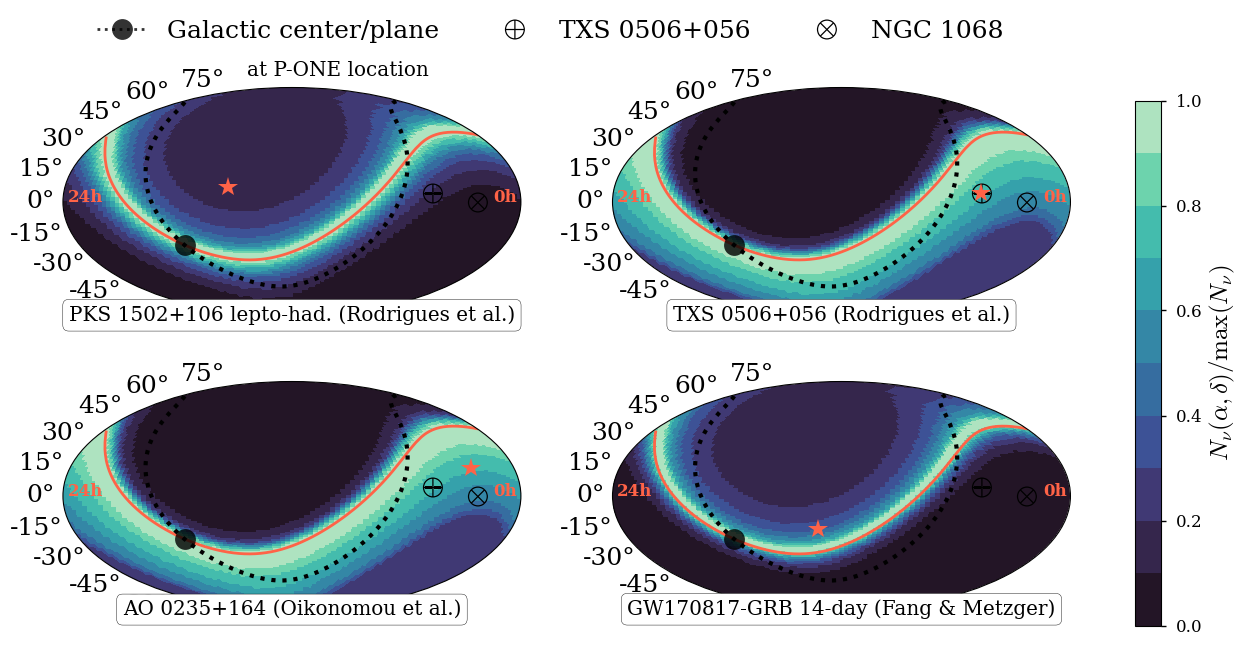

In [252]:
key = "IceCube"
fig = plt.figure(figsize=(13, 7))
make_legend = True
aeff_factor = calc_aeff_factor(aeff_2d_full[key], **_config)
n2ind = [221, 222, 223, 224]

for ii, dkey in enumerate(selected_models):
    k_s = energy_smearing(
        improved_eres,
        aeff_factor
        * 10 ** selected_models[dkey]["model"]["model_spline"](st.logE_mids),
    )

    # simple alert threshold of 100 TeV
    k_s.histo[:, st.logE_reco_mids < 5] = 0

    grid2d, _ = setup_aeff_grid(
        [k_s.sum(axis=1)], st.sindec_mids, st.ra_mids, st.ra_width, log_int=False
    )

    loc = EarthLocation(lat=st.poles["P-ONE"]["lat"], lon=st.poles["P-ONE"]["lon"])
    # arbitrary time, doesnt matter here
    time = Time("2023-6-21 00:00:00")
    # transform integration coordinates to local frame
    local_coords_grid = eq_coords.transform_to(AltAz(obstime=time, location=loc))
    inst_ev = grid2d[0]((local_coords_grid.alt.rad, local_coords_grid.az.rad))

    max_ev = np.max(inst_ev)
    normalized_inst_ev = inst_ev / max_ev

    ax = fig.add_subplot(n2ind[ii], projection="hammer", rasterized=True)
    cax = ax.pcolormesh(
        st.ra_mids - np.pi,
        np.arcsin(st.sindec_bins),
        normalized_inst_ev,
        cmap=cmap,
        vmin=0,
        vmax=1,
        zorder=0
        # norm=LogNorm(vmin=1e-2, vmax=1),
    )
    add_local_horizon(time, loc, ax)
    # add the galactic center and plane
    if make_legend:
        add_plane(ax, color="black")
        add_src(ax, st.txs0506, label="TXS 0506+056", marker=r"$\bigoplus$", c="k")
        add_src(ax, st.ngc1068, label="NGC 1068", marker=r"$\bigotimes$", c="k")
        make_legend = False
    else:
        add_plane(ax, color="black", label="__None__")
        add_src(ax, st.txs0506, marker=r"$\bigoplus$", c="k", label="__None__")
        add_src(ax, st.ngc1068, marker=r"$\bigotimes$", c="k", label="__None__")
    add_src(
        ax, selected_models[dkey]["coords"], marker="*", c="tomato", label="__None__"
    )
    if ii == 0:
        ax.text(
            0.6,
            1.05,
            st.poles["P-ONE"]["label"],
            fontsize="x-large",
            transform=ax.transAxes,
            ha="center",
            # bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
        )
    ax.text(
        0.5,
        -0.02,
        s=dkey,
        transform=ax.transAxes,
        fontsize="x-large",
        ha="center",
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
    ax.text(0.94, 0.5, s="0h", transform=ax.transAxes, zorder=0, color="tomato", fontsize="large", weight="heavy")
    ax.text(0.01, 0.5, s="24h", transform=ax.transAxes, zorder=0, color="tomato", fontsize="large", weight="heavy")
    ax.set_xticks([])
    ax.grid(False)
fig.legend(
    # fontsize="small",
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.9),
)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(r"$N_{\nu}(\alpha, \delta) / \max(N_{\nu})$")
cbar.ax.tick_params(labelsize="large")

### only 50%

In [253]:
light_color = "tomato"

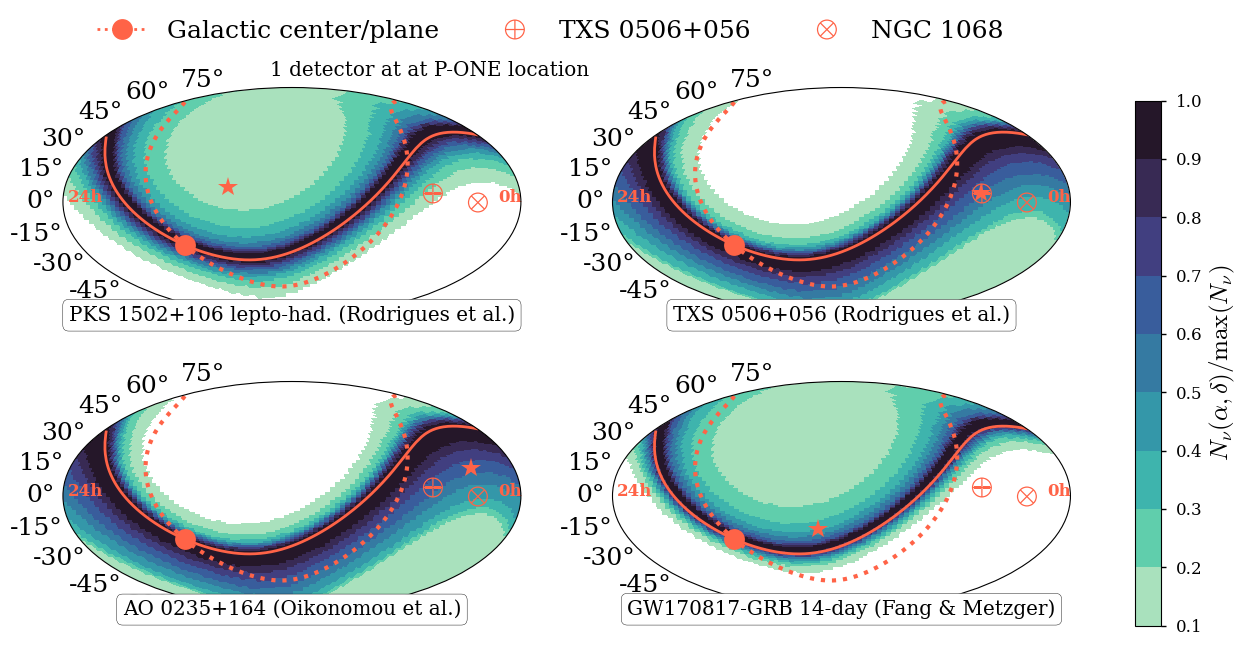

In [254]:
### single detector

key = "IceCube"
fig = plt.figure(figsize=(13, 7))
make_legend = True
aeff_factor = calc_aeff_factor(aeff_2d_full[key], **_config)
n2ind = [221, 222, 223, 224]
min_v = 0.1

for ii, dkey in enumerate(selected_models):
    k_s = energy_smearing(
        baseline_eres,
        aeff_factor
        * 10 ** selected_models[dkey]["model"]["model_spline"](st.logE_mids),
    )

    # simple alert threshold of 100 TeV
    k_s.histo[:, st.logE_reco_mids < 5] = 0

    grid2d, _ = setup_aeff_grid(
        [k_s.sum(axis=1)], st.sindec_mids, st.ra_mids, st.ra_width, log_int=False
    )

    loc = EarthLocation(lat=st.poles["P-ONE"]["lat"], lon=st.poles["P-ONE"]["lon"])
    # arbitrary time, doesnt matter here
    time = Time("2023-6-21 00:00:00")
    # transform integration coordinates to local frame
    local_coords_grid = eq_coords.transform_to(AltAz(obstime=time, location=loc))
    inst_ev = grid2d[0]((local_coords_grid.alt.rad, local_coords_grid.az.rad))

    max_ev = np.max(inst_ev)
    normalized_inst_ev = inst_ev / max_ev
    normalized_inst_ev[normalized_inst_ev < min_v] = 0  # show only contributions > x

    ax = fig.add_subplot(n2ind[ii], projection="hammer", rasterized=True)
    cax = ax.pcolormesh(
        st.ra_mids - np.pi,
        np.arcsin(st.sindec_bins),
        normalized_inst_ev,
        cmap=cmap_r,
        vmin=min_v,
        vmax=1,
        zorder=0
        # norm=LogNorm(vmin=1e-2, vmax=1),
    )
    add_local_horizon(time, loc, ax)
    # add the galactic center and plane
    if make_legend:
        add_plane(ax, color=light_color, alpha=1)
        add_src(ax, st.txs0506, label="TXS 0506+056", marker=r"$\bigoplus$", c=light_color, alpha=1)
        add_src(ax, st.ngc1068, label="NGC 1068", marker=r"$\bigotimes$", c=light_color, alpha=1)
        make_legend = False
    else:
        add_plane(ax, color=light_color, alpha=1, label="__None__")
        add_src(ax, st.txs0506, marker=r"$\bigoplus$", c=light_color, alpha=1, label="__None__")
        add_src(ax, st.ngc1068, marker=r"$\bigotimes$", c=light_color, alpha=1, label="__None__")
    add_src(
        ax, selected_models[dkey]["coords"], marker="*", c=light_color, alpha=1, label="__None__"
    )
    if ii == 0:
        ax.text(
            0.8,
            1.05,
            "1 detector at " + st.poles["P-ONE"]["label"],
            fontsize="x-large",
            transform=ax.transAxes,
            ha="center",
            # bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
        )
    ax.text(
        0.5,
        -0.02,
        s=dkey,
        transform=ax.transAxes,
        fontsize="x-large",
        ha="center",
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
    ax.text(0.95, 0.5, s="0h", transform=ax.transAxes, zorder=0, color="tomato", fontsize="large", weight="heavy")
    ax.text(0.01, 0.5, s="24h", transform=ax.transAxes, zorder=0, color="tomato", fontsize="large", weight="heavy")
    ax.set_xticks([])
    ax.grid(False)
fig.legend(
    # fontsize="small",
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.9),
)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(r"$N_{\nu}(\alpha, \delta) / \max(N_{\nu})$")
cbar.ax.tick_params(labelsize="large")

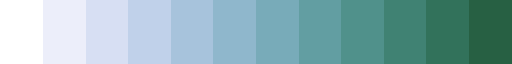

In [256]:
# cmap_sparse = ListedColormap(sns.light_palette("tab:blue", n_colors=6))
# cmap_sparse
cmap_sparse = ListedColormap(sns.cubehelix_palette(start=1.8, rot=0.4, light=1, dark=0.3, n_colors=12))
cmap_sparse

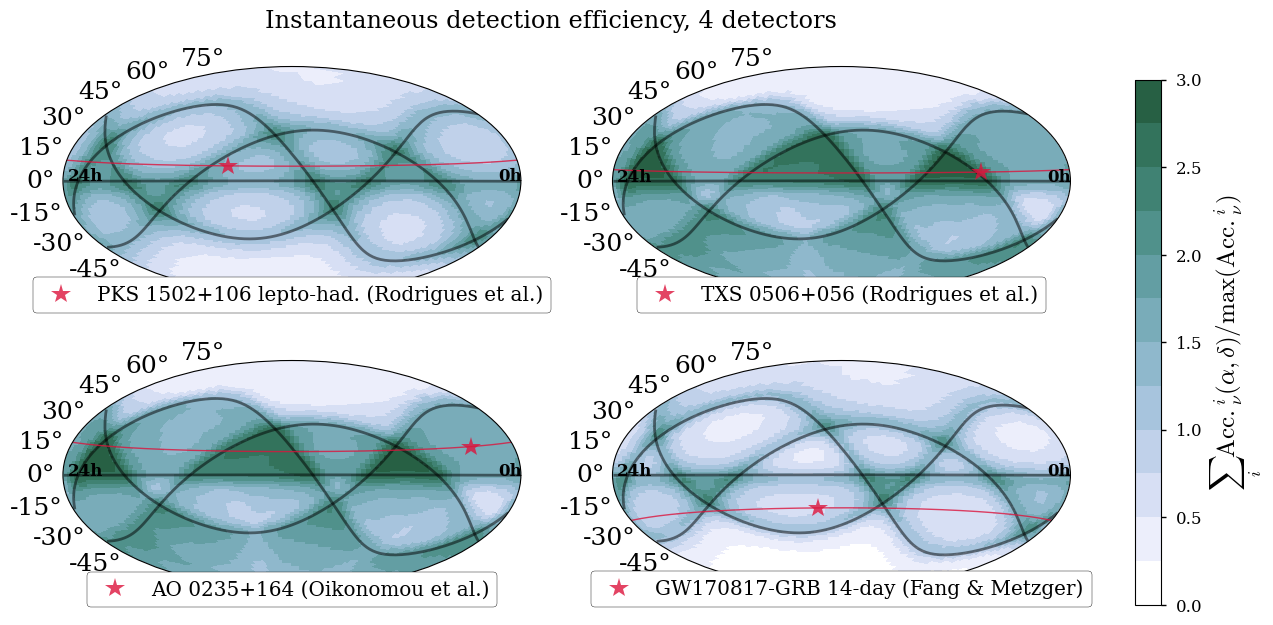

In [257]:
### four detectors together
light_color = "k"
key = "IceCube"  # that's just baseline for rotation
fig = plt.figure(figsize=(13, 7))
make_legend = True
aeff_factor = calc_aeff_factor(aeff_2d_full[key], **_config)
n2ind = [221, 222, 223, 224]

verbose = False

if verbose: 
    f2, axes2 = plt.subplots()
    f3, axes3 = plt.subplots()

bins2 = np.linspace(0, 1, num=200)
bins3 = np.linspace(0, 3, num=200)
# bins = np.concatenate([[0], np.logspace(-3, 0.6)])
acc_threshs = np.linspace(0.1, 2.6, num=60) 
detector_keys = ["IceCube", "P-ONE", "KM3NeT", "Baikal-GVD"]
tf_tmp = []

for ii, dkey in enumerate(selected_models):
    k_s = energy_smearing(
        improved_eres,
        aeff_factor
        * 10 ** selected_models[dkey]["model"]["model_spline"](st.logE_mids),
    )

    # simple alert threshold of 100 TeV
    k_s.histo[:, st.logE_reco_mids < 5] = 0
    grid2d, _ = setup_aeff_grid(
        [k_s.sum(axis=1)], st.sindec_mids, st.ra_mids, st.ra_width, log_int=False
    )
    time = Time("2023-6-21 00:00:00")
    inst_ev = np.zeros_like(eq_coords.ra.rad)
    ax = fig.add_subplot(n2ind[ii], projection="hammer", rasterized=True)

    for ident in detector_keys:
        loc = EarthLocation(lat=st.poles[ident]["lat"], lon=st.poles[ident]["lon"])
        # arbitrary time, doesnt matter here
        # transform integration coordinates to local frame
        local_coords_grid = eq_coords.transform_to(AltAz(obstime=time, location=loc))
        tmp = grid2d[0]((local_coords_grid.alt.rad, local_coords_grid.az.rad))
        tmp /= np.max(tmp)

        inst_ev += tmp
        add_local_horizon(time, loc, ax, c="k", alpha=0.5, lw=2)
        if ident == "IceCube":
            if verbose:
                sns.histplot(
                    inst_ev.flatten(),
                    bins=bins2,
                    label=dkey + ", IceCube",
                    alpha=0.3,
                    ax=axes2,
                    cumulative=True,
                    stat="density",
                )
            h, ed = np.histogram(inst_ev.flatten(), bins=bins2)
            hc = np.cumsum(h) / np.sum(h, dtype=float)  # normalize to 1
            for at in acc_threshs:
                if at < 1:
                    threshold_fraction = hc[ed[:-1] >= at][0]
                    if verbose:
                        axes2.axhline(threshold_fraction)
                    tf_tmp.append(
                        {
                            "Model": dkey,
                            "Detector": "IceCube",
                            "Threshold": at,
                            "Threshold Fraction": 1 - threshold_fraction,
                        }
                    )
                    # print(dkey, "IceCube", at, threshold_fraction)
    if verbose:
        sns.histplot(
            inst_ev.flatten(),
            bins=bins3,
            label=dkey,
            alpha=0.3,
            ax=axes3,
            cumulative=True,
            stat="density",
        )
    h, ed = np.histogram(inst_ev.flatten(), bins=bins3)
    hc = np.cumsum(h) / np.sum(h, dtype=float)  # normalize to 1
    for at in acc_threshs:
        threshold_fraction = hc[ed[:-1] >= at][0]
        if verbose:
            axes3.axhline(threshold_fraction)
        tf_tmp.append(
            {
                "Model": dkey,
                "Detector": "PLEnuM-1",
                "Threshold": at,
                "Threshold Fraction": 1 - threshold_fraction,
            }
        )
        # print(dkey, "PLEnuM", at, threshold_fraction)

    cax = ax.pcolormesh(
        st.ra_mids - np.pi,
        np.arcsin(st.sindec_bins),
        inst_ev,
        cmap=cmap_sparse,
        vmin=0,
        vmax=3,
        zorder=0,
    )
    add_src(
        ax,
        selected_models[dkey]["coords"],
        dec_line=True,
        marker="*",
        c="crimson",  # light_color,
        alpha=0.8,
        label=dkey,
        lw=1,
    )

    ax.text(
        0.95,
        0.5,
        s="0h",
        transform=ax.transAxes,
        zorder=20,
        color="k",
        fontsize="large",
        weight="heavy",
    )
    ax.text(
        0.01,
        0.5,
        s="24h",
        transform=ax.transAxes,
        zorder=20,
        color="k",
        fontsize="large",
        weight="heavy",
    )
    ax.set_xticks([])
    ax.grid(False)
    ax.legend(
        fontsize="x-large",
        loc="lower center",
        framealpha=1,
        edgecolor=(0, 0, 0, 1),
        # ncol=3,
        frameon=True,  # False,
        bbox_to_anchor=(0.5, -0.12),
    )

fig.suptitle(
    "Instantaneous detection efficiency, 4 detectors", fontsize="xx-large", y=0.95
)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(r"$\sum_{i} {\rm Acc.}^i_{\nu}(\alpha, \delta) / \max({\rm Acc.}^i_{\nu})$")
cbar.ax.tick_params(labelsize="large")
fig.savefig(
    join(st.BASEPATH, "plots/icrc2023/instant_det_efficiency.pdf"), bbox_inches="tight"
)
if verbose:
    axes2.set_xlim(0, np.max(bins2))
    axes3.set_xlim(0, np.max(bins3))
    # axes2.set_xscale("symlog", linthresh=1e-3)
    for at in acc_threshs:
        if at < 1:
            axes2.axvline(at)
        axes3.axvline(at)
    axes2.legend(fontsize="small")
    axes3.legend(fontsize="small")

pd.DataFrame(tf_tmp).to_pickle(join(st.LOCALPATH, "alert_acceptance_models.pickle"))

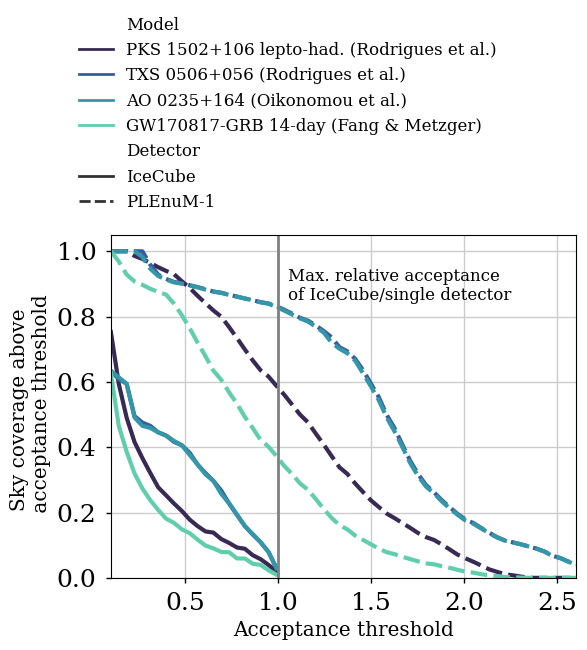

In [258]:
threshold_fractions_df = pd.read_pickle(join(st.LOCALPATH, "alert_acceptance_models.pickle"))
c6 = list(sns.color_palette("mako", n_colors=4))
c6.extend(list(sns.color_palette("Reds", n_colors=2)))

f, ax = plt.subplots(figsize=(6, 7))
ax = sns.lineplot(
    data=threshold_fractions_df,
    y="Threshold Fraction",
    x="Threshold",
    hue="Model",
    style="Detector", lw=3, ax=ax, palette=c6
)
ax.set_xlabel("Acceptance threshold", fontsize="x-large")
ax.set_ylabel("Sky coverage above \n acceptance threshold", fontsize="x-large")
ax.set_ylim(0, None)
ax.set_xlim(acc_threshs[0], acc_threshs[-1])
ax.axvline(1, color="gray")
ax.text(
    1.05, 0.85, "Max. relative acceptance \nof IceCube/single detector", fontsize="large", #rotation="vertical"
)
f.subplots_adjust(top=0.6)
ax.legend(
    loc="upper left",
    frameon=False,
    fontsize="large",
    #ncol=2,
   bbox_to_anchor=(-0.1, 1.68),
    columnspacing=0.8,
)
#f.tight_layout()
f.savefig(
    join(st.BASEPATH, "plots/icrc2023/alert_sky-coverage.pdf"), bbox_inches="tight"
)

### including generic PL

In [161]:
more_models = deepcopy(selected_models)
more_models[r"PL $\gamma=-2$"] = -2
more_models[r"PL $\gamma=-3$"] = -3

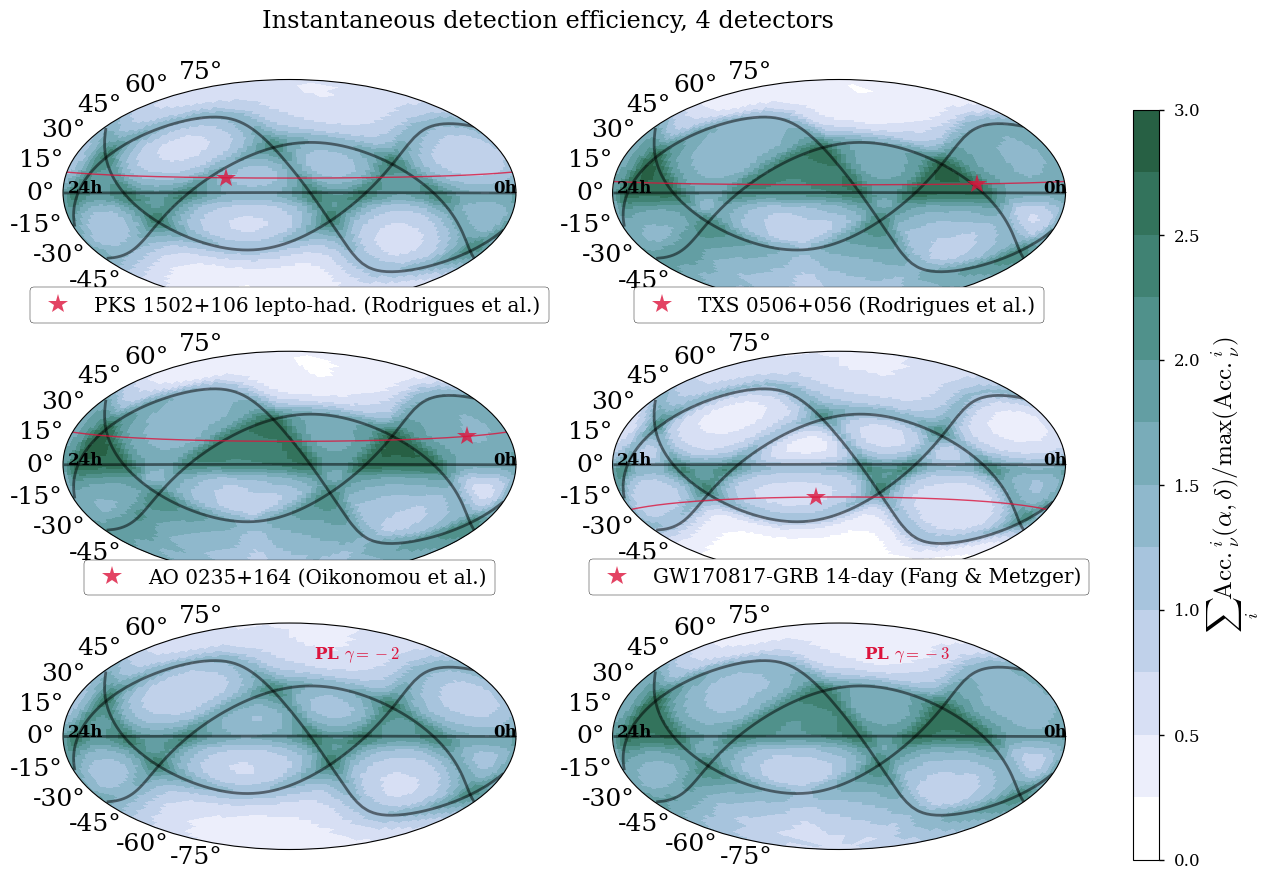

In [202]:
### four detectors together
light_color = "k"
key = "IceCube"  # that's just baseline for rotation
fig = plt.figure(figsize=(13, 10))
make_legend = True
aeff_factor = calc_aeff_factor(aeff_2d_full[key], **_config)
n2ind = [321, 322, 323, 324, 325, 326]

verbose = False

if verbose:
    f2, axes2 = plt.subplots()
    f3, axes3 = plt.subplots()

bins2 = np.linspace(0, 1, num=200)
bins3 = np.linspace(0, 3, num=200)

acc_threshs = np.linspace(0.1, 2.6, num=60)
detector_keys = ["IceCube", "P-ONE", "KM3NeT", "Baikal-GVD"]
tf_tmp = []

for ii, dkey in enumerate(more_models):
    if "PL" in dkey:
        k_s = energy_smearing(
            baseline_eres,
            aeff_factor * (10**st.logE_mids / st.E_NORM) ** more_models[dkey],
        )
    else:
        k_s = energy_smearing(
            baseline_eres,
            aeff_factor
            * 10 ** more_models[dkey]["model"]["model_spline"](st.logE_mids),
        )

    # simple alert threshold of 100 TeV
    k_s.histo[:, st.logE_reco_mids < 5] = 0
    grid2d, _ = setup_aeff_grid(
        [k_s.sum(axis=1)], st.sindec_mids, st.ra_mids, st.ra_width, log_int=False
    )
    time = Time("2023-6-21 00:00:00")
    inst_ev = np.zeros_like(eq_coords.ra.rad)
    ax = fig.add_subplot(n2ind[ii], projection="hammer", rasterized=True)

    for ident in detector_keys:
        loc = EarthLocation(lat=st.poles[ident]["lat"], lon=st.poles[ident]["lon"])
        # arbitrary time, doesnt matter here
        # transform integration coordinates to local frame
        local_coords_grid = eq_coords.transform_to(AltAz(obstime=time, location=loc))
        tmp = grid2d[0]((local_coords_grid.alt.rad, local_coords_grid.az.rad))
        tmp /= np.max(tmp)

        inst_ev += tmp
        add_local_horizon(time, loc, ax, c="k", alpha=0.5, lw=2)
        if ident == "IceCube":
            if verbose:
                sns.histplot(
                    inst_ev.flatten(),
                    bins=bins2,
                    label=dkey + ", IceCube",
                    alpha=0.3,
                    ax=axes2,
                    cumulative=True,
                    stat="density",
                )
            h, ed = np.histogram(inst_ev.flatten(), bins=bins2)
            hc = np.cumsum(h) / np.sum(h, dtype=float)  # normalize to 1
            for at in acc_threshs:
                if at < 1:
                    threshold_fraction = hc[ed[:-1] >= at][0]
                    if verbose:
                        axes2.axhline(threshold_fraction)
                    tf_tmp.append(
                        {
                            "Model": dkey,
                            "Detector": "IceCube",
                            "Threshold": at,
                            "Threshold Fraction": 1 - threshold_fraction,
                        }
                    )
                    # print(dkey, "IceCube", at, threshold_fraction)
    if verbose:
        sns.histplot(
            inst_ev.flatten(),
            bins=bins3,
            label=dkey,
            alpha=0.3,
            ax=axes3,
            cumulative=True,
            stat="density",
        )
    h, ed = np.histogram(inst_ev.flatten(), bins=bins3)
    hc = np.cumsum(h) / np.sum(h, dtype=float)  # normalize to 1
    for at in acc_threshs:
        threshold_fraction = hc[ed[:-1] >= at][0]
        if verbose:
            axes3.axhline(threshold_fraction)
        tf_tmp.append(
            {
                "Model": dkey,
                "Detector": "PLEnuM-1",
                "Threshold": at,
                "Threshold Fraction": 1 - threshold_fraction,
            }
        )
        # print(dkey, "PLEnuM", at, threshold_fraction)

    cax = ax.pcolormesh(
        st.ra_mids - np.pi,
        np.arcsin(st.sindec_bins),
        inst_ev,
        cmap=cmap_sparse,
        vmin=0,
        vmax=3,
        zorder=0,
    )
    if not "PL" in dkey:
        add_src(
            ax,
            selected_models[dkey]["coords"],
            dec_line=True,
            marker="*",
            c="crimson",  # light_color,
            alpha=0.8,
            label=dkey,
            lw=1,
        )
        ax.legend(
            fontsize="x-large",
            loc="lower center",
            framealpha=1,
            edgecolor=(0, 0, 0, 1),
            # ncol=3,
            frameon=True,  # False,
            bbox_to_anchor=(0.5, -0.12),
        )
    else:
        ax.text(
            0.5,
            1,
            dkey,
            color="crimson",
            fontsize="large",
            weight="heavy",
        )

    ax.text(
        0.95,
        0.5,
        s="0h",
        transform=ax.transAxes,
        zorder=20,
        color="k",
        fontsize="large",
        weight="heavy",
    )
    ax.text(
        0.01,
        0.5,
        s="24h",
        transform=ax.transAxes,
        zorder=20,
        color="k",
        fontsize="large",
        weight="heavy",
    )
    ax.set_xticks([])
    ax.grid(False)


fig.suptitle(
    "Instantaneous detection efficiency, 4 detectors", fontsize="xx-large", y=0.95
)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(
    r"$\sum_{i} {\rm Acc.}^i_{\nu}(\alpha, \delta) / \max({\rm Acc.}^i_{\nu})$"
)
cbar.ax.tick_params(labelsize="large")
fig.savefig(
    join(st.BASEPATH, "plots/icrc2023/instant_det_efficiency_with-PL.pdf"),
    bbox_inches="tight",
)
if verbose:
    axes2.set_xlim(0, np.max(bins2))
    axes3.set_xlim(0, np.max(bins3))
    # axes2.set_xscale("symlog", linthresh=1e-3)
    for at in acc_threshs:
        if at < 1:
            axes2.axvline(at)
        axes3.axvline(at)
    axes2.legend(fontsize="small")
    axes3.legend(fontsize="small")

pd.DataFrame(tf_tmp).to_pickle(join(st.LOCALPATH, "alert_acceptance_models_with-PL.pickle"))

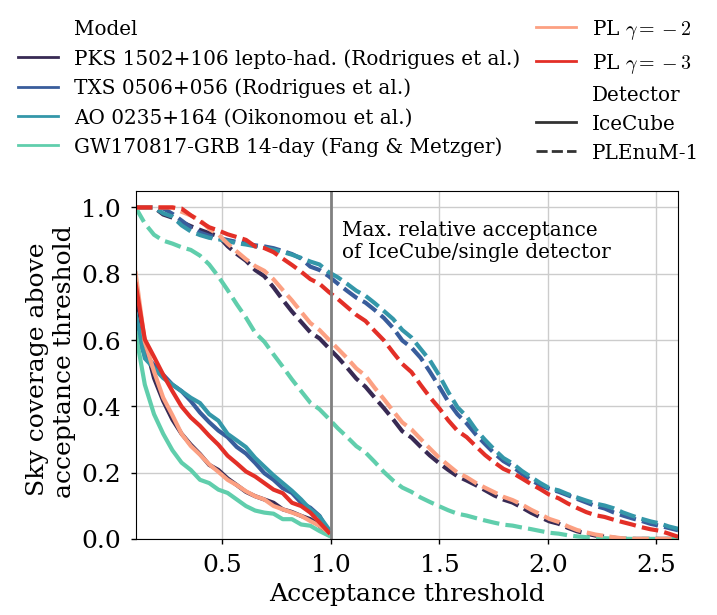

In [207]:
threshold_fractions_df = pd.read_pickle(join(st.LOCALPATH, "alert_acceptance_models_with-PL.pickle"))
c6 = list(sns.color_palette("mako", n_colors=4))
c6.extend(list(sns.color_palette("Reds", n_colors=2)))

f, ax = plt.subplots(figsize=(7, 12))
ax = sns.lineplot(
    data=threshold_fractions_df,
    y="Threshold Fraction",
    x="Threshold",
    hue="Model",
    style="Detector", lw=3, ax=ax, palette=c6
)
ax.set_xlabel("Acceptance threshold")
ax.set_ylabel("Sky coverage above \n acceptance threshold")
ax.set_ylim(0, None)
ax.set_xlim(acc_threshs[0], acc_threshs[-1])
ax.axvline(1, color="gray")
ax.text(
    1.05, 0.85, "Max. relative acceptance \nof IceCube/single detector", fontsize="x-large", #rotation="vertical"
)
ax.legend(
    loc="upper left",
    frameon=False,
    fontsize="x-large",
    ncol=2,
    bbox_to_anchor=(-0.25, 1.55),
    columnspacing=0.8,
)
#f.tight_layout()
f.subplots_adjust(top=0.4)
f.savefig(
    join(st.BASEPATH, "plots/icrc2023/alert_sky-coverage_with-PL.pdf"), bbox_inches="tight"
)

## powerlaw model

1979.8835799930725
1042.7338693371128
2705.592994364427
16903.649860690697


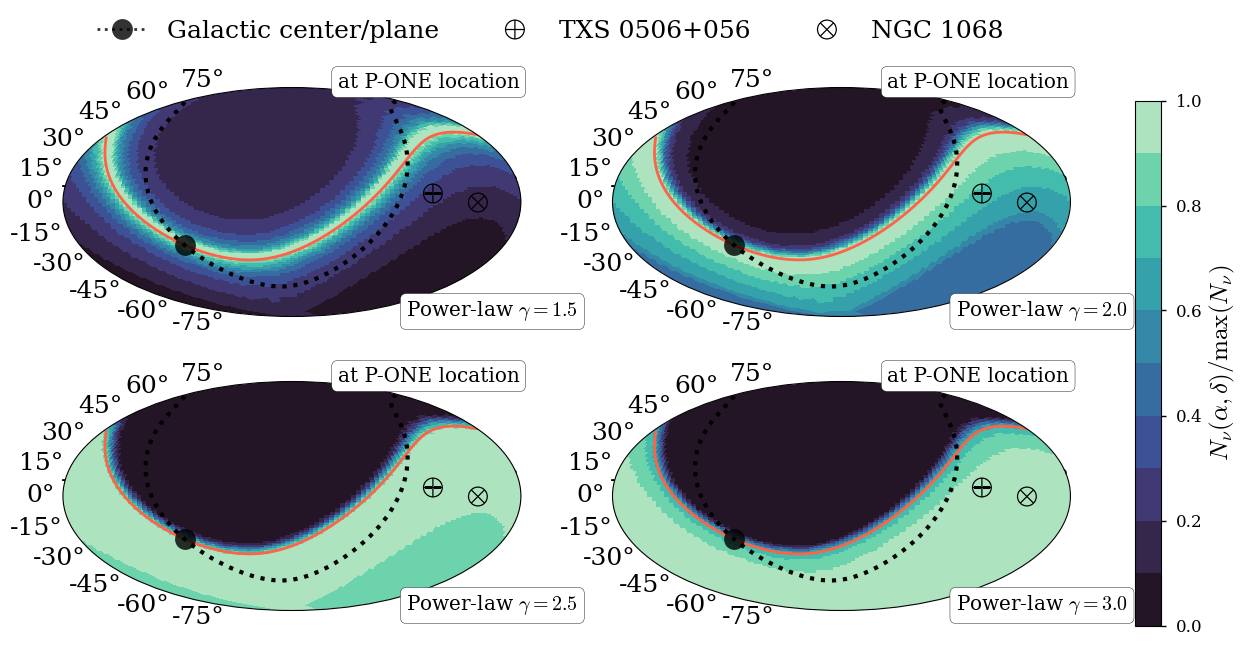

In [205]:
key = "IceCube"
fig = plt.figure(figsize=(13, 7))
make_legend = True
aeff_factor = calc_aeff_factor(aeff_2d_full[key], **_config)
n2ind = {"2.0": 221, "2.3": 222, "2.7": 223, "3.0": 224}
n2ind = [221, 222, 223, 224]



for ii, gamma in enumerate(np.arange(1.5, 3.1, step=0.5)):
    diffuse_flux = PL_flux(1e-18, gamma, 1e5, "powerlaw")

    k_s = astro_flux(
        aeff_factor,
        st.emids,
        energy_resolution=baseline_eres,
        phi_scaling=1,
        flux_shape=diffuse_flux,
    )

    print(np.sum(k_s))
    k_s /= np.sum(k_s) # normalize to 1
    
    grid2d, _ = setup_aeff_grid(
        [k_s.sum(axis=1)], st.sindec_mids, st.ra_mids, st.ra_width, log_int=False
    )
    

    loc = EarthLocation(lat=st.poles["P-ONE"]["lat"], lon=st.poles["P-ONE"]["lon"])
    # arbitrary time, doesnt matter here
    time = Time("2023-6-21 00:00:00")
    

    # transform integration coordinates to local frame
    local_coords_grid = eq_coords.transform_to(AltAz(obstime=time, location=loc))
    inst_ev = grid2d[0]((local_coords_grid.alt.rad, local_coords_grid.az.rad))
    #if ii == 0:
    max_ev = np.max(inst_ev) 
    normalized_inst_ev = inst_ev / max_ev # normalize to best acceptance for hardest gamma

    ax = fig.add_subplot(n2ind[ii], projection="hammer", rasterized=True)
    cax = ax.pcolormesh(
        st.ra_mids - np.pi,
        np.arcsin(st.sindec_bins),
        normalized_inst_ev,
        cmap=cmap,
        vmin=0,
        vmax=1,
        # norm=LogNorm(vmin=1e-2, vmax=1),
    )
    add_local_horizon(time, loc, ax)
    # add the galactic center and plane
    if make_legend:
        add_plane(ax, color="black")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")
        make_legend = False
    else:
        add_plane(ax, color="black", label="__None__")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", label="__None__")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", label="__None__")
    ax.text(
        0.6,
        1.0,
        st.poles["P-ONE"]["label"],
        fontsize="x-large",
        transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
    ax.text(
        0.75,
        0,
        rf"Power-law $\gamma={diffuse_flux.gamma}$",  # ,~t=t_0$",
        transform=ax.transAxes,
        fontsize="x-large",
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
fig.legend(
    # fontsize="small",
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.9),
)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(r"$N_{\nu}(\alpha, \delta) / \max(N_{\nu})$")
cbar.ax.tick_params(labelsize="large")
# fig.savefig(join(st.BASEPATH, "plots/skymaps_local_time.pdf"), bbox_inches="tight")

## Generic log-parabola

1042.7338693371128
3.827710020303735
193.0762536825159
6581.9619468231995


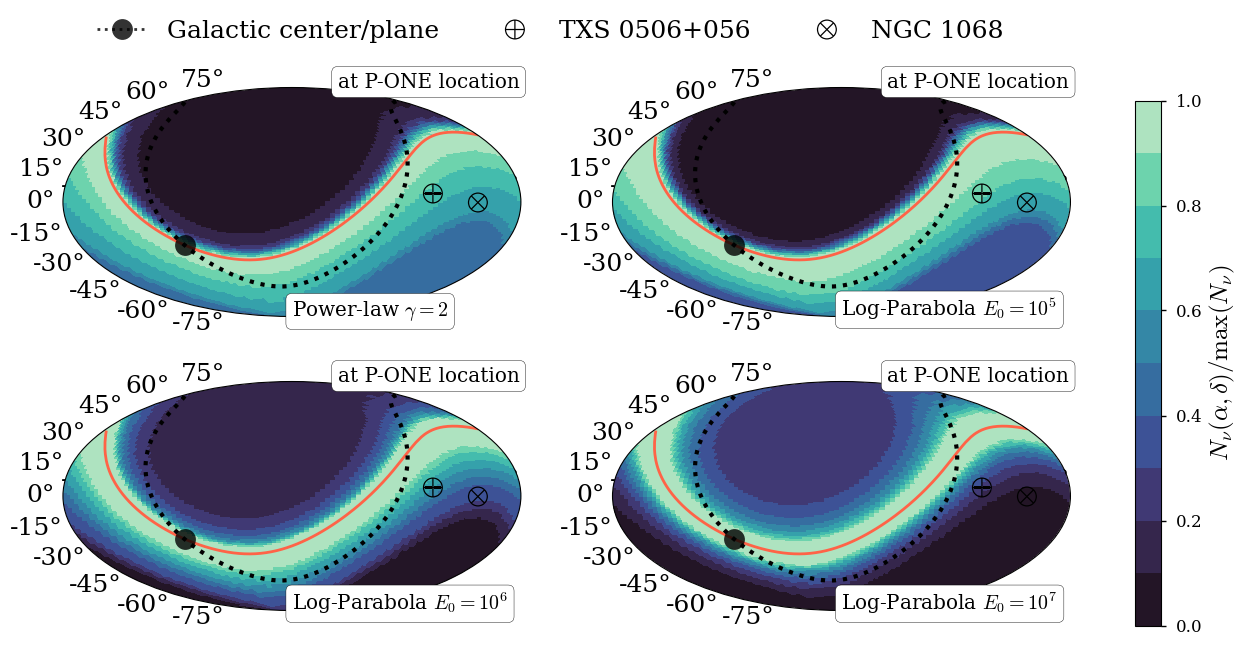

In [70]:
key = "IceCube"
fig = plt.figure(figsize=(13, 7))
make_legend = True
aeff_factor = calc_aeff_factor(aeff_2d_full[key], **_config)
n2ind = {"2.0": 221, "2.3": 222, "2.7": 223, "3.0": 224}
n2ind = [221, 222, 223, 224]

for ii, e_0 in enumerate([0, 1e5, 1e6, 1e7]):
    if e_0 == 0:
        diffuse_flux = PL_flux(1e-18, 2, 1e5, "powerlaw")
    else:
        diffuse_flux = LogP_flux(1e-20, Alpha, Beta, e_0, "log-parabola")

    k_s = astro_flux(
        aeff_factor,
        st.emids,
        energy_resolution=baseline_eres,
        phi_scaling=1,
        flux_shape=diffuse_flux,
    )

    print(np.sum(k_s))
    k_s /= np.sum(k_s)
    grid2d, _ = setup_aeff_grid(
        [k_s.sum(axis=1)], st.sindec_mids, st.ra_mids, st.ra_width, log_int=False
    )
    loc = EarthLocation(lat=st.poles["P-ONE"]["lat"], lon=st.poles["P-ONE"]["lon"])
    # arbitrary time, doesnt matter here
    time = Time("2023-6-21 00:00:00")
    # transform integration coordinates to local frame
    local_coords_grid = eq_coords.transform_to(AltAz(obstime=time, location=loc))
    inst_ev = grid2d[0]((local_coords_grid.alt.rad, local_coords_grid.az.rad))
    if ii == 0:
        max_ev = np.max(inst_ev)
    normalized_inst_ev = inst_ev / max_ev

    ax = fig.add_subplot(n2ind[ii], projection="hammer", rasterized=True)
    cax = ax.pcolormesh(
        st.ra_mids - np.pi,
        np.arcsin(st.sindec_bins),
        normalized_inst_ev,
        cmap=cmap,
        vmin=0,
        vmax=1,
        # norm=LogNorm(vmin=1e-2, vmax=1),
    )
    add_local_horizon(time, loc, ax)
    # add the galactic center and plane
    if make_legend:
        add_plane(ax, color="black")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")
        make_legend = False
    else:
        add_plane(ax, color="black", label="__None__")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", label="__None__")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", label="__None__")
    ax.text(
        0.6,
        1.0,
        st.poles["P-ONE"]["label"],
        fontsize="x-large",
        transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
    ax.text(
        0.5,
        0,
s= rf"Power-law $\gamma={diffuse_flux.gamma}$" if e_0 == 0 else rf"Log-Parabola $E_0=10^{{{np.log10(diffuse_flux.E0):1.0f}}}$",
        transform=ax.transAxes,
        fontsize="x-large",
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
fig.legend(
    # fontsize="small",
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.9),
)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(r"$N_{\nu}(\alpha, \delta) / \max(N_{\nu})$")
cbar.ax.tick_params(labelsize="large")
# fig.savefig(join(st.BASEPATH, "plots/skymaps_local_time.pdf"), bbox_inches="tight")

# Blazar flare stats

In [71]:
from astropy.cosmology import Planck18
Planck18.luminosity_distance(0.3365) # TXS 0506+056

<Quantity 1830.08071709 Mpc>

## load template

(10.0, 1000000.0)

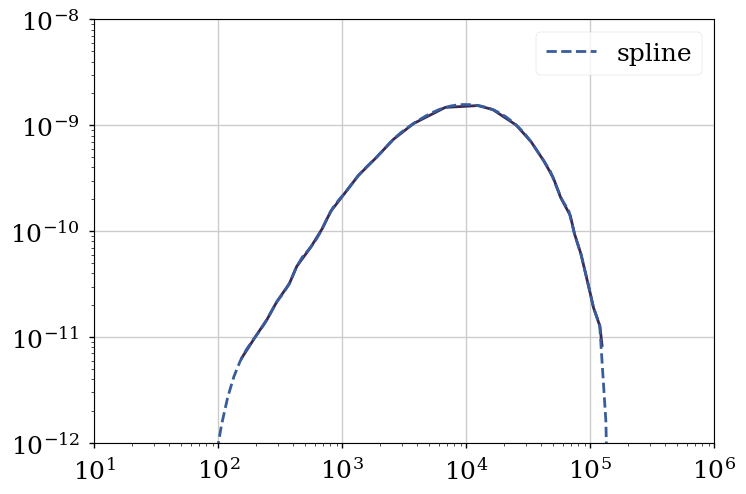

In [72]:
# blazar model by Keivani et al. arXiv:1807.04537
txs_lmbb2b = pd.read_csv("/home/hpc/capn/capn102h/repos/Plenum/local/neutrino_models/LMBB2B_other.txt", sep=" ")

txs_spline = InterpolatedUnivariateSpline(
    np.log10(txs_lmbb2b["Energy/TeV"]) + 3,  # translate from TeV -> GeV
    np.log10(
        txs_lmbb2b["allFlavourNeutrinoFlux/(erg/cm2/s)"] * erg_to_GeV / 3 / ((txs_lmbb2b["Energy/TeV"]*1E3) ** 2)
    ),  # translate from E^2 Phi to Phi, and from all-flavor to muon only
)
f, ax = plt.subplots()
plt.plot(txs_lmbb2b["Energy/TeV"], txs_lmbb2b["allFlavourNeutrinoFlux/(erg/cm2/s)"] * erg_to_GeV)
ax.plot(10**(st.logE_mids - 3), 3 * 10**(txs_spline(st.logE_mids) +  2*st.logE_mids), label="spline", ls="--")
ax.loglog()
ax.legend()
ax.set_ylim(1E-12, 1E-8)
ax.set_xlim(1E1, 1E6)

## load flare cycle

In [73]:
# flaring duty cycle of blazars by Yoshida et al. (incl. Foteini) arXiv:2210.10011
flare_stats = pd.read_csv(
    "/home/hpc/capn/capn102h/repos/Plenum/local/neutrino_models/f_bfl_qb.csv",
    skipinitialspace=True,
)

mask = np.isfinite(flare_stats.z)
flare_stats["luminosity_distance/Mpc (Planck18)"] = -1
flare_stats.loc[
    mask, "luminosity_distance/Mpc (Planck18)"
] = Planck18.luminosity_distance(flare_stats.loc[mask, "z"])
flare_stats["relative_luminosity_distance"] = 0
flare_stats["relative_qb"] = 0

txs_stats = flare_stats[flare_stats.ASSOC == "TXS 0506+056"].iloc[0]

flare_stats.loc[mask, "relative_luminosity_distance"] = (
    txs_stats["luminosity_distance/Mpc (Planck18)"] ** 2
    / flare_stats.loc[mask, "luminosity_distance/Mpc (Planck18)"] ** 2
)

flare_stats.loc[mask, "relative_qb"] = flare_stats.loc[mask, "qb"] / txs_stats["qb"]

flare_stats["dL_model_spline"] = None
flare_stats["qb_model_spline"] = None
fsrq_mask = (flare_stats["Optical Class"] == "FSRQ") | (
    flare_stats.ASSOC == "TXS 0506+056"
)

for ii, row in flare_stats.loc[fsrq_mask].iterrows():
    flare_stats.loc[ii, "qb_model_spline"] = InterpolatedUnivariateSpline(
        st.logE_mids,
        txs_spline(st.logE_mids)
        + np.log10(flare_stats.loc[ii, "relative_qb"]),
    ) # because f*ck you, that's why :|

for ii, row in flare_stats.loc[fsrq_mask].iterrows():
    flare_stats.loc[ii, "dL_model_spline"] = InterpolatedUnivariateSpline(
        st.logE_mids,
        txs_spline(st.logE_mids)
        + np.log10(flare_stats.loc[ii, "relative_luminosity_distance"]),
    ) # because f*ck you, that's why :|

txs_stats = flare_stats[flare_stats.ASSOC == "TXS 0506+056"].iloc[
    0
]  # update with the new calculations for cross checks

(100.0, 1000000000.0)

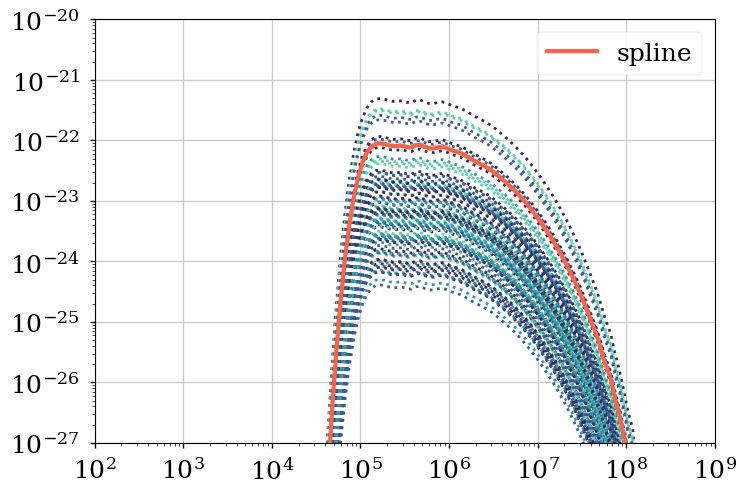

In [74]:
# comparing to original spline as cross check
f, ax = plt.subplots()
ax.plot(10**(st.logE_mids), 10**txs_spline(st.logE_mids), label="spline", ls="-", color="tomato", lw=3, zorder=100)
for ii, row in flare_stats.loc[fsrq_mask].iterrows():
    ax.plot(10**(st.logE_mids), 10**row["dL_model_spline"](st.logE_mids), ls=":")
ax.loglog()
ax.legend()
ax.set_ylim(1E-27, 1E-20)
ax.set_xlim(1E2, 1E9)

In [245]:
flare_stats.loc[fsrq_mask]

4FGL Name         ASSOC   RAJ2000  DEJ2000 Optical Class  \
3    4FGL J1229.0+0202        3C 273  187.2680   2.0454          FSRQ   
4    4FGL J1256.1-0547        3C 279  194.0420  -5.7887          FSRQ   
5    4FGL J1642.9+3948        3C 345  250.7340  39.8164          FSRQ   
6    4FGL J2225.7-0457        3C 446  336.4320  -4.9537          FSRQ   
7    4FGL J2253.9+1609      3C 454.3  343.4960  16.1506          FSRQ   
..                 ...           ...       ...      ...           ...   
138  4FGL J0509.4+0542  TXS 0506+056   77.3593   5.7014           BLL   
139  4FGL J0648.4-1743  TXS 0646-176  102.1110 -17.7231          FSRQ   
141  4FGL J1700.0+6830  TXS 1700+685  255.0210  68.5042          FSRQ   
142  4FGL J2244.2+4057  TXS 2241+406  341.0610  40.9597          FSRQ   
143  4FGL J0001.5+2113  TXS 2358+209    0.3815  21.2183          FSRQ   

    SED Class       z     f_fl    b_fl        qb        qb_err  \
3         LSP  0.1580  0.10700  0.3350  0.000028  9.781250e-07   
4         LSP  0.5360  0.24500  0.6430  0.000034  1.899210e-06   
5         LSP  0.5930  0.00691  0.0323  0.000027  1.271240e-06   
6         LSP  1.4040  0.00000  0.0000  0.000023  1.339450e-06   
7         LSP  0.8590  0.51200  0.8140  0.000025  2.113650e-06   
..        ...     ...      ...     ...       ...           ...   
138       ISP  0.3365  0.01220  0.0590  0.000057  2.717410e-06   
139       LSP  1.2320  0.01220  0.0376  0.000048  2.481390e-06   
141       LSP  0.3010  0.02370  0.0838  0.000018  1.179520e-06   
142       LSP  1.1710  0.03200  0.1160  0.000027  2.797800e-06   
143       ISP  1.1060  0.01860  0.0548  0.000028  1.301980e-06   

     luminosity_distance/Mpc (Planck18)  relative_luminosity_distance  \
3                            780.042505                      5.504324   
4                           3173.475681                      0.332560   
5                           3584.639729                      0.260645   
6                          10317.994832                      0.031459   
7                           5633.096317                      0.105547   
..                                  ...                           ...   
138                         1830.080717                      1.000000   
139                         8783.249236                      0.043414   
141                         1608.670461                      1.294215   
142                         8250.152126                      0.049206   
143                         7689.176737                      0.056648   

     relative_qb                                    dL_model_spline  \
3       0.490197  <scipy.interpolate._fitpack2.InterpolatedUniva...   
4       0.600384  <scipy.interpolate._fitpack2.InterpolatedUniva...   
5       0.471037  <scipy.interpolate._fitpack2.InterpolatedUniva...   
6       0.396514  <scipy.interpolate._fitpack2.InterpolatedUniva...   
7       0.446494  <scipy.interpolate._fitpack2.InterpolatedUniva...   
..           ...                                                ...   
138     1.000000  <scipy.interpolate._fitpack2.InterpolatedUniva...   
139     0.852365  <scipy.interpolate._fitpack2.InterpolatedUniva...   
141     0.315277  <scipy.interpolate._fitpack2.InterpolatedUniva...   
142     0.477485  <scipy.interpolate._fitpack2.InterpolatedUniva...   
143     0.493997  <scipy.interpolate._fitpack2.InterpolatedUniva...   

                                       qb_model_spline  
3    <scipy.interpolate._fitpack2.InterpolatedUniva...  
4    <scipy.interpolate._fitpack2.InterpolatedUniva...  
5    <scipy.interpolate._fitpack2.InterpolatedUniva...  
6    <scipy.interpolate._fitpack2.InterpolatedUniva...  
7    <scipy.interpolate._fitpack2.InterpolatedUniva...  
..                                                 ...  
138  <scipy.interpolate._fitpack2.InterpolatedUniva...  
139  <scipy.interpolate._fitpack2.InterpolatedUniva...  
141  <scipy.interpolate._fitpack2.InterpolatedUniva...  
142  <scipy.interpolate._fitpack2.Interpola

(100.0, 1000000000.0)

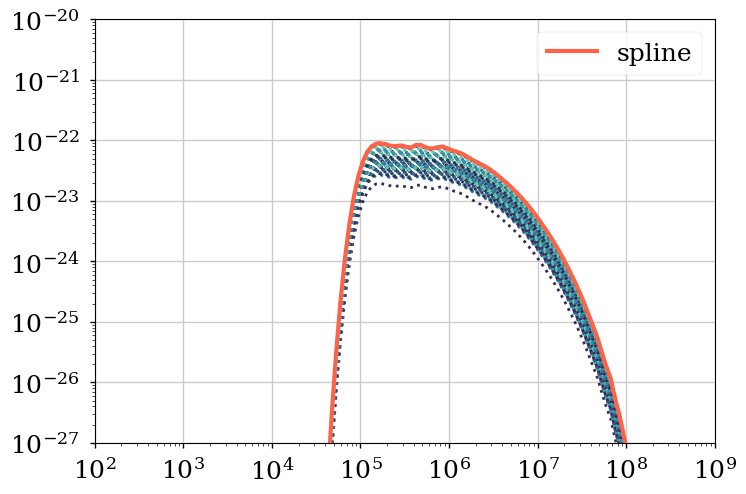

In [75]:
# comparing to original spline as cross check
f, ax = plt.subplots()
ax.plot(10**(st.logE_mids), 10**txs_spline(st.logE_mids), label="spline", ls="-", color="tomato", lw=3, zorder=100)
for ii, row in flare_stats.loc[fsrq_mask].iterrows():
    ax.plot(10**(st.logE_mids), 10**row["qb_model_spline"](st.logE_mids), ls=":")
ax.loglog()
ax.legend()
ax.set_ylim(1E-27, 1E-20)
ax.set_xlim(1E2, 1E9)

## Blazar stacking - significance

In [246]:
# index of energy treshold = 100 TeV
key = "IceCube"
verbose = False
for model_key, key in product(
    ["qb_model_spline", "dL_model_spline"], ["IceCube", "Plenum-1", "Plenum-2"]
):
    print(model_key, key)
    stacked_mu_s = []
    stacked_mu_b = []
    stacked_k = []

    for ii, series in flare_stats.loc[fsrq_mask].iterrows():
        # setup config
        conf = detector_configurations[key]
        current_bg_config = deepcopy(bg_config)
        current_bg_config["livetime"] = (
            10*365*24*3600 * series["f_fl"]
        )  # flaring duty cycle
        current_bg_config["dec"] = np.deg2rad(series["DEJ2000"])

        current_src_config = deepcopy(src_config)
        current_src_config["livetime"] = (
            10*365*24*3600 * series["f_fl"]
        )  # flaring duty cycle
        current_src_config["dec"] = np.deg2rad(series["DEJ2000"])

        all_mu_s, all_mu_b, all_k = setup_multi_model_llh(
            improved_eres,
            conf,
            bg_config=current_bg_config,
            sig_config=current_src_config,
            model_spline=series[model_key],
            verbose=verbose,
        )
        if "0506" in series.ASSOC:
            print("N_nu TXS:", np.sum(all_mu_s))

        stacked_k.extend(all_k)
        stacked_mu_b.extend(all_mu_b)
        stacked_mu_s.extend(all_mu_s)

    local_llh = lambda x: model_llh_multi(
        (x[0], 0), stacked_mu_s, stacked_mu_b, stacked_k
    )
    global_llh = lambda x: model_llh_multi(x, stacked_mu_s, stacked_mu_b, stacked_k)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )

    # this fit is not really needed, but good for crosschecking the minimization
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1),
        approx_grad=True,
    )

    pval = chi2.sf(
        out_bckg[1] - out_comp[1], 1
    )  # atmo(n) vs atmo(n) + signal(n) = 1 ndof
    significance = norm.isf(pval / 2)

    if True:  # significance > 0:
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        print("Signal:", np.sum(stacked_mu_s))
        print("Background:", np.sum(stacked_mu_b))
        print("Atmo-only normalization:", out_bckg[0])
        print("Signal fit parameters:", out_comp[0])

        print(
            "TS check:",
            global_llh((1, 1)),
            "(fit: ",
            out_comp[1],
            ")",
            "(bckg: ",
            out_bckg[1],
            ")",
        )
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

        print(" - " * 3)

qb_model_spline IceCube
N_nu TXS: 0.009767059447816293
P-VALUE: 0.16085222986971712 SIGNIFICANCE: 1.4022110601305289
Signal: 0.5492410787623307
Background: 1324.6473484530145
Atmo-only normalization: [1.00041798]
Signal fit parameters: [1. 1.]
TS check: -10751684.306203054 (fit:  -10751684.306203054 ) (bckg:  -10751682.340007197 )
-2 Delta LLH: 1.9661958571523428
 -  -  - 
qb_model_spline Plenum-1
N_nu TXS: 0.01681268035485096
P-VALUE: 0.004357901985181343 SIGNIFICANCE: 2.8510215206930414
Signal: 2.1246467310136294
Background: 4623.762905501929
Atmo-only normalization: [1.00076653]
Signal fit parameters: [1. 1.]
TS check: -61068424.116045326 (fit:  -61068424.116045326 ) (bckg:  -61068415.987721615 )
-2 Delta LLH: 8.128323711454868
 -  -  - 
qb_model_spline Plenum-2
N_nu TXS: 0.08029856676565687
P-VALUE: 4.818309755498788e-06 SIGNIFICANCE: 4.572547053329113
Signal: 5.694713742968775
Background: 13233.97067044654
Atmo-only normalization: [1.00046861]
Signal fit parameters: [1. 1.]
TS che

## Blazar Stacking - discovery potential

In [247]:
thresholds = [st.sigma5, st.sigma3]
verbose = False
detector_keys = [
    "IceCube",
    # "P-ONE" ,
    "Plenum-1",
    "Plenum-2",
]


In [248]:
tmp = []
scaling_models = {
    "Quiescent flux": "qb_model_spline",
    "Luminosity distance": "dL_model_spline",
}

for model_key, ident in product(scaling_models, detector_keys):
    print(model_key, ident)
    stacked_mu_s = []
    stacked_mu_b = []
    stacked_k = []

    for ii, series in flare_stats.loc[fsrq_mask].iterrows():
        # setup config
        conf = detector_configurations[ident]
        current_bg_config = deepcopy(bg_config)
        current_bg_config["livetime"] = (
            10*365*24*3600 * series["f_fl"]
        )  # flaring duty cycle
        current_bg_config["dec"] = np.deg2rad(series["DEJ2000"])

        current_src_config = deepcopy(src_config)
        current_src_config["livetime"] = (
            10*365*24*3600 * series["f_fl"]
        )  # flaring duty cycle
        current_src_config["dec"] = np.deg2rad(series["DEJ2000"])

        all_mu_s, all_mu_b, all_k = setup_multi_model_llh(
            improved_eres,
            conf,
            bg_config=current_bg_config,
            sig_config=current_src_config,
            model_spline=series[scaling_models[model_key]],
            verbose=verbose,
        )
        if "0506" in series.ASSOC:
            print("N_nu TXS:", np.sum(all_mu_s))

        stacked_k.extend(all_k)
        stacked_mu_b.extend(all_mu_b)
        stacked_mu_s.extend(all_mu_s)

    scaler = 5 / np.sum(stacked_mu_s)
    current_thresholds = copy(thresholds)
    count = 0

    # calculate the significance with various flux scalings to obtain
    # the 5-sigma discovery threshold by interpolation
    while len(current_thresholds) > 0:
        current_mu_s = [mus * scaler for mus in stacked_mu_s]
        current_k_i = [ks + kb for ks, kb in zip(current_mu_s, stacked_mu_b)]

        local_llh = lambda x: model_llh_multi(
            (x[0], 0), current_mu_s, stacked_mu_b, current_k_i
        )
        global_llh = lambda x: model_llh_multi(
            x, current_mu_s, stacked_mu_b, current_k_i
        )

        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1,),
            approx_grad=True,
        )

        # this fit is not really needed, but good for crosschecking the minimization
        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1),
            approx_grad=True,
        )

        pval = chi2.sf(
            out_bckg[1] - out_comp[1], 1
        )  # atmo(n) vs atmo(n) + signal(n) = 1 ndof
        significance = norm.isf(pval / 2)
        tmp_dct = {
            "ident": ident,
            "fancy_label": st.poles[ident]["label"],
            "model": model_key,
            "scaler": scaler,
            "cur_thresh": current_thresholds[0],
            "SosB": np.sum(current_mu_s) / np.sqrt(np.sum(stacked_mu_b)),
            "SoB": np.sum(current_mu_s) / np.sum(stacked_mu_b),
            "n_b": np.sum(stacked_mu_b),
            "n_sig": np.sum(current_mu_s),
            "p": pval,
            "log10(p)": -np.log10(pval),
        }
        if np.isnan(tmp_dct["p"]) and optimize:
            print(out_bckg[1], out_comp[1], out_bckg[1] - out_comp[1], tmp_dct["p"])
            raise ValueError(">:O")
        tmp.append(tmp_dct)
        tmp_df = pd.DataFrame(tmp)
        mask = (
            (tmp_df.ident == ident)
            & (tmp_df.model == model_key)
            & (tmp_df.cur_thresh == current_thresholds[0])
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask],
            current_thresholds,
            scaler,
            stop_here=1,
            stepper=1.3,
            min_steps=3,
            nmax=10,
        )

        if scaler == -1:
            break
df = pd.DataFrame(tmp)
df.to_pickle(join(st.LOCALPATH, "blazar_stacking.pickle"))

Quiescent flux IceCube


N_nu TXS: 0.009767059447816293
Quiescent flux Plenum-1
N_nu TXS: 0.01681268035485096
Quiescent flux Plenum-2
N_nu TXS: 0.08029856676565687
Luminosity distance IceCube
N_nu TXS: 0.009767059447816293
Luminosity distance Plenum-1
N_nu TXS: 0.01681268035485096
Luminosity distance Plenum-2
N_nu TXS: 0.08029856676565687


### plotting

[]

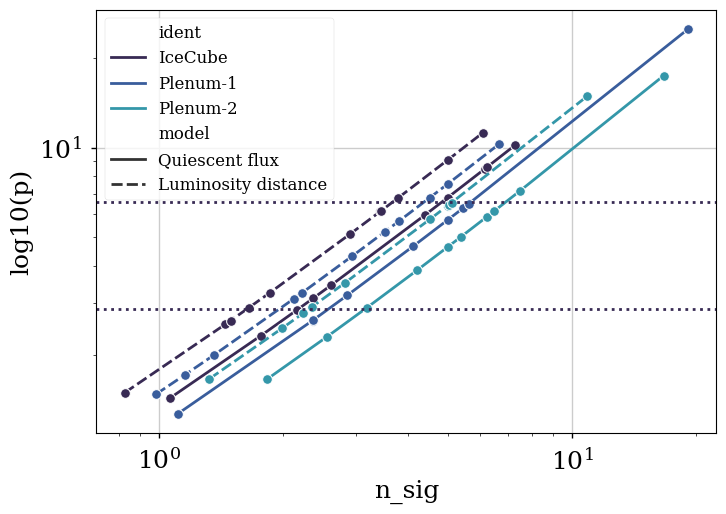

In [249]:
df = pd.read_pickle(join(st.LOCALPATH, "blazar_stacking.pickle"))
xname = "n_sig"  # "scaler" # "SoB" # "SosB" #
f, ax = plt.subplots()
ax = sns.lineplot(
    data=df,
    ax=ax,
    # data=tmp_df.loc[mask],
    y="log10(p)",
    x=xname,
    marker="o",
    style="model",
    hue="ident",
)
for t in thresholds:
    plt.axhline(-np.log10(t), ls=":")
plt.legend(fontsize="large")
ax.loglog()

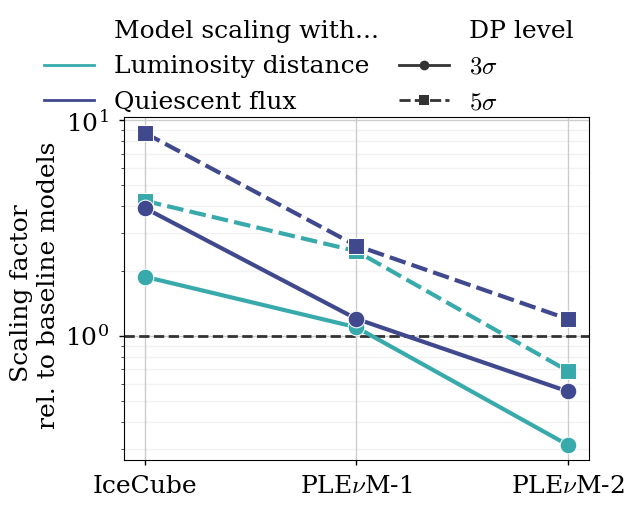

In [250]:
df = pd.read_pickle(join(st.LOCALPATH, "blazar_stacking.pickle"))
key_y = "scaler"
level_keys = {r"$3\sigma$": st.sigma3, r"$5\sigma$": st.sigma5}
tmp = []
for ii, k in enumerate(level_keys):
    flux = pd.DataFrame(
        df.groupby(["fancy_label", "model"]).apply(
            lambda x: get_scaler(x, level_keys[k], key_y=key_y)
        ),
        columns=[key_y],
    ).reset_index()

    flux["DP level"] = k
    tmp.append(flux)

flux = pd.concat(tmp, ignore_index=True)
flux.rename(columns={"model": "Model scaling with..."}, inplace=True)
f, ax = plt.subplots(figsize=(6, 7))
sns.lineplot(
    flux,
    x="fancy_label",
    y=key_y,
    style="DP level",
    hue="Model scaling with...",
    lw="3",
    palette="mako_r",
    markers=["o", "s", "d"],
    ms=12,
    ax=ax,
)
ax.set_yscale("log")
ax.axhline(1, ls="--", lw=2, color="0.2", zorder=1)
# ax.axes.legend_.remove()
ax.set_ylabel("Scaling factor \n rel. to baseline models")
ax.legend(
    loc="upper left",
    frameon=False,
    #fontsize="x-large",
    ncol=2,
    bbox_to_anchor=(-0.22, 1.35),
    columnspacing=0.8,
)
f.subplots_adjust(top=0.6)
ax.set_xlabel("")
ax.grid(True, which='minor', alpha=0.25)
f.savefig(
    join(st.BASEPATH, "plots/icrc2023/DP5_blazar_stacking.pdf"), bbox_inches="tight"
)

## Blazar - single sources

# - - - - - 

In [83]:
raise BaseException("BIS HIER HIN UND NICHT WEITER >:O")

BaseException: BIS HIER HIN UND NICHT WEITER >:O

# Generic Log-P analyses

## fixed fluence

In [ ]:
verbose = False
PHI_ref = 2e-22
tmp_flux = LogP_flux(PHI_ref, Alpha, Beta, E_para_norm, "log-parabola")
detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]

livetimes = np.array([10, 100, 365, 2*365, 1000, 5*365, 10*365]) * 24 * 3600
tmp = []
for dT in livetimes:
    T = float(dT) # whyyyy

    aeff_factor_signal = calc_aeff_factor(
        aeff_2d["IceCube"], dec=0, livetime=T, **src_config
    )

    k_s = astro_flux(
        aeff_factor_signal,
        st.emids,
        energy_resolution=baseline_eres,
        phi_scaling=1,
        flux_shape=tmp_flux,
    )

    current_flux = LogP_flux(
        PHI_ref / np.sum(k_s), Alpha, Beta, E_para_norm, "log-parabola"
    )

    for key in detector_keys:
        conf = detector_configurations[key]
        #print(key)
        current_bg_config = deepcopy(bg_config)
        current_bg_config["livetime"] = T
        current_bg_config["dec"] = 0

        current_src_config = deepcopy(src_config)
        current_src_config["livetime"] = T
        current_src_config["dec"] = 0

        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
        ) = setup_multi_llh(
            improved_eres,
            conf,
            bg_config=current_bg_config,
            sig_config=current_src_config,
            src_flux=current_flux,
        )

        dct = dict(
            shape="log-parabola",
            all_aeff_factor_s=all_aeff_factor_s,
            all_aeff_factor_b=all_aeff_factor_b,
            all_k=all_k,
            all_bckg_flux=all_bckg_flux,
            all_eres=all_eres,
            e_0=current_flux.E0,
            phi_0=current_flux.norm,
        )

        # fix signal normalization to 0
        local_llh = lambda x: ps_llh_multi((x[0], 0, 1, 1), **dct)
        global_llh = lambda x: ps_llh_multi(x, **dct)

        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1,),
            approx_grad=True,
        )

        # this fit is not really needed, but good for crosschecking the minimization
        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, logp_flux.alpha, logp_flux.beta),
            approx_grad=True,
        )
        

        pval = chi2.sf(
            out_bckg[1] - out_comp[1], 3
        )  # atmo(n) vs atmo(n) + signal(n, alpha, beta) = 3 ndof
        significance = norm.isf(pval/2)
        if verbose:
            print("Atmo-only normalization:", out_bckg[0])
            print("Signal fit parameters:", out_comp[0])
            print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
            print(
            "TS check:",
            global_llh((1, 1, logp_flux.alpha, logp_flux.beta)),
            "(fit: ",
            out_comp[1],
            ")",
        )
            print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
            print()

        tmp.append({
            "livetime": dT,
            "pval": pval,
            "significance": significance,
            "detector": key
        })
df = pd.DataFrame(tmp)

<Axes: xlabel='livetime', ylabel='significance'>

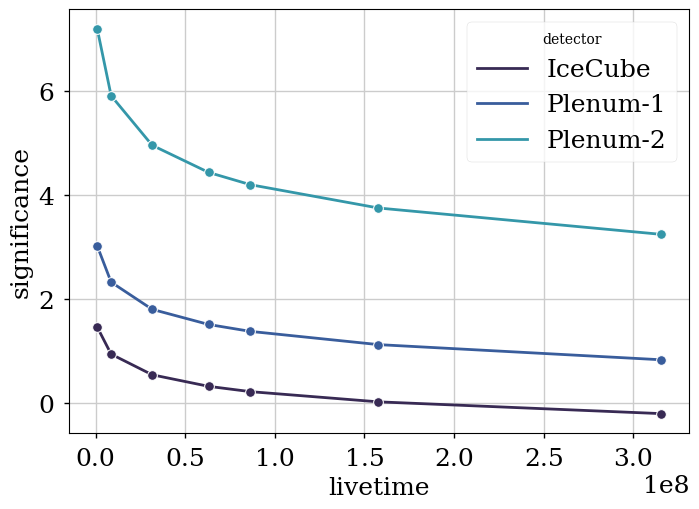

In [ ]:
sns.lineplot(df, x="livetime", y="significance", hue="detector", marker="o")

## discovery potential

fix the livetime and see which fluxes can be discovered

In [ ]:
thresholds = [st.sigma5]

PHI_ref = 2e-22
ref_flux = LogP_flux(PHI_ref, Alpha, Beta, E_para_norm, "log-parabola")

detector_keys = [
    "IceCube" ,
    #"P-ONE" ,
    "Plenum-1",
    "Plenum-2",
]
decs = [-30, 0, 30]
livetimes = np.array([10, 100, 1000,]) * 24 * 3600 #np.array([10, 100, 365, 2*365, 1000, 5*365, 10*365]) * 24 * 3600

tmp = []  # save output here

for ident, dT, d_dec in product(detector_keys, livetimes, decs):
    dec = np.deg2rad(d_dec)
    T = float(dT) # whyyyy
    conf = detector_configurations[ident]
    if "IceCube" in ident and dec < np.deg2rad(-5):
        # skip the Southern Hemisphere
        continue

    # insert the declination into the configs
    cur_bg_conf = bg_config.copy()
    cur_bg_conf["livetime"] = T
    cur_bg_conf["dec"] = dec

    cur_sig_conf = src_config.copy()
    cur_sig_conf["livetime"] = T
    cur_sig_conf["dec"] = dec

    # set up all ingredients for the multi-sample likelihood calculation
    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
        all_k_b,
        all_k_s,
    ) = setup_multi_llh(
        energy_reso["improved"],  # select one resolution for all data sets
        conf,
        bg_config=cur_bg_conf,
        sig_config=cur_sig_conf,
        return_s_b=True,
        src_flux=ref_flux
    )
    # calculate an estimate for the flux scaling
    scaler = 0.35 / (np.sum(all_k_s) / np.sqrt(np.sum(all_k_b)))
    current_thresholds = copy(thresholds)
    count = 0

    # calculate the significance with various flux scalings to obtain
    # the 5-sigma discovery threshold by interpolation
    while len(current_thresholds) > 0:
        # scale the number of signal events - equivalent to scaling the flux
        current_k_s = [ks * scaler for ks in all_k_s]
        current_k_i = [ks + kb for ks, kb in zip(current_k_s, all_k_b)]

        dct = dict(
            shape="log-parabola",
            all_aeff_factor_s=all_aeff_factor_s,
            all_aeff_factor_b=all_aeff_factor_b,
            all_k=current_k_i,
            all_bckg_flux=all_bckg_flux,
            all_eres=all_eres,
            e_0=logp_flux.E0,
            phi_0=logp_flux.norm,
        )
        # fix signal contribution to 0 for background fit
        local_llh = lambda x: ps_llh_multi((x[0], 0, 1, 1), **dct)
        global_llh = lambda x: ps_llh_multi(x, **dct)

        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1,),
            approx_grad=True,
        )

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, logp_flux.alpha, logp_flux.beta),
            bounds=([1E-3, 10], [1E-3, 10], [1, 5], [-2, 2]),
            approx_grad=True,
        )

        tmp_dct = {
            "ident": ident,
            "livetime": T,
            "dec": d_dec,
            "scaler": scaler,
            "cur_thresh": current_thresholds[0],
            "SosB": np.sum(current_k_s) / np.sqrt(np.sum(all_k_b)),
            "SoB": np.sum(current_k_s) /np.sum(all_k_b),
            "n_b": np.sum(all_k_b),
            "n_sig": np.sum(current_k_s),
            "p": chi2.sf(out_bckg[1] - out_comp[1], 3),
            "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 3)), # atmo(n) vs atmo(n) + signal(n, alpha, beta) = 3 ndof
        }
        if np.isnan(tmp_dct["p"]):
            print(out_bckg[1], out_comp[1], out_bckg[1] - out_comp[1])
            raise ValueError(">:O")
        tmp.append(tmp_dct)
        tmp_df = pd.DataFrame(tmp)
        mask = (
            (tmp_df.dec == d_dec)
            & (tmp_df.ident == ident)
            & (tmp_df.livetime == T)
            & (tmp_df.cur_thresh == current_thresholds[0])
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
        )

        if scaler == -1:
            break

df = pd.DataFrame(tmp)
df.to_pickle(join(st.LOCALPATH, "logP_disc_pot_timedep.pickle"))

Optimization failed! Diff is: 0.44728819594027147 thresh is: 2.866515719235352e-07


### plotting

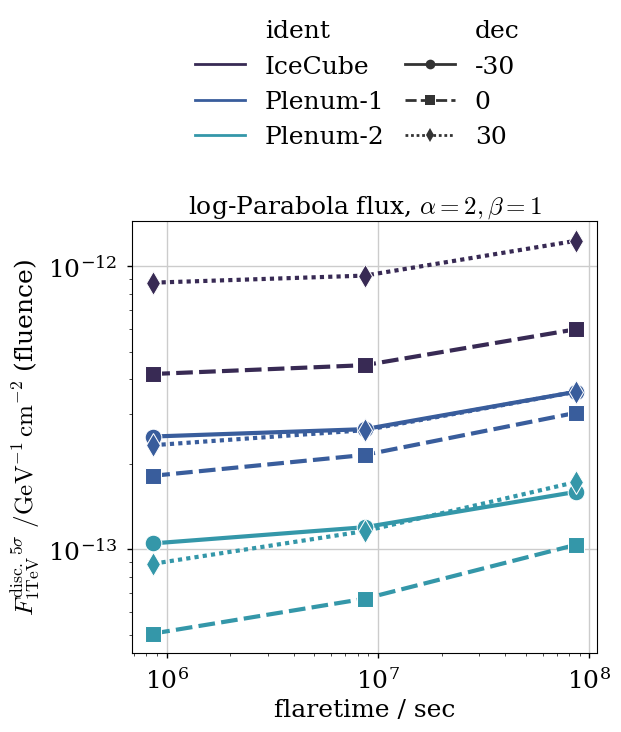

In [ ]:
df = pd.read_pickle(join(st.LOCALPATH, "logP_disc_pot_timedep.pickle"))
flux = pd.DataFrame(
    df.groupby(["ident", "dec", "livetime"]).apply(lambda x: get_scaler(x, st.sigma5))
    * logp_flux.norm,
    columns=["disc5"],
).reset_index()

flux["fluence5"] = flux.disc5 * flux.livetime


f, ax = plt.subplots(figsize=(6, 8))
sns.lineplot(
    flux,
    x="livetime",
    y="fluence5",
    hue="ident",
    style="dec",
    lw="3",
    markers=["o", "s", "d"],
    ms=12,
)
# for (ident, dec), series in flux.groupby(["ident", "dec"]):
#     plt.plot(
#         series.livetime,
#         series.fluence5,
#         lw=3,
#         **{k: det_plotting[ident][k] for k in ["ls", "color"]} # "label"
#     )
ax.set_yscale("log")
ax.set_xscale("log")
# ax.axhline(logp_flux.norm, ls="--", lw=2, color="k", zorder=0)
# ax.axhline(logp_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
# ax.axhline(logp_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)
ax.axes.legend_.remove()
ax.set_xlabel(r"flaretime / sec")
ax.set_ylabel(
    r"$F^{\mathrm{disc.~5\sigma}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} $ (fluence)"
)
f.legend(
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)
# ax.set_ylim(8e-15, 1e-13)
# ax.set_xlim(-1, 1)
f.subplots_adjust(top=0.65)
ax.set_title(rf"log-Parabola flux, $\alpha={Alpha}, \beta={Beta}$")

f.savefig(
    join(st.BASEPATH, "plots/icrc2023/logP_disc_pot_timedep.pdf"), bbox_inches="tight"
)

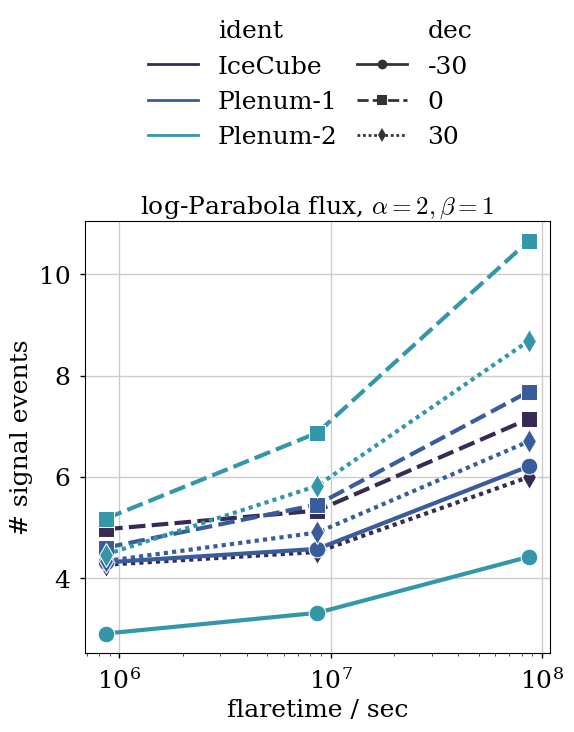

In [ ]:
df = pd.read_pickle(join(st.LOCALPATH, "logP_disc_pot_timedep.pickle"))
flux = pd.DataFrame(
    df.groupby(["ident", "dec", "livetime"]).apply(lambda x: get_scaler(x, st.sigma5, key_y="n_sig")),
    columns=["disc5"],
).reset_index()


f, ax = plt.subplots(figsize=(6, 8))
sns.lineplot(
    flux,
    x="livetime",
    y="disc5",
    hue="ident",
    style="dec",
    lw="3",
    markers=["o", "s", "d"],
    ms=12,
)
# for (ident, dec), series in flux.groupby(["ident", "dec"]):
#     plt.plot(
#         series.livetime,
#         series.fluence5,
#         lw=3,
#         **{k: det_plotting[ident][k] for k in ["ls", "color"]} # "label"
#     )
#ax.set_yscale("log")
ax.set_xscale("log")
# ax.axhline(logp_flux.norm, ls="--", lw=2, color="k", zorder=0)
# ax.axhline(logp_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
# ax.axhline(logp_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)
ax.axes.legend_.remove()
ax.set_xlabel(r"flaretime / sec")
ax.set_ylabel("# signal events")
f.legend(
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)
# ax.set_ylim(8e-15, 1e-13)
# ax.set_xlim(-1, 1)
f.subplots_adjust(top=0.65)
ax.set_title(rf"log-Parabola flux, $\alpha={Alpha}, \beta={Beta}$")

f.savefig(
    join(st.BASEPATH, "plots/icrc2023/logP_disc_pot_timedep.pdf"), bbox_inches="tight"
)